In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
import nltk 
import string
from wordcloud import WordCloud
import zipfile

import glob
import operator
import collections
from operator import itemgetter
from collections import OrderedDict
from collections import Counter
from functools import reduce
from collections import OrderedDict
from collections import defaultdict
os.getcwd()

'/Users/cjcraig/Desktop/CSC 575'

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cjcraig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cjcraig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
stop_words = stopwords.words('english')

### Importing CSV files

In [6]:
with zipfile.ZipFile('home-depot-product-search-relevance 2/train.csv.zip','r') as zip_ref:
    zip_ref.extractall()

In [7]:
df_train = pd.read_csv('train.csv',encoding = "ISO-8859-1")
df_train.head()

id  product_uid                                      product_title  \
0   2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1   3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2   9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3  16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4  17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   

          search_term  relevance  
0       angle bracket       3.00  
1           l bracket       2.50  
2           deck over       3.00  
3    rain shower head       2.33  
4  shower only faucet       2.67

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             74067 non-null  int64  
 1   product_uid    74067 non-null  int64  
 2   product_title  74067 non-null  object 
 3   search_term    74067 non-null  object 
 4   relevance      74067 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB


In [12]:
with zipfile.ZipFile('home-depot-product-search-relevance 2/product_descriptions.csv.zip','r') as zip_ref:
    zip_ref.extractall()

In [13]:
df_desc = pd.read_csv('product_descriptions.csv',encoding = "ISO-8859-1")
df_desc.head()

product_uid                                product_description
0       100001  Not only do angles make joints stronger, they ...
1       100002  BEHR Premium Textured DECKOVER is an innovativ...
2       100003  Classic architecture meets contemporary design...
3       100004  The Grape Solar 265-Watt Polycrystalline PV So...
4       100005  Update your bathroom with the Delta Vero Singl...

In [14]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124428 entries, 0 to 124427
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   product_uid          124428 non-null  int64 
 1   product_description  124428 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


### Exploratory Analysis
##### Finding number of unique search terms in training set

In [15]:
train_search_terms = df_train['search_term'].unique

In [16]:
print('Number of search words in training set')
len(pd.unique(df_train['search_term'])) 

Number of search words in training set


11795

##### Removing stop words and punctuations from search words for both training and testing set

In [17]:
df_train['search_term_without_stopwords'] = df_train['search_term'].apply(lambda x: ' '.join([word for word in x.split() if not word in stop_words and not word in string.punctuation]))

In [18]:
df_test['search_term_without_stopwords'] = df_test['search_term'].apply(lambda x: ' '.join([word for word in x.split() if word not in  stop_words and not word in string.punctuation]))

In [19]:
df_train_keywords = df_train.search_term_without_stopwords.str.split(expand=True).stack().value_counts()
df_train_keywords = df_train_keywords.to_frame().reset_index()
df_train_keywords

index     0
0           door  2643
1          light  1976
2           inch  1485
3           wall  1423
4         shower  1421
...          ...   ...
8849       Meter     1
8850  flourecent     1
8851     regancy     1
8852  stufurhome     1
8853     Pottery     1

[8854 rows x 2 columns]

##### Visualizing the keywords from the training set

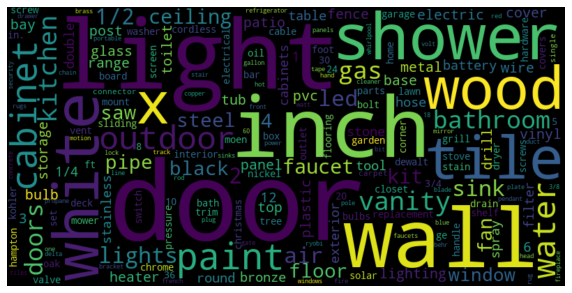

In [20]:
data_train = dict(zip(df_train_keywords['index'].tolist(), df_train_keywords[0].tolist()))
wc_train = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data_train)
plt.figure(figsize=(10, 10))
plt.imshow(wc_train, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
df_train

id  product_uid                                      product_title  \
0           2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1           3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2           9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3          16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4          17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
...       ...          ...                                                ...   
74062  221457       206638  Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...   
74063  221458       206639  Philips 40-Watt Halogen R20 Flood Light Bulb (...   
74064  221463       206641  Schlage Camelot In-Active Aged Bronze Handlese...   
74065  221471       206648  Plastec 11 in. x 24 in. Rose Garden Wall Decor...   
74066  221473       206650  LICHTENBERG Pool Blue No. 918 Millennial Ryan ...   

                                   search_term  relevance  \
0                                angle bracket       3.00   
1                                    l bracket       2.50   
2                                    deck over       3.00   
3                             rain shower head       2.33   
4                           shower only faucet       2.67   
...                                        ...        ...   
74062                           tv riser glass       1.00   
74063                        r20 halogen light       3.00   
74064  schlage lock siena half dummy knob with       2.33   
74065                        zen garden  decor       3.00   
74066             fine sheer curtain 63 inches       2.33   

            search_term_without_stopwords  
0                           angle bracket  
1                               l bracket  
2                                    deck  
3                        rain shower head  
4                           shower faucet  
...                                   ...  
74062                      tv riser glass  
74063                   r20 halogen light  
74064  schlage lock siena half dummy knob  
74065                    zen garden decor  
74066        fine sheer curtain 63 inches  

[74067 rows x 6 columns]

In [22]:
df_desc['product_description_without_stopwords'] = df_desc['product_description'].apply(lambda x: ' '.join([word for word in x.split() if word not in  stop_words and not word in string.punctuation]))
df_desc['product_description_without_stopwords'] = df_desc['product_description_without_stopwords'].str.lower() 
df_desc['product_description_without_stopwords'] = df_desc['product_description_without_stopwords'].str.replace(r'[^\w\s]+', '')
df_desc['product_uid'] = df_desc['product_uid'].astype(str)
df_desc.head()

product_uid                                product_description  \
0      100001  Not only do angles make joints stronger, they ...   
1      100002  BEHR Premium Textured DECKOVER is an innovativ...   
2      100003  Classic architecture meets contemporary design...   
3      100004  The Grape Solar 265-Watt Polycrystalline PV So...   
4      100005  Update your bathroom with the Delta Vero Singl...   

               product_description_without_stopwords  
0  not angles make joints stronger also provide c...  
1  behr premium textured deckover innovative soli...  
2  classic architecture meets contemporary design...  
3  the grape solar 265watt polycrystalline pv sol...  
4  update bathroom delta vero singlehandle shower...

In [23]:
test_df = df_desc[['product_uid','product_description_without_stopwords']]
test_df = test_df[:10000]
test_df.head()

product_uid              product_description_without_stopwords
0      100001  not angles make joints stronger also provide c...
1      100002  behr premium textured deckover innovative soli...
2      100003  classic architecture meets contemporary design...
3      100004  the grape solar 265watt polycrystalline pv sol...
4      100005  update bathroom delta vero singlehandle shower...

### Preparing / Implementing Data for Inverted Index and Search Retrieval

In [24]:
from collections import Counter
def dict_desc(id_col, desc_col):
    desc_dict = {}
    for k,v in zip(id_col,desc_col):
        desc_dict[k] = v.split()
    return desc_dict

In [25]:
desc_dict = dict_desc(test_df['product_uid'],test_df['product_description_without_stopwords'])

In [26]:
#desc_dict

In [27]:
def setup_dict(dict1): #
    new_dict = {}
    for item in dict1.values():
        for w in item:
            if w not in new_dict:
                new_dict[w] = 0
            if w in new_dict:
                new_dict[w] = new_dict[w]+1
                #sort dict
    org_dict = OrderedDict(sorted(new_dict.items(),key = itemgetter(1),reverse = True))
    return org_dict

In [28]:
word_dict = setup_dict(desc_dict) 

In [29]:
#word_dict

##### Total frequency

In [30]:
#similar to set up dict, not a "counter" dict though
def total_freq(dict1): 
    total_freq = dict(Counter(dict1))
    return total_freq
#total_freq(word_dict)

In [31]:
total_freq = total_freq(word_dict)

In [32]:
#total_freq

##### Document frequency

In [33]:
desc_dict_dedup = {k: list(set(v)) for k, v in desc_dict.items()}

In [34]:
#desc_dict_dedup

In [35]:
def doc_freq(dict1):
    d = {}  
    doc_lst = []
    for k,v in dict1.items():
        #print(v) --> sim to doc_lst exmpl assignment1
        for w in v:
            if w in d.keys():
                d[w]= d[w] + 1
            else:
                d[w]=1
    return d

In [36]:
doc_freq = doc_freq(desc_dict_dedup)

In [37]:
#doc_freq

##### Calculating idf

In [38]:
def idf(dict1):
    d = {}
    d_idf = {}
    n = len(dict1)
    for k,v in dict1.items():
        #print(v) --> sim to doc_lst exmpl assignment1
        for w in v:
            if w in d.keys():
                d[w]=d[w]+1
                d[w] = round(np.log2(n/d[w]),3)
            else:
                d[w] = 1
                d[w] = round(np.log2(n/d[w]),3)
    for k2,v2 in d.items():
        #result_idf = round(np.log2(n/v2),3)
        d_idf[k2]= round(np.log2(n/v2),3)
    
    return d_idf
#idf(desc_dict)

In [39]:
idf = idf(desc_dict)

In [40]:
#idf

#### Inverted Index

In [41]:
def inv_idx(dict1):
    keys = sorted(set(list(dict1.keys())))
    doc_lst = []
    new_dict = {}
    print('IdxTerm','--','TotalFreq','--','DocFreq','--','IDF')
    print()
    for w in keys:
        if w in dict1.keys():
            dict1_amt = dict1[w]
            doc_lst.append(dict1_amt)
        
        print(w,'----------',total_freq[w],'----------',doc_freq[w],'-------->',idf[w])#str(doc_lst)[1:-1])
inv_idx(word_dict)

IdxTerm -- TotalFreq -- DocFreq -- IDF

0 ---------- 170 ---------- 149 --------> 9.988
00 ---------- 3 ---------- 3 --------> 9.98
000 ---------- 2 ---------- 2 --------> 10.047
000125uses ---------- 1 ---------- 1 --------> 9.556
001 ---------- 8 ---------- 5 --------> 9.988
0012 ---------- 2 ---------- 2 --------> 10.047
0017 ---------- 1 ---------- 1 --------> 9.556
002 ---------- 6 ---------- 5 --------> 9.988
0020 ---------- 4 ---------- 3 --------> 9.989
0024 ---------- 1 ---------- 1 --------> 9.556
0025 ---------- 2 ---------- 1 --------> 10.047
0028 ---------- 1 ---------- 1 --------> 9.556
003 ---------- 1 ---------- 1 --------> 9.556
0030 ---------- 2 ---------- 2 --------> 10.047
004 ---------- 1 ---------- 1 --------> 9.556
005 ---------- 1 ---------- 1 --------> 9.556
0050 ---------- 4 ---------- 4 --------> 9.989
0050gauge ---------- 1 ---------- 1 --------> 9.556
0060 ---------- 1 ---------- 1 --------> 9.556
0065 ---------- 7 ---------- 4 --------> 9.988
0075 --------

105volt ---------- 1 ---------- 1 --------> 9.556
106 ---------- 9 ---------- 7 --------> 9.988
1060 ---------- 1 ---------- 1 --------> 9.556
1061nsf ---------- 9 ---------- 9 --------> 9.988
10625 ---------- 1 ---------- 1 --------> 9.556
1063 ---------- 1 ---------- 1 --------> 9.556
10656 ---------- 1 ---------- 1 --------> 9.556
106clear ---------- 1 ---------- 1 --------> 9.556
106ideal ---------- 1 ---------- 1 --------> 9.556
106uses ---------- 1 ---------- 1 --------> 9.556
107 ---------- 5 ---------- 5 --------> 9.988
10700 ---------- 1 ---------- 1 --------> 9.556
1075 ---------- 3 ---------- 3 --------> 9.98
1078includes ---------- 1 ---------- 1 --------> 9.556
1078unique ---------- 1 ---------- 1 --------> 9.556
107amp ---------- 1 ---------- 1 --------> 9.556
108 ---------- 30 ---------- 19 --------> 9.988
1080 ---------- 2 ---------- 2 --------> 10.047
108000 ---------- 2 ---------- 1 --------> 10.047
1080p ---------- 10 ---------- 5 --------> 9.988
1080phdcp ----------

125dimmable ---------- 1 ---------- 1 --------> 9.556
125f ---------- 1 ---------- 1 --------> 9.556
125fpressure ---------- 1 ---------- 1 --------> 9.556
125fremoves ---------- 2 ---------- 2 --------> 10.047
125gallon ---------- 1 ---------- 1 --------> 9.556
125v ---------- 1 ---------- 1 --------> 9.556
125volt ---------- 15 ---------- 12 --------> 9.988
125volt13amp1625watt ---------- 4 ---------- 4 --------> 9.989
125volt15amp ---------- 1 ---------- 1 --------> 9.556
125voltfor ---------- 1 ---------- 1 --------> 9.556
125watt ---------- 3 ---------- 3 --------> 9.98
126 ---------- 11 ---------- 10 --------> 9.988
1260 ---------- 1 ---------- 1 --------> 9.556
126contains ---------- 1 ---------- 1 --------> 9.556
127 ---------- 30 ---------- 30 --------> 9.988
1272 ---------- 2 ---------- 1 --------> 10.047
1275 ---------- 2 ---------- 1 --------> 10.047
12750 ---------- 1 ---------- 1 --------> 9.556
128 ---------- 39 ---------- 33 --------> 9.988
1280 ---------- 3 ---------- 

156ideal ---------- 1 ---------- 1 --------> 9.556
157 ---------- 19 ---------- 9 --------> 9.988
1575 ---------- 1 ---------- 1 --------> 9.556
157life ---------- 1 ---------- 1 --------> 9.556
158 ---------- 30 ---------- 24 --------> 9.988
1583470 ---------- 2 ---------- 2 --------> 10.047
1583470durable ---------- 1 ---------- 1 --------> 9.556
158470 ---------- 1 ---------- 1 --------> 9.556
1588 ---------- 2 ---------- 2 --------> 10.047
158cc ---------- 1 ---------- 1 --------> 9.556
158degree ---------- 1 ---------- 1 --------> 9.556
158f ---------- 1 ---------- 1 --------> 9.556
159 ---------- 7 ---------- 3 --------> 9.988
1594 ---------- 1 ---------- 1 --------> 9.556
1597 ---------- 1 ---------- 1 --------> 9.556
1598 ---------- 1 ---------- 1 --------> 9.556
1599 ---------- 1 ---------- 1 --------> 9.556
1599205 ---------- 2 ---------- 2 --------> 10.047
1599500020 ---------- 1 ---------- 1 --------> 9.556
1599500020accommodates ---------- 1 ---------- 1 --------> 9.556
15

18554002552 ---------- 38 ---------- 38 --------> 9.988
185564 ---------- 1 ---------- 1 --------> 9.556
18556502786 ---------- 2 ---------- 2 --------> 10.047
18558924386 ---------- 3 ---------- 3 --------> 9.98
1858 ---------- 1 ---------- 1 --------> 9.556
185hp ---------- 1 ---------- 1 --------> 9.556
185watt ---------- 1 ---------- 1 --------> 9.556
186 ---------- 7 ---------- 5 --------> 9.988
18625 ---------- 2 ---------- 2 --------> 10.047
18650 ---------- 1 ---------- 1 --------> 9.556
18663251065home ---------- 1 ---------- 1 --------> 9.556
18667483025fits ---------- 1 ---------- 1 --------> 9.556
1867 ---------- 4 ---------- 2 --------> 9.989
187 ---------- 1 ---------- 1 --------> 9.556
1875 ---------- 5 ---------- 5 --------> 9.988
18750 ---------- 1 ---------- 1 --------> 9.556
1875ideal ---------- 1 ---------- 1 --------> 9.556
1875watt ---------- 1 ---------- 1 --------> 9.556
1875wattul ---------- 1 ---------- 1 --------> 9.556
188 ---------- 13 ---------- 11 -------

2038 ---------- 1 ---------- 1 --------> 9.556
2040 ---------- 1 ---------- 1 --------> 9.556
204077179jet ---------- 1 ---------- 1 --------> 9.556
204080650remote ---------- 1 ---------- 1 --------> 9.556
204207209309320 ---------- 1 ---------- 1 --------> 9.556
204212801 ---------- 1 ---------- 1 --------> 9.556
204399253 ---------- 1 ---------- 1 --------> 9.556
20443 ---------- 1 ---------- 1 --------> 9.556
204498426 ---------- 1 ---------- 1 --------> 9.556
204498426premium ---------- 1 ---------- 1 --------> 9.556
204512712 ---------- 1 ---------- 1 --------> 9.556
204512734 ---------- 1 ---------- 1 --------> 9.556
204683990estimated ---------- 1 ---------- 1 --------> 9.556
204683991estimated ---------- 1 ---------- 1 --------> 9.556
204683992estimated ---------- 1 ---------- 1 --------> 9.556
204779531designed ---------- 1 ---------- 1 --------> 9.556
204859388 ---------- 1 ---------- 1 --------> 9.556
204c ---------- 1 ---------- 1 --------> 9.556
205 ---------- 24 --------

24teeth ---------- 1 ---------- 1 --------> 9.556
24tooth ---------- 1 ---------- 1 --------> 9.556
24v ---------- 1 ---------- 1 --------> 9.556
24volt ---------- 16 ---------- 12 --------> 9.988
24watt ---------- 1 ---------- 1 --------> 9.556
25 ---------- 380 ---------- 319 --------> 9.988
250 ---------- 98 ---------- 80 --------> 9.988
2500 ---------- 21 ---------- 18 --------> 9.988
25000 ---------- 16 ---------- 16 --------> 9.988
250000 ---------- 1 ---------- 1 --------> 9.556
25000h ---------- 1 ---------- 1 --------> 9.556
25006800 ---------- 2 ---------- 1 --------> 10.047
2500k ---------- 1 ---------- 1 --------> 9.556
2500piece ---------- 1 ---------- 1 --------> 9.556
2500watt ---------- 1 ---------- 1 --------> 9.556
250146 ---------- 1 ---------- 1 --------> 9.556
250148 ---------- 1 ---------- 1 --------> 9.556
25024 ---------- 2 ---------- 1 --------> 10.047
250_ffits ---------- 1 ---------- 1 --------> 9.556
250c ---------- 1 ---------- 1 --------> 9.556
250f ------

2inch ---------- 1 ---------- 1 --------> 9.556
2ines ---------- 1 ---------- 1 --------> 9.556
2insulated ---------- 1 ---------- 1 --------> 9.556
2k ---------- 1 ---------- 1 --------> 9.556
2keg ---------- 1 ---------- 1 --------> 9.556
2kp543 ---------- 1 ---------- 1 --------> 9.556
2lamp ---------- 4 ---------- 4 --------> 9.989
2large ---------- 1 ---------- 1 --------> 9.556
2layer ---------- 3 ---------- 3 --------> 9.98
2level ---------- 6 ---------- 6 --------> 9.988
2light ---------- 29 ---------- 27 --------> 9.988
2line ---------- 1 ---------- 1 --------> 9.556
2liter ---------- 4 ---------- 4 --------> 9.989
2locking ---------- 1 ---------- 1 --------> 9.556
2lower ---------- 1 ---------- 1 --------> 9.556
2m ---------- 3 ---------- 3 --------> 9.98
2maximum ---------- 1 ---------- 1 --------> 9.556
2metal ---------- 1 ---------- 1 --------> 9.556
2minutes ---------- 1 ---------- 1 --------> 9.556
2minutescompact ---------- 1 ---------- 1 --------> 9.556
2mm ---------- 

3438 ---------- 3 ---------- 2 --------> 9.98
3443 ---------- 1 ---------- 1 --------> 9.556
3448 ---------- 1 ---------- 1 --------> 9.556
345 ---------- 12 ---------- 11 --------> 9.988
3450 ---------- 7 ---------- 3 --------> 9.988
345csobk ---------- 1 ---------- 1 --------> 9.556
345rsobk ---------- 1 ---------- 1 --------> 9.556
346 ---------- 3 ---------- 2 --------> 9.98
3463170 ---------- 1 ---------- 1 --------> 9.556
347 ---------- 4 ---------- 4 --------> 9.989
3475 ---------- 3 ---------- 3 --------> 9.98
3478 ---------- 5 ---------- 5 --------> 9.988
347bul ---------- 1 ---------- 1 --------> 9.556
348 ---------- 1 ---------- 1 --------> 9.556
3488 ---------- 1 ---------- 1 --------> 9.556
349 ---------- 1 ---------- 1 --------> 9.556
34cfm ---------- 1 ---------- 1 --------> 9.556
34ha ---------- 2 ---------- 1 --------> 10.047
34habr ---------- 1 ---------- 1 --------> 9.556
34in ---------- 1 ---------- 1 --------> 9.556
34inch ---------- 2 ---------- 2 --------> 10.047

400f ---------- 7 ---------- 7 --------> 9.988
400g ---------- 2 ---------- 2 --------> 10.047
400hb ---------- 1 ---------- 1 --------> 9.556
400psiheavyduty ---------- 1 ---------- 1 --------> 9.556
400shelf ---------- 1 ---------- 1 --------> 9.556
400voltcontinuity ---------- 1 ---------- 1 --------> 9.556
400watt ---------- 8 ---------- 7 --------> 9.988
401 ---------- 2 ---------- 2 --------> 10.047
4012 ---------- 3 ---------- 2 --------> 9.98
40204 ---------- 1 ---------- 1 --------> 9.556
403 ---------- 1 ---------- 1 --------> 9.556
40404020 ---------- 1 ---------- 1 --------> 9.556
405 ---------- 3 ---------- 3 --------> 9.98
406 ---------- 4 ---------- 2 --------> 9.989
40611 ---------- 1 ---------- 1 --------> 9.556
40612 ---------- 2 ---------- 2 --------> 10.047
407 ---------- 2 ---------- 2 --------> 10.047
4070 ---------- 2 ---------- 1 --------> 10.047
4076 ---------- 1 ---------- 1 --------> 9.556
408 ---------- 1 ---------- 1 --------> 9.556
4082watt ---------- 1 --

48oz ---------- 3 ---------- 3 --------> 9.98
48volt ---------- 2 ---------- 1 --------> 10.047
49 ---------- 26 ---------- 21 --------> 9.988
49000 ---------- 2 ---------- 1 --------> 10.047
49005400 ---------- 2 ---------- 1 --------> 10.047
49047 ---------- 1 ---------- 1 --------> 9.556
4912 ---------- 1 ---------- 1 --------> 9.556
4914x1418x378 ---------- 1 ---------- 1 --------> 9.556
4916 ---------- 49 ---------- 40 --------> 9.988
492 ---------- 2 ---------- 2 --------> 10.047
4920 ---------- 1 ---------- 1 --------> 9.556
4920gph ---------- 1 ---------- 1 --------> 9.556
49240145 ---------- 1 ---------- 1 --------> 9.556
4925 ---------- 3 ---------- 3 --------> 9.98
4934 ---------- 1 ---------- 1 --------> 9.556
4935 ---------- 1 ---------- 1 --------> 9.556
49451set ---------- 1 ---------- 1 --------> 9.556
49567210 ---------- 5 ---------- 5 --------> 9.988
49567240 ---------- 5 ---------- 5 --------> 9.988
49567250 ---------- 5 ---------- 5 --------> 9.988
49569100rip -----

56 ---------- 47 ---------- 42 --------> 9.988
5600 ---------- 3 ---------- 2 --------> 9.98
5612 ---------- 8 ---------- 8 --------> 9.988
5625 ---------- 1 ---------- 1 --------> 9.556
5638 ---------- 1 ---------- 1 --------> 9.556
564 ---------- 15 ---------- 11 --------> 9.988
5652contains ---------- 1 ---------- 1 --------> 9.556
5658 ---------- 3 ---------- 3 --------> 9.98
565deck ---------- 1 ---------- 1 --------> 9.556
565uses ---------- 1 ---------- 1 --------> 9.556
5660 ---------- 3 ---------- 2 --------> 9.98
56v ---------- 1 ---------- 1 --------> 9.556
56vdc ---------- 1 ---------- 1 --------> 9.556
56volt ---------- 15 ---------- 8 --------> 9.988
56watt ---------- 1 ---------- 1 --------> 9.556
57 ---------- 21 ---------- 21 --------> 9.988
570 ---------- 1 ---------- 1 --------> 9.556
5700 ---------- 1 ---------- 1 --------> 9.556
5714 ---------- 1 ---------- 1 --------> 9.556
5714388seats ---------- 2 ---------- 2 --------> 10.047
5716 ---------- 2 ---------- 2 ----

6512 ---------- 1 ---------- 1 --------> 9.556
651930 ---------- 1 ---------- 1 --------> 9.556
651931 ---------- 4 ---------- 1 --------> 9.989
654 ---------- 1 ---------- 1 --------> 9.556
6542 ---------- 1 ---------- 1 --------> 9.556
655 ---------- 1 ---------- 1 --------> 9.556
656 ---------- 1 ---------- 1 --------> 9.556
6562 ---------- 1 ---------- 1 --------> 9.556
658 ---------- 5 ---------- 5 --------> 9.988
65amp ---------- 4 ---------- 3 --------> 9.989
65bushel ---------- 1 ---------- 1 --------> 9.556
65f ---------- 1 ---------- 1 --------> 9.556
65indoor ---------- 1 ---------- 1 --------> 9.556
65uses ---------- 2 ---------- 2 --------> 10.047
65v ---------- 1 ---------- 1 --------> 9.556
65w ---------- 2 ---------- 2 --------> 10.047
65watt ---------- 17 ---------- 13 --------> 9.988
65wattlumens ---------- 1 ---------- 1 --------> 9.556
65wattlumenswatt ---------- 1 ---------- 1 --------> 9.556
66 ---------- 22 ---------- 19 --------> 9.988
660 ---------- 7 ---------

751 ---------- 1 ---------- 1 --------> 9.556
75100 ---------- 2 ---------- 2 --------> 10.047
75120 ---------- 2 ---------- 1 --------> 10.047
7540241a ---------- 1 ---------- 1 --------> 9.556
75404045contains ---------- 1 ---------- 1 --------> 9.556
7558 ---------- 1 ---------- 1 --------> 9.556
756 ---------- 1 ---------- 1 --------> 9.556
7569 ---------- 1 ---------- 1 --------> 9.556
756cc ---------- 2 ---------- 1 --------> 10.047
758 ---------- 5 ---------- 4 --------> 9.988
758144150 ---------- 1 ---------- 1 --------> 9.556
758144151 ---------- 1 ---------- 1 --------> 9.556
758144170 ---------- 1 ---------- 1 --------> 9.556
758144171 ---------- 1 ---------- 1 --------> 9.556
75814452 ---------- 1 ---------- 1 --------> 9.556
758144520 ---------- 1 ---------- 1 --------> 9.556
758144521 ---------- 1 ---------- 1 --------> 9.556
758144522 ---------- 1 ---------- 1 --------> 9.556
758144523 ---------- 1 ---------- 1 --------> 9.556
758144530 ---------- 1 ---------- 1 --------

9000higharc ---------- 1 ---------- 1 --------> 9.556
9000lifeshine ---------- 1 ---------- 1 --------> 9.556
9001 ---------- 3 ---------- 3 --------> 9.98
90012008 ---------- 5 ---------- 5 --------> 9.988
900watt ---------- 2 ---------- 1 --------> 10.047
900watt106cc ---------- 1 ---------- 1 --------> 9.556
9010d ---------- 1 ---------- 1 --------> 9.556
90110 ---------- 1 ---------- 1 --------> 9.556
901football ---------- 2 ---------- 2 --------> 10.047
90249 ---------- 1 ---------- 1 --------> 9.556
903 ---------- 1 ---------- 1 --------> 9.556
907020 ---------- 1 ---------- 1 --------> 9.556
9084638 ---------- 1 ---------- 1 --------> 9.556
9084640 ---------- 1 ---------- 1 --------> 9.556
9084642painted ---------- 1 ---------- 1 --------> 9.556
9088ideal ---------- 1 ---------- 1 --------> 9.556
90_ ---------- 4 ---------- 3 --------> 9.989
90_c ---------- 2 ---------- 2 --------> 10.047
90a ---------- 2 ---------- 2 --------> 10.047
90b ---------- 2 ---------- 2 --------> 10.

ac193 ---------- 2 ---------- 2 --------> 10.047
ac27p ---------- 1 ---------- 1 --------> 9.556
ac3 ---------- 2 ---------- 2 --------> 10.047
ac4 ---------- 4 ---------- 4 --------> 9.989
ac46182 ---------- 4 ---------- 4 --------> 9.989
ac470013 ---------- 4 ---------- 4 --------> 9.989
ac56uh ---------- 1 ---------- 1 --------> 9.556
ac58tl ---------- 1 ---------- 1 --------> 9.556
ac7014 ---------- 1 ---------- 1 --------> 9.556
ac840083 ---------- 4 ---------- 4 --------> 9.989
ac840084 ---------- 4 ---------- 4 --------> 9.989
ac840085 ---------- 4 ---------- 4 --------> 9.989
ac840093 ---------- 2 ---------- 2 --------> 10.047
ac840093click ---------- 2 ---------- 2 --------> 10.047
acacia ---------- 10 ---------- 7 --------> 9.988
acacia34 ---------- 1 ---------- 1 --------> 9.556
acaciaeach ---------- 2 ---------- 2 --------> 10.047
academically ---------- 1 ---------- 1 --------> 9.556
academy ---------- 1 ---------- 1 --------> 9.556
acapella ---------- 1 ---------- 1 -----

acs30 ---------- 1 ---------- 1 --------> 9.556
acsafe ---------- 2 ---------- 2 --------> 10.047
acsneutral ---------- 1 ---------- 1 --------> 9.556
act ---------- 85 ---------- 84 --------> 9.988
act15 ---------- 1 ---------- 1 --------> 9.556
act150 ---------- 1 ---------- 1 --------> 9.556
acting ---------- 12 ---------- 11 --------> 9.988
actinglow ---------- 1 ---------- 1 --------> 9.556
actinic ---------- 4 ---------- 1 --------> 9.989
action ---------- 133 ---------- 111 --------> 9.988
action14 ---------- 1 ---------- 1 --------> 9.556
action2 ---------- 1 ---------- 1 --------> 9.556
action30 ---------- 1 ---------- 1 --------> 9.556
action34 ---------- 1 ---------- 1 --------> 9.556
action5 ---------- 1 ---------- 1 --------> 9.556
action7 ---------- 1 ---------- 1 --------> 9.556
actionball ---------- 1 ---------- 1 --------> 9.556
actionbrushed ---------- 1 ---------- 1 --------> 9.556
actionchrome ---------- 1 ---------- 1 --------> 9.556
actionclear ---------- 1 ------

adult ---------- 9 ---------- 9 --------> 9.988
adults ---------- 33 ---------- 30 --------> 9.988
adults128 ---------- 6 ---------- 6 --------> 9.988
adultsautomatic ---------- 1 ---------- 1 --------> 9.556
adultscomplete ---------- 1 ---------- 1 --------> 9.556
adultseasily ---------- 1 ---------- 1 --------> 9.556
adultseasy ---------- 1 ---------- 1 --------> 9.556
adultsincludes ---------- 1 ---------- 1 --------> 9.556
adultslefthand ---------- 2 ---------- 2 --------> 10.047
adultsmade ---------- 1 ---------- 1 --------> 9.556
adultsportableno ---------- 1 ---------- 1 --------> 9.556
adultsseat ---------- 1 ---------- 1 --------> 9.556
adultstopmount ---------- 1 ---------- 1 --------> 9.556
advance ---------- 14 ---------- 13 --------> 9.988
advanced ---------- 236 ---------- 191 --------> 9.988
advancefresh ---------- 1 ---------- 1 --------> 9.556
advancement ---------- 1 ---------- 1 --------> 9.556
advancements ---------- 1 ---------- 1 --------> 9.556
advances ---------

alertsmagnetic ---------- 1 ---------- 1 --------> 9.556
alertsquick ---------- 1 ---------- 1 --------> 9.556
alertsselectable ---------- 1 ---------- 1 --------> 9.556
alertthis ---------- 1 ---------- 1 --------> 9.556
alex ---------- 1 ---------- 1 --------> 9.556
alexander ---------- 2 ---------- 1 --------> 10.047
alexandria ---------- 5 ---------- 2 --------> 9.988
alexei ---------- 1 ---------- 1 --------> 9.556
alflo ---------- 10 ---------- 10 --------> 9.988
algae ---------- 19 ---------- 18 --------> 9.988
algaecide ---------- 2 ---------- 1 --------> 10.047
algaefree ---------- 1 ---------- 1 --------> 9.556
algaestabilized ---------- 1 ---------- 1 --------> 9.556
algaestage ---------- 1 ---------- 1 --------> 9.556
alicante ---------- 3 ---------- 1 --------> 9.98
alien ---------- 2 ---------- 1 --------> 10.047
align ---------- 15 ---------- 15 --------> 9.988
aligned ---------- 7 ---------- 7 --------> 9.988
aligner ---------- 2 ---------- 1 --------> 10.047
aligning -

anchor ---------- 77 ---------- 54 --------> 9.988
anchoraudible ---------- 2 ---------- 2 --------> 10.047
anchored ---------- 10 ---------- 10 --------> 9.988
anchoredallsteel ---------- 1 ---------- 1 --------> 9.556
anchoring ---------- 28 ---------- 17 --------> 9.988
anchoringinteriorexterior ---------- 1 ---------- 1 --------> 9.556
anchorprecisionmachined ---------- 1 ---------- 1 --------> 9.556
anchorrounded ---------- 2 ---------- 2 --------> 10.047
anchors ---------- 77 ---------- 54 --------> 9.988
anchors8 ---------- 1 ---------- 1 --------> 9.556
anchorscan ---------- 1 ---------- 1 --------> 9.556
anchorslifetime ---------- 1 ---------- 1 --------> 9.556
anchorslimited ---------- 1 ---------- 1 --------> 9.556
anchorsmade ---------- 1 ---------- 1 --------> 9.556
anchorsshipped ---------- 1 ---------- 1 --------> 9.556
anchorssteel ---------- 1 ---------- 1 --------> 9.556
anchorsstepbystep ---------- 1 ---------- 1 --------> 9.556
anchorstools ---------- 2 ---------- 2

appearance1944 ---------- 1 ---------- 1 --------> 9.556
appearance1year ---------- 2 ---------- 2 --------> 10.047
appearance2 ---------- 3 ---------- 3 --------> 9.98
appearance212 ---------- 1 ---------- 1 --------> 9.556
appearance2500 ---------- 1 ---------- 1 --------> 9.556
appearance2600 ---------- 1 ---------- 1 --------> 9.556
appearance28watt ---------- 2 ---------- 2 --------> 10.047
appearance36 ---------- 1 ---------- 1 --------> 9.556
appearance3hole ---------- 1 ---------- 1 --------> 9.556
appearance4 ---------- 2 ---------- 2 --------> 10.047
appearance400 ---------- 1 ---------- 1 --------> 9.556
appearance61 ---------- 1 ---------- 1 --------> 9.556
appearance612 ---------- 1 ---------- 1 --------> 9.556
appearance67 ---------- 1 ---------- 1 --------> 9.556
appearance9 ---------- 1 ---------- 1 --------> 9.556
appearanceable ---------- 1 ---------- 1 --------> 9.556
appearanceaccepts ---------- 1 ---------- 1 --------> 9.556
appearanceactual ---------- 4 ----------

applicationsecosav ---------- 1 ---------- 1 --------> 9.556
applicationselectric ---------- 4 ---------- 4 --------> 9.989
applicationselectrolytic ---------- 1 ---------- 1 --------> 9.556
applicationselfleveling ---------- 2 ---------- 2 --------> 10.047
applicationsenergy ---------- 1 ---------- 1 --------> 9.556
applicationsenhanced ---------- 1 ---------- 1 --------> 9.556
applicationsergonomic ---------- 1 ---------- 1 --------> 9.556
applicationsetl ---------- 1 ---------- 1 --------> 9.556
applicationsexcellent ---------- 1 ---------- 1 --------> 9.556
applicationsextended ---------- 1 ---------- 1 --------> 9.556
applicationsextendedbody ---------- 1 ---------- 1 --------> 9.556
applicationsextruded ---------- 1 ---------- 1 --------> 9.556
applicationsez ---------- 2 ---------- 2 --------> 10.047
applicationsfasten ---------- 1 ---------- 1 --------> 9.556
applicationsfeatures ---------- 2 ---------- 2 --------> 10.047
applicationsfive ---------- 1 ---------- 1 --------> 9.5

ara ---------- 1 ---------- 1 --------> 9.556
arabic ---------- 5 ---------- 4 --------> 9.988
aragon ---------- 6 ---------- 3 --------> 9.988
arbor ---------- 33 ---------- 25 --------> 9.988
arborconstructed ---------- 1 ---------- 1 --------> 9.556
arbordiamond ---------- 1 ---------- 1 --------> 9.556
arbordouble ---------- 1 ---------- 1 --------> 9.556
arborideal ---------- 2 ---------- 2 --------> 10.047
arbors ---------- 16 ---------- 15 --------> 9.988
arbors4 ---------- 1 ---------- 1 --------> 9.556
arbors60 ---------- 1 ---------- 1 --------> 9.556
arborsgreat ---------- 2 ---------- 2 --------> 10.047
arborsprovides ---------- 1 ---------- 1 --------> 9.556
arborstall ---------- 1 ---------- 1 --------> 9.556
arbortype ---------- 1 ---------- 1 --------> 9.556
arborvitae ---------- 2 ---------- 2 --------> 10.047
arc ---------- 43 ---------- 32 --------> 9.988
arc10wb ---------- 2 ---------- 1 --------> 10.047
arc110wd ---------- 1 ---------- 1 --------> 9.556
arc142bx --

ashton ---------- 1 ---------- 1 --------> 9.556
ashurst ---------- 1 ---------- 1 --------> 9.556
ashville ---------- 2 ---------- 1 --------> 10.047
ashworth ---------- 2 ---------- 2 --------> 10.047
asia ---------- 3 ---------- 3 --------> 9.98
asian ---------- 5 ---------- 4 --------> 9.988
asic ---------- 1 ---------- 1 --------> 9.556
asis ---------- 4 ---------- 4 --------> 9.989
ask ---------- 11 ---------- 9 --------> 9.988
asleep ---------- 1 ---------- 1 --------> 9.556
asme ---------- 23 ---------- 21 --------> 9.988
asmeansi ---------- 1 ---------- 1 --------> 9.556
aspark ---------- 1 ---------- 1 --------> 9.556
aspca ---------- 1 ---------- 1 --------> 9.556
aspect ---------- 6 ---------- 4 --------> 9.988
aspectek ---------- 3 ---------- 2 --------> 9.98
aspects ---------- 2 ---------- 2 --------> 10.047
aspen ---------- 8 ---------- 6 --------> 9.988
asphalt ---------- 47 ---------- 42 --------> 9.988
asphaltbased ---------- 3 ---------- 2 --------> 9.98
asphaltic --

atticadjustable ---------- 2 ---------- 2 --------> 10.047
atticappealing ---------- 1 ---------- 1 --------> 9.556
atticat ---------- 1 ---------- 1 --------> 9.556
atticbasement ---------- 1 ---------- 1 --------> 9.556
atticbuying ---------- 3 ---------- 3 --------> 9.98
atticfits ---------- 3 ---------- 3 --------> 9.98
atticfloor ---------- 1 ---------- 1 --------> 9.556
atticgalvanized ---------- 1 ---------- 1 --------> 9.556
atticincluded ---------- 3 ---------- 3 --------> 9.98
atticladder ---------- 1 ---------- 1 --------> 9.556
atticloft ---------- 2 ---------- 2 --------> 10.047
atticmaximum ---------- 1 ---------- 1 --------> 9.556
attics ---------- 30 ---------- 27 --------> 9.988
atticsprovides ---------- 5 ---------- 5 --------> 9.988
atticsul ---------- 1 ---------- 1 --------> 9.556
atticsyou ---------- 5 ---------- 5 --------> 9.988
atticthe ---------- 1 ---------- 1 --------> 9.556
attitude ---------- 2 ---------- 2 --------> 10.047
attract ---------- 36 ----------

b105 ---------- 2 ---------- 2 --------> 10.047
b11 ---------- 2 ---------- 2 --------> 10.047
b1201 ---------- 5 ---------- 5 --------> 9.988
b1201consult ---------- 1 ---------- 1 --------> 9.556
b1201install ---------- 2 ---------- 2 --------> 10.047
b1201leadfree ---------- 1 ---------- 1 --------> 9.556
b1201malleable ---------- 1 ---------- 1 --------> 9.556
b1201note ---------- 3 ---------- 3 --------> 9.98
b1201standard ---------- 1 ---------- 1 --------> 9.556
b125 ---------- 1 ---------- 1 --------> 9.556
b1251 ---------- 2 ---------- 2 --------> 10.047
b1251designed ---------- 3 ---------- 3 --------> 9.98
b1256 ---------- 1 ---------- 1 --------> 9.556
b1256designed ---------- 1 ---------- 1 --------> 9.556
b1256note ---------- 2 ---------- 2 --------> 10.047
b1375 ---------- 4 ---------- 2 --------> 9.989
b1622 ---------- 1 ---------- 1 --------> 9.556
b172 ---------- 1 ---------- 1 --------> 9.556
b2 ---------- 6 ---------- 6 --------> 9.988
b22 ---------- 1 ---------- 1 

balanced ---------- 61 ---------- 59 --------> 9.988
balanceddoesnt ---------- 1 ---------- 1 --------> 9.556
balancedsafe ---------- 1 ---------- 1 --------> 9.556
balancer ---------- 1 ---------- 1 --------> 9.556
balances ---------- 5 ---------- 1 --------> 9.988
balancework ---------- 1 ---------- 1 --------> 9.556
balancing ---------- 6 ---------- 5 --------> 9.988
balancingspeedicollar ---------- 1 ---------- 1 --------> 9.556
balboa ---------- 3 ---------- 3 --------> 9.98
balconies ---------- 35 ---------- 31 --------> 9.988
balconiescalifornia ---------- 1 ---------- 1 --------> 9.556
balconiesmade ---------- 1 ---------- 1 --------> 9.556
balcony ---------- 17 ---------- 17 --------> 9.988
bald ---------- 2 ---------- 1 --------> 10.047
baldrige ---------- 1 ---------- 1 --------> 9.556
baldwin ---------- 19 ---------- 7 --------> 9.988
bale ---------- 4 ---------- 4 --------> 9.989
baled ---------- 1 ---------- 1 --------> 9.556
bali ---------- 17 ---------- 9 --------> 9.98

basketuses ---------- 1 ---------- 1 --------> 9.556
basketwasher ---------- 2 ---------- 2 --------> 10.047
basketweave ---------- 5 ---------- 3 --------> 9.988
basketweaveeach ---------- 1 ---------- 1 --------> 9.556
basketweaveguaranteed ---------- 2 ---------- 2 --------> 10.047
bass ---------- 4 ---------- 4 --------> 9.989
basset ---------- 2 ---------- 1 --------> 10.047
basswood ---------- 12 ---------- 8 --------> 9.988
basswoodadds ---------- 1 ---------- 1 --------> 9.556
basswoodcan ---------- 1 ---------- 1 --------> 9.556
basswoodroom ---------- 1 ---------- 1 --------> 9.556
bastard ---------- 6 ---------- 3 --------> 9.988
bastardcut ---------- 7 ---------- 3 --------> 9.988
basting ---------- 4 ---------- 2 --------> 9.989
bat ---------- 1 ---------- 1 --------> 9.556
bat819 ---------- 4 ---------- 1 --------> 9.989
bat837home ---------- 1 ---------- 1 --------> 9.556
batch ---------- 8 ---------- 6 --------> 9.988
batchdispense ---------- 1 ---------- 1 --------> 9.

beaters ---------- 4 ---------- 2 --------> 9.989
beating ---------- 2 ---------- 2 --------> 10.047
beats ---------- 2 ---------- 2 --------> 10.047
beattricut ---------- 1 ---------- 1 --------> 9.556
beaulieu ---------- 1 ---------- 1 --------> 9.556
beautified ---------- 1 ---------- 1 --------> 9.556
beautifies ---------- 13 ---------- 13 --------> 9.988
beautiful ---------- 580 ---------- 536 --------> 9.988
beautiful44 ---------- 1 ---------- 1 --------> 9.556
beautifulcalifornia ---------- 2 ---------- 2 --------> 10.047
beautifuldimensions ---------- 1 ---------- 1 --------> 9.556
beautifulflat ---------- 1 ---------- 1 --------> 9.556
beautifulhide ---------- 1 ---------- 1 --------> 9.556
beautifully ---------- 152 ---------- 147 --------> 9.988
beautifullyeasy ---------- 1 ---------- 1 --------> 9.556
beautifullynote ---------- 1 ---------- 1 --------> 9.556
beautifullyul ---------- 3 ---------- 3 --------> 9.98
beautifulmachine ---------- 2 ---------- 2 --------> 10.047
be

benefitslight ---------- 1 ---------- 1 --------> 9.556
benefitsmade ---------- 2 ---------- 2 --------> 10.047
benign ---------- 3 ---------- 3 --------> 9.98
bennett ---------- 1 ---------- 1 --------> 9.556
benotification ---------- 1 ---------- 1 --------> 9.556
bent ---------- 14 ---------- 14 --------> 9.988
bentgrass ---------- 2 ---------- 2 --------> 10.047
bentley ---------- 5 ---------- 2 --------> 9.988
bentwood ---------- 1 ---------- 1 --------> 9.556
benzene ---------- 1 ---------- 1 --------> 9.556
beone ---------- 1 ---------- 1 --------> 9.556
bepressureassisted ---------- 1 ---------- 1 --------> 9.556
berber ---------- 1 ---------- 1 --------> 9.556
bercello ---------- 2 ---------- 1 --------> 10.047
berkeley ---------- 2 ---------- 2 --------> 10.047
berkley ---------- 2 ---------- 2 --------> 10.047
berkshire ---------- 2 ---------- 1 --------> 10.047
bermuda ---------- 6 ---------- 6 --------> 9.988
bermudagrass ---------- 1 ---------- 1 --------> 9.556
bern ----

bladeincluded ---------- 1 ---------- 1 --------> 9.556
bladeincludes ---------- 2 ---------- 2 --------> 10.047
bladejumbo ---------- 1 ---------- 1 --------> 9.556
bladekey ---------- 1 ---------- 1 --------> 9.556
bladekohler ---------- 1 ---------- 1 --------> 9.556
bladelarge ---------- 1 ---------- 1 --------> 9.556
bladelasercut ---------- 1 ---------- 1 --------> 9.556
bladelong ---------- 1 ---------- 1 --------> 9.556
blademade ---------- 3 ---------- 3 --------> 9.98
blademaximum ---------- 2 ---------- 2 --------> 10.047
blademiter ---------- 1 ---------- 1 --------> 9.556
bladeoptimized ---------- 1 ---------- 1 --------> 9.556
bladeremovable ---------- 1 ---------- 1 --------> 9.556
bladerequires ---------- 1 ---------- 1 --------> 9.556
blades ---------- 378 ---------- 197 --------> 9.988
blades1 ---------- 1 ---------- 1 --------> 9.556
blades10 ---------- 1 ---------- 1 --------> 9.556
blades14tpi ---------- 1 ---------- 1 --------> 9.556
blades24teeth ---------- 1 ---

body7 ---------- 1 ---------- 1 --------> 9.556
bodyaccepts ---------- 1 ---------- 1 --------> 9.556
bodyaids ---------- 1 ---------- 1 --------> 9.556
bodyanodized ---------- 1 ---------- 1 --------> 9.556
bodyautomatic ---------- 1 ---------- 1 --------> 9.556
bodyautomotive ---------- 1 ---------- 1 --------> 9.556
bodycalifornia ---------- 3 ---------- 3 --------> 9.98
bodycelcon ---------- 2 ---------- 2 --------> 10.047
bodycomfort ---------- 1 ---------- 1 --------> 9.556
bodycomfortable ---------- 1 ---------- 1 --------> 9.556
bodycontoured ---------- 2 ---------- 2 --------> 10.047
bodyconvenient ---------- 1 ---------- 1 --------> 9.556
bodydurable ---------- 1 ---------- 1 --------> 9.556
bodyfor ---------- 1 ---------- 1 --------> 9.556
bodygreat ---------- 1 ---------- 1 --------> 9.556
bodyincludes ---------- 1 ---------- 1 --------> 9.556
bodylarge ---------- 1 ---------- 1 --------> 9.556
bodyleak ---------- 1 ---------- 1 --------> 9.556
bodylimited ---------- 1 ----

boxesproduct ---------- 1 ---------- 1 --------> 9.556
boxesslate ---------- 1 ---------- 1 --------> 9.556
boxessnapon ---------- 1 ---------- 1 --------> 9.556
boxessold ---------- 1 ---------- 1 --------> 9.556
boxesthis ---------- 1 ---------- 1 --------> 9.556
boxestoughcut ---------- 1 ---------- 1 --------> 9.556
boxeswithstands ---------- 1 ---------- 1 --------> 9.556
boxextra ---------- 1 ---------- 1 --------> 9.556
boxfits ---------- 1 ---------- 1 --------> 9.556
boxfor ---------- 15 ---------- 15 --------> 9.988
boxgate ---------- 1 ---------- 1 --------> 9.556
boxgreat ---------- 1 ---------- 1 --------> 9.556
boxheavy ---------- 1 ---------- 1 --------> 9.556
boxhighest ---------- 1 ---------- 1 --------> 9.556
boxhighquality ---------- 1 ---------- 1 --------> 9.556
boxhome ---------- 3 ---------- 3 --------> 9.98
boxincludes ---------- 3 ---------- 3 --------> 9.98
boxinnovative ---------- 1 ---------- 1 --------> 9.556
boxlpg ---------- 1 ---------- 1 --------> 9.556

brewers ---------- 2 ---------- 2 --------> 10.047
brewing ---------- 12 ---------- 5 --------> 9.988
brewmaster ---------- 2 ---------- 1 --------> 10.047
brexley ---------- 1 ---------- 1 --------> 9.556
brick ---------- 214 ---------- 156 --------> 9.988
brickbox ---------- 2 ---------- 2 --------> 10.047
brickcalifornia ---------- 3 ---------- 3 --------> 9.98
brickeasily ---------- 1 ---------- 1 --------> 9.556
brickfor ---------- 1 ---------- 1 --------> 9.556
brickjoint ---------- 1 ---------- 1 --------> 9.556
brickless ---------- 1 ---------- 1 --------> 9.556
brickmasonry ---------- 1 ---------- 1 --------> 9.556
brickmold ---------- 24 ---------- 21 --------> 9.988
brickmolding ---------- 1 ---------- 1 --------> 9.556
brickmoud ---------- 1 ---------- 1 --------> 9.556
brickmould ---------- 6 ---------- 4 --------> 9.988
brickpacific ---------- 1 ---------- 1 --------> 9.556
brickpatterned ---------- 1 ---------- 1 --------> 9.556
brickperfect ---------- 1 ---------- 1 ---

builttolast35 ---------- 1 ---------- 1 --------> 9.556
builttolastbeveled ---------- 1 ---------- 1 --------> 9.556
builttolastshowerhead ---------- 1 ---------- 1 --------> 9.556
builtup ---------- 4 ---------- 4 --------> 9.989
bulb ---------- 691 ---------- 369 --------> 9.988
bulb10 ---------- 1 ---------- 1 --------> 9.556
bulb15 ---------- 1 ---------- 1 --------> 9.556
bulb310 ---------- 1 ---------- 1 --------> 9.556
bulb500 ---------- 1 ---------- 1 --------> 9.556
bulb5000 ---------- 1 ---------- 1 --------> 9.556
bulb60 ---------- 1 ---------- 1 --------> 9.556
bulbadjustable ---------- 2 ---------- 2 --------> 10.047
bulbbrightness ---------- 10 ---------- 10 --------> 9.988
bulbbug ---------- 1 ---------- 1 --------> 9.556
bulbbulb ---------- 1 ---------- 1 --------> 9.556
bulbbulbs ---------- 5 ---------- 5 --------> 9.988
bulbcalifornia ---------- 2 ---------- 2 --------> 10.047
bulbcan ---------- 3 ---------- 3 --------> 9.98
bulbchanges ---------- 1 ---------- 1 -----

c434 ---------- 4 ---------- 1 --------> 9.989
c51898 ---------- 1 ---------- 1 --------> 9.556
c601h ---------- 1 ---------- 1 --------> 9.556
c602h ---------- 1 ---------- 1 --------> 9.556
c627 ---------- 2 ---------- 2 --------> 10.047
c7 ---------- 1 ---------- 1 --------> 9.556
c75 ---------- 1 ---------- 1 --------> 9.556
c803note ---------- 3 ---------- 3 --------> 9.98
c834california ---------- 1 ---------- 1 --------> 9.556
c881 ---------- 1 ---------- 1 --------> 9.556
c9 ---------- 7 ---------- 3 --------> 9.988
c920 ---------- 1 ---------- 1 --------> 9.556
c920indooroutdoor ---------- 1 ---------- 1 --------> 9.556
c928 ---------- 2 ---------- 2 --------> 10.047
ca ---------- 186 ---------- 185 --------> 9.988
ca4dp ---------- 1 ---------- 1 --------> 9.556
ca6pfwall ---------- 1 ---------- 1 --------> 9.556
cab ---------- 9 ---------- 6 --------> 9.988
cabana ---------- 3 ---------- 3 --------> 9.98
cabbage ---------- 1 ---------- 1 --------> 9.556
cabbageworm ----------

cantilever ---------- 11 ---------- 6 --------> 9.988
cantileverstyle ---------- 1 ---------- 1 --------> 9.556
cantlose ---------- 1 ---------- 1 --------> 9.556
canvas ---------- 110 ---------- 51 --------> 9.988
canvasallweather ---------- 1 ---------- 1 --------> 9.556
canvasbrushes ---------- 1 ---------- 1 --------> 9.556
canvases ---------- 1 ---------- 1 --------> 9.556
canvasfor ---------- 1 ---------- 1 --------> 9.556
canvasknit ---------- 1 ---------- 1 --------> 9.556
canvasprecurved ---------- 1 ---------- 1 --------> 9.556
canwide ---------- 1 ---------- 1 --------> 9.556
canyon ---------- 5 ---------- 5 --------> 9.988
cap ---------- 240 ---------- 189 --------> 9.988
capabilities ---------- 23 ---------- 23 --------> 9.988
capabilitiesautoreturn ---------- 1 ---------- 1 --------> 9.556
capabilitiescalifornia ---------- 1 ---------- 1 --------> 9.556
capabilitiescushion ---------- 1 ---------- 1 --------> 9.556
capabilitiesonetouch ---------- 1 ---------- 1 --------> 9

carry ---------- 130 ---------- 119 --------> 9.988
carry300 ---------- 1 ---------- 1 --------> 9.556
carry95 ---------- 2 ---------- 2 --------> 10.047
carrycoated ---------- 1 ---------- 1 --------> 9.556
carryhandle ---------- 1 ---------- 1 --------> 9.556
carryhighdensity ---------- 1 ---------- 1 --------> 9.556
carryhot ---------- 2 ---------- 2 --------> 10.047
carryideal ---------- 1 ---------- 1 --------> 9.556
carryin ---------- 1 ---------- 1 --------> 9.556
carryincludes ---------- 1 ---------- 1 --------> 9.556
carrying ---------- 159 ---------- 136 --------> 9.988
carrying3 ---------- 1 ---------- 1 --------> 9.556
carrying4 ---------- 1 ---------- 1 --------> 9.556
carryingdurable ---------- 2 ---------- 2 --------> 10.047
carryingenvironmentally ---------- 1 ---------- 1 --------> 9.556
carryinghome ---------- 1 ---------- 1 --------> 9.556
carryingleather ---------- 1 ---------- 1 --------> 9.556
carryingpadded ---------- 1 ---------- 1 --------> 9.556
carryingstainl

ccuracy ---------- 1 ---------- 1 --------> 9.556
cd ---------- 5 ---------- 4 --------> 9.988
cda8 ---------- 1 ---------- 1 --------> 9.556
cdc ---------- 1 ---------- 1 --------> 9.556
cddvds ---------- 2 ---------- 2 --------> 10.047
cdi ---------- 2 ---------- 1 --------> 10.047
cdm ---------- 1 ---------- 1 --------> 9.556
cdoes ---------- 1 ---------- 1 --------> 9.556
cdquality ---------- 1 ---------- 1 --------> 9.556
cds ---------- 5 ---------- 5 --------> 9.988
cdsassembly ---------- 1 ---------- 1 --------> 9.556
cdsquick ---------- 1 ---------- 1 --------> 9.556
cdstempered ---------- 1 ---------- 1 --------> 9.556
ce ---------- 9 ---------- 9 --------> 9.988
cealup ---------- 1 ---------- 1 --------> 9.556
ceases ---------- 2 ---------- 2 --------> 10.047
ceasing ---------- 1 ---------- 1 --------> 9.556
cec ---------- 3 ---------- 3 --------> 9.98
cedar ---------- 158 ---------- 59 --------> 9.988
cedararomatic ---------- 1 ---------- 1 --------> 9.556
cedarbrook -------

cfold ---------- 2 ---------- 1 --------> 10.047
cfp ---------- 1 ---------- 1 --------> 9.556
cfq26watt ---------- 1 ---------- 1 --------> 9.556
cfr ---------- 3 ---------- 3 --------> 9.98
cfr1772600 ---------- 1 ---------- 1 --------> 9.556
cfresh ---------- 1 ---------- 1 --------> 9.556
cga ---------- 1 ---------- 1 --------> 9.556
cga200 ---------- 1 ---------- 1 --------> 9.556
cga520 ---------- 1 ---------- 1 --------> 9.556
cgrade ---------- 1 ---------- 1 --------> 9.556
ch ---------- 1 ---------- 1 --------> 9.556
ch4 ---------- 2 ---------- 1 --------> 10.047
chafingextended ---------- 1 ---------- 1 --------> 9.556
chafinguse ---------- 1 ---------- 1 --------> 9.556
chain ---------- 239 ---------- 128 --------> 9.988
chain10 ---------- 1 ---------- 1 --------> 9.556
chain104 ---------- 1 ---------- 1 --------> 9.556
chain6 ---------- 1 ---------- 1 --------> 9.556
chain66 ---------- 1 ---------- 1 --------> 9.556
chaina ---------- 2 ---------- 2 --------> 10.047
chainbru

chassisfilter ---------- 2 ---------- 2 --------> 10.047
chassisfront ---------- 3 ---------- 3 --------> 9.98
chassishome ---------- 1 ---------- 1 --------> 9.556
chat ---------- 5 ---------- 4 --------> 9.988
chateau ---------- 7 ---------- 4 --------> 9.988
chatfire ---------- 1 ---------- 1 --------> 9.556
chatham ---------- 1 ---------- 1 --------> 9.556
chatsworth ---------- 1 ---------- 1 --------> 9.556
chatter ---------- 1 ---------- 1 --------> 9.556
chb ---------- 1 ---------- 1 --------> 9.556
chc631 ---------- 1 ---------- 1 --------> 9.556
chc632 ---------- 1 ---------- 1 --------> 9.556
chc641 ---------- 1 ---------- 1 --------> 9.556
chc642 ---------- 1 ---------- 1 --------> 9.556
chc651 ---------- 1 ---------- 1 --------> 9.556
chc651fits ---------- 1 ---------- 1 --------> 9.556
cheap ---------- 3 ---------- 2 --------> 9.98
cheaper ---------- 3 ---------- 3 --------> 9.98
check ---------- 224 ---------- 167 --------> 9.988
checkbattery ---------- 2 ---------- 1 ---

churches ---------- 4 ---------- 4 --------> 9.989
churns ---------- 1 ---------- 1 --------> 9.556
chute ---------- 50 ---------- 22 --------> 9.988
chute9 ---------- 1 ---------- 1 --------> 9.556
chutedoublebag ---------- 1 ---------- 1 --------> 9.556
chutestrong ---------- 1 ---------- 1 --------> 9.556
chv1510 ---------- 1 ---------- 1 --------> 9.556
cibola ---------- 2 ---------- 1 --------> 10.047
cicero ---------- 1 ---------- 1 --------> 9.556
cigarette ---------- 6 ---------- 4 --------> 9.988
cigarettes ---------- 1 ---------- 1 --------> 9.556
cimarron ---------- 10 ---------- 4 --------> 9.988
cinch ---------- 8 ---------- 8 --------> 9.988
cinchdurable ---------- 1 ---------- 1 --------> 9.556
cinches ---------- 4 ---------- 4 --------> 9.989
cinchlithium ---------- 1 ---------- 1 --------> 9.556
cinder ---------- 5 ---------- 4 --------> 9.988
cinderblockconvenient ---------- 1 ---------- 1 --------> 9.556
cinders ---------- 2 ---------- 2 --------> 10.047
cinetic ----

cleaningconvertible ---------- 1 ---------- 1 --------> 9.556
cleaningcooktop ---------- 1 ---------- 1 --------> 9.556
cleaningcooktopon ---------- 1 ---------- 1 --------> 9.556
cleaningcoordinates ---------- 2 ---------- 2 --------> 10.047
cleaningcordless ---------- 1 ---------- 1 --------> 9.556
cleaningcottons ---------- 1 ---------- 1 --------> 9.556
cleaningcover ---------- 1 ---------- 1 --------> 9.556
cleaningcrowned ---------- 1 ---------- 1 --------> 9.556
cleaningculus ---------- 1 ---------- 1 --------> 9.556
cleaningdebris ---------- 1 ---------- 1 --------> 9.556
cleaningdeck ---------- 1 ---------- 1 --------> 9.556
cleaningdecorative ---------- 1 ---------- 1 --------> 9.556
cleaningdependable ---------- 4 ---------- 4 --------> 9.989
cleaningdetailed ---------- 4 ---------- 4 --------> 9.989
cleaningdiffuser ---------- 1 ---------- 1 --------> 9.556
cleaningdirectfed ---------- 1 ---------- 1 --------> 9.556
cleaningdryer ---------- 1 ---------- 1 --------> 9.556
cl

clipped ---------- 7 ---------- 5 --------> 9.988
clippedhead ---------- 1 ---------- 1 --------> 9.556
clipping ---------- 6 ---------- 5 --------> 9.988
clippings ---------- 43 ---------- 30 --------> 9.988
clippings4in1 ---------- 1 ---------- 1 --------> 9.556
clippingscompact ---------- 1 ---------- 1 --------> 9.556
clippingseach ---------- 1 ---------- 1 --------> 9.556
clippingsfits ---------- 1 ---------- 1 --------> 9.556
clippingsrear ---------- 1 ---------- 1 --------> 9.556
clips ---------- 80 ---------- 65 --------> 9.988
clips48 ---------- 1 ---------- 1 --------> 9.556
clips70 ---------- 1 ---------- 1 --------> 9.556
clipsconvenient ---------- 1 ---------- 1 --------> 9.556
clipsetl ---------- 1 ---------- 1 --------> 9.556
clipsfeature ---------- 2 ---------- 2 --------> 10.047
clipsfits ---------- 1 ---------- 1 --------> 9.556
clipshardware ---------- 1 ---------- 1 --------> 9.556
clipshigh ---------- 1 ---------- 1 --------> 9.556
clipsother ---------- 1 ---------

coders ---------- 1 ---------- 1 --------> 9.556
codes ---------- 132 ---------- 108 --------> 9.988
codes11 ---------- 1 ---------- 1 --------> 9.556
codes2packnote ---------- 1 ---------- 1 --------> 9.556
codes3 ---------- 1 ---------- 1 --------> 9.556
codes30 ---------- 1 ---------- 1 --------> 9.556
codes300 ---------- 1 ---------- 1 --------> 9.556
codesacrylic ---------- 1 ---------- 1 --------> 9.556
codesdue ---------- 1 ---------- 1 --------> 9.556
codeseasily ---------- 1 ---------- 1 --------> 9.556
codeseasy ---------- 1 ---------- 1 --------> 9.556
codesenergy ---------- 2 ---------- 2 --------> 10.047
codesez ---------- 1 ---------- 1 --------> 9.556
codesfits ---------- 1 ---------- 1 --------> 9.556
codesgalvanized ---------- 1 ---------- 1 --------> 9.556
codesheavy ---------- 1 ---------- 1 --------> 9.556
codesideal ---------- 1 ---------- 1 --------> 9.556
codesincludes ---------- 1 ---------- 1 --------> 9.556
codeslaminated ---------- 1 ---------- 1 --------> 9.

colorscovers ---------- 2 ---------- 2 --------> 10.047
colorscreen ---------- 2 ---------- 2 --------> 10.047
colorsdownload ---------- 2 ---------- 2 --------> 10.047
colorsenergy ---------- 1 ---------- 1 --------> 9.556
colorserrated ---------- 1 ---------- 1 --------> 9.556
colorsexcellent ---------- 7 ---------- 7 --------> 9.988
colorsglazed ---------- 1 ---------- 1 --------> 9.556
colorsgreenspec ---------- 1 ---------- 1 --------> 9.556
colorsgrid ---------- 1 ---------- 1 --------> 9.556
colorsholding ---------- 5 ---------- 5 --------> 9.988
colorshome ---------- 1 ---------- 1 --------> 9.556
colorsincludes ---------- 4 ---------- 4 --------> 9.989
colorsinfiltration ---------- 2 ---------- 2 --------> 10.047
colorsinstall ---------- 2 ---------- 2 --------> 10.047
colorsintegrated ---------- 1 ---------- 1 --------> 9.556
colorsinterchangeable ---------- 3 ---------- 3 --------> 9.98
colorsize ---------- 1 ---------- 1 --------> 9.556
colorsliquid ---------- 1 ---------- 

commercialresidential ---------- 4 ---------- 4 --------> 9.989
commercials ---------- 2 ---------- 2 --------> 10.047
commercialstyle ---------- 2 ---------- 2 --------> 10.047
commercialwarranty ---------- 2 ---------- 2 --------> 10.047
commerical ---------- 1 ---------- 1 --------> 9.556
commission ---------- 5 ---------- 3 --------> 9.988
commitment ---------- 22 ---------- 22 --------> 9.988
committed ---------- 12 ---------- 12 --------> 9.988
commode ---------- 4 ---------- 4 --------> 9.989
commodecomplete ---------- 1 ---------- 1 --------> 9.556
commodes ---------- 1 ---------- 1 --------> 9.556
common ---------- 342 ---------- 302 --------> 9.988
commonautomatic ---------- 1 ---------- 1 --------> 9.556
commoncalifornia ---------- 1 ---------- 1 --------> 9.556
commondiameter ---------- 1 ---------- 1 --------> 9.556
commoners ---------- 1 ---------- 1 --------> 9.556
commonly ---------- 79 ---------- 78 --------> 9.988
communicate ---------- 4 ---------- 4 --------> 9.989


concert ---------- 2 ---------- 2 --------> 10.047
concessionaires ---------- 1 ---------- 1 --------> 9.556
conchella ---------- 1 ---------- 1 --------> 9.556
concise ---------- 1 ---------- 1 --------> 9.556
conclude ---------- 1 ---------- 1 --------> 9.556
concord ---------- 3 ---------- 3 --------> 9.98
concorde ---------- 1 ---------- 1 --------> 9.556
concourses ---------- 5 ---------- 5 --------> 9.988
concrete ---------- 701 ---------- 391 --------> 9.988
concrete20pieces214 ---------- 1 ---------- 1 --------> 9.556
concreteabsorbs ---------- 1 ---------- 1 --------> 9.556
concreteall ---------- 1 ---------- 1 --------> 9.556
concretecan ---------- 1 ---------- 1 --------> 9.556
concreteclear ---------- 1 ---------- 1 --------> 9.556
concretecobalt ---------- 1 ---------- 1 --------> 9.556
concretedeep ---------- 1 ---------- 1 --------> 9.556
concretedurablenonyellowingscratch ---------- 1 ---------- 1 --------> 9.556
concreteeasy ---------- 1 ---------- 1 --------> 9.556
co

connectionsincludes ---------- 1 ---------- 1 --------> 9.556
connectionslead ---------- 1 ---------- 1 --------> 9.556
connectionslifetime ---------- 1 ---------- 1 --------> 9.556
connectionsmade ---------- 4 ---------- 4 --------> 9.989
connectionsmaximum ---------- 6 ---------- 6 --------> 9.988
connectionsmechanical ---------- 2 ---------- 2 --------> 10.047
connectionsmpact ---------- 1 ---------- 1 --------> 9.556
connectionsno ---------- 1 ---------- 1 --------> 9.556
connectionsnot ---------- 2 ---------- 2 --------> 10.047
connectionsnote ---------- 1 ---------- 1 --------> 9.556
connectionsolventweld ---------- 1 ---------- 1 --------> 9.556
connectionsoriginal ---------- 2 ---------- 2 --------> 10.047
connectionspeedicollar ---------- 2 ---------- 2 --------> 10.047
connectionspremium ---------- 1 ---------- 1 --------> 9.556
connectionspreprogrammed ---------- 1 ---------- 1 --------> 9.556
connectionsprepunched ---------- 1 ---------- 1 --------> 9.556
connectionspvc ---

constructionlightweighthandle ---------- 1 ---------- 1 --------> 9.556
constructionlimited ---------- 1 ---------- 1 --------> 9.556
constructionlip ---------- 1 ---------- 1 --------> 9.556
constructionlocking ---------- 1 ---------- 1 --------> 9.556
constructionlocks ---------- 1 ---------- 1 --------> 9.556
constructionlong ---------- 1 ---------- 1 --------> 9.556
constructionlooks ---------- 1 ---------- 1 --------> 9.556
constructionlow ---------- 3 ---------- 3 --------> 9.98
constructionlshape ---------- 1 ---------- 1 --------> 9.556
constructionmade ---------- 8 ---------- 8 --------> 9.988
constructionmaintenance ---------- 1 ---------- 1 --------> 9.556
constructionmakes ---------- 1 ---------- 1 --------> 9.556
constructionmanual ---------- 3 ---------- 3 --------> 9.98
constructionmattenickel ---------- 1 ---------- 1 --------> 9.556
constructionmax ---------- 1 ---------- 1 --------> 9.556
constructionmaximum ---------- 1 ---------- 1 --------> 9.556
constructionmay --

contenthelps ---------- 1 ---------- 1 --------> 9.556
contentimpact ---------- 3 ---------- 3 --------> 9.98
contentless ---------- 2 ---------- 2 --------> 10.047
contentmanufactured ---------- 1 ---------- 1 --------> 9.556
contentmatte ---------- 1 ---------- 1 --------> 9.556
contentno ---------- 1 ---------- 1 --------> 9.556
contentproudly ---------- 2 ---------- 2 --------> 10.047
contents ---------- 68 ---------- 62 --------> 9.988
contents100 ---------- 1 ---------- 1 --------> 9.556
contents2 ---------- 1 ---------- 1 --------> 9.556
contentsauto ---------- 1 ---------- 1 --------> 9.556
contentsclear ---------- 1 ---------- 1 --------> 9.556
contentsconstructed ---------- 1 ---------- 1 --------> 9.556
contentsdualopening ---------- 1 ---------- 1 --------> 9.556
contentshed ---------- 1 ---------- 1 --------> 9.556
contentsmicro ---------- 1 ---------- 1 --------> 9.556
contentsnsf ---------- 1 ---------- 1 --------> 9.556
contentsone ---------- 1 ---------- 1 --------> 9.

convenience16 ---------- 1 ---------- 1 --------> 9.556
convenience2 ---------- 11 ---------- 11 --------> 9.988
convenience2piece ---------- 4 ---------- 4 --------> 9.989
convenience3 ---------- 14 ---------- 14 --------> 9.988
convenience31 ---------- 1 ---------- 1 --------> 9.556
convenience312 ---------- 1 ---------- 1 --------> 9.556
convenience3year ---------- 2 ---------- 2 --------> 10.047
convenience4 ---------- 1 ---------- 1 --------> 9.556
convenience4yearold ---------- 1 ---------- 1 --------> 9.556
convenience5 ---------- 1 ---------- 1 --------> 9.556
convenience5year ---------- 1 ---------- 1 --------> 9.556
convenience6 ---------- 1 ---------- 1 --------> 9.556
convenience616 ---------- 1 ---------- 1 --------> 9.556
convenience78 ---------- 1 ---------- 1 --------> 9.556
convenience8 ---------- 1 ---------- 1 --------> 9.556
convenience825 ---------- 1 ---------- 1 --------> 9.556
convenienceab ---------- 1 ---------- 1 --------> 9.556
convenienceactual ---------- 3

cord4wire30 ---------- 1 ---------- 1 --------> 9.556
cord50000 ---------- 1 ---------- 1 --------> 9.556
cordage ---------- 7 ---------- 6 --------> 9.988
cordandplug ---------- 2 ---------- 1 --------> 10.047
cordassembly ---------- 1 ---------- 1 --------> 9.556
cordblue ---------- 1 ---------- 1 --------> 9.556
cordcalifornia ---------- 1 ---------- 1 --------> 9.556
cordcan ---------- 1 ---------- 1 --------> 9.556
cordcompact ---------- 1 ---------- 1 --------> 9.556
cordcord ---------- 1 ---------- 1 --------> 9.556
cordcube ---------- 1 ---------- 1 --------> 9.556
corddoor ---------- 1 ---------- 1 --------> 9.556
cordeasytooperate ---------- 1 ---------- 1 --------> 9.556
corded ---------- 48 ---------- 26 --------> 9.988
cordfree ---------- 3 ---------- 2 --------> 9.98
cordgun ---------- 1 ---------- 1 --------> 9.556
cordheats ---------- 2 ---------- 2 --------> 10.047
cordhigh ---------- 1 ---------- 1 --------> 9.556
cordhome ---------- 6 ---------- 6 --------> 9.988
cor

cotton12 ---------- 2 ---------- 1 --------> 10.047
cottonaccudry ---------- 1 ---------- 1 --------> 9.556
cottonadvanced ---------- 1 ---------- 1 --------> 9.556
cottonassorted ---------- 1 ---------- 1 --------> 9.556
cottoncanvas ---------- 1 ---------- 1 --------> 9.556
cottonfabric ---------- 1 ---------- 1 --------> 9.556
cottonfast ---------- 1 ---------- 1 --------> 9.556
cottonlow ---------- 1 ---------- 1 --------> 9.556
cottonmachine ---------- 1 ---------- 1 --------> 9.556
cottonnormal ---------- 8 ---------- 8 --------> 9.988
cottonrear ---------- 1 ---------- 1 --------> 9.556
cottonrelaxed ---------- 1 ---------- 1 --------> 9.556
cottons ---------- 2 ---------- 2 --------> 10.047
cottonthe ---------- 2 ---------- 2 --------> 10.047
couch ---------- 2 ---------- 2 --------> 10.047
couches ---------- 4 ---------- 3 --------> 9.989
could ---------- 29 ---------- 25 --------> 9.988
council ---------- 6 ---------- 5 --------> 9.988
councilincludes ---------- 1 ---------- 

crackscratch ---------- 4 ---------- 4 --------> 9.989
crackseasy ---------- 3 ---------- 3 --------> 9.98
cracksfills ---------- 2 ---------- 2 --------> 10.047
cracksimple ---------- 1 ---------- 1 --------> 9.556
cracksmesh ---------- 1 ---------- 1 --------> 9.556
cracksno ---------- 1 ---------- 1 --------> 9.556
cracksolid ---------- 1 ---------- 1 --------> 9.556
cracksoutlasts ---------- 2 ---------- 2 --------> 10.047
cracksprevents ---------- 1 ---------- 1 --------> 9.556
crackswithstands ---------- 3 ---------- 3 --------> 9.98
cracksworks ---------- 2 ---------- 2 --------> 10.047
cradle ---------- 13 ---------- 13 --------> 9.988
cradleavailable ---------- 1 ---------- 1 --------> 9.556
cradled ---------- 1 ---------- 1 --------> 9.556
cradleholdercorrosion ---------- 3 ---------- 3 --------> 9.98
cradles ---------- 4 ---------- 3 --------> 9.989
cradling ---------- 1 ---------- 1 --------> 9.556
craft ---------- 81 ---------- 60 --------> 9.988
crafted ---------- 199 ---

curedadheres ---------- 1 ---------- 1 --------> 9.556
curedbonds ---------- 1 ---------- 1 --------> 9.556
curedcalifornia ---------- 1 ---------- 1 --------> 9.556
curedcan ---------- 1 ---------- 1 --------> 9.556
curedeasy ---------- 1 ---------- 1 --------> 9.556
curedpermanent ---------- 1 ---------- 1 --------> 9.556
curedsets ---------- 1 ---------- 1 --------> 9.556
curedsimply ---------- 1 ---------- 1 --------> 9.556
curedwet ---------- 1 ---------- 1 --------> 9.556
curenot ---------- 1 ---------- 1 --------> 9.556
cures ---------- 27 ---------- 19 --------> 9.988
curing ---------- 6 ---------- 5 --------> 9.988
curingvirtually ---------- 1 ---------- 1 --------> 9.556
curio ---------- 1 ---------- 1 --------> 9.556
curious ---------- 1 ---------- 1 --------> 9.556
curl ---------- 4 ---------- 3 --------> 9.989
curl1 ---------- 1 ---------- 1 --------> 9.556
curled ---------- 1 ---------- 1 --------> 9.556
curling ---------- 6 ---------- 5 --------> 9.988
curlingconforms --

d4446 ---------- 1 ---------- 1 --------> 9.556
d4551for ---------- 1 ---------- 1 --------> 9.556
d4551measures ---------- 1 ---------- 1 --------> 9.556
d4551superior ---------- 1 ---------- 1 --------> 9.556
d4601 ---------- 1 ---------- 1 --------> 9.556
d471 ---------- 1 ---------- 1 --------> 9.556
d48 ---------- 1 ---------- 1 --------> 9.556
d4869 ---------- 1 ---------- 1 --------> 9.556
d4drawer ---------- 1 ---------- 1 --------> 9.556
d5 ---------- 1 ---------- 1 --------> 9.556
d500 ---------- 2 ---------- 2 --------> 10.047
d51256k ---------- 1 ---------- 1 --------> 9.556
d51257k ---------- 1 ---------- 1 --------> 9.556
d559000 ---------- 1 ---------- 1 --------> 9.556
d6164 ---------- 1 ---------- 1 --------> 9.556
d6200 ---------- 1 ---------- 1 --------> 9.556
d6222 ---------- 1 ---------- 1 --------> 9.556
d6tc9001 ---------- 1 ---------- 1 --------> 9.556
d6tc9002 ---------- 1 ---------- 1 --------> 9.556
d7100 ---------- 1 ---------- 1 --------> 9.556
d71362 -----

daysworks ---------- 1 ---------- 1 --------> 9.556
daytiles ---------- 1 ---------- 1 --------> 9.556
daytime ---------- 10 ---------- 9 --------> 9.988
daytoday ---------- 14 ---------- 14 --------> 9.988
dayton ---------- 1 ---------- 1 --------> 9.556
daywater ---------- 1 ---------- 1 --------> 9.556
dazzle ---------- 2 ---------- 2 --------> 10.047
dazzling ---------- 19 ---------- 17 --------> 9.988
db ---------- 36 ---------- 32 --------> 9.988
db1500a ---------- 2 ---------- 1 --------> 10.047
db250 ---------- 2 ---------- 1 --------> 10.047
dba ---------- 13 ---------- 13 --------> 9.988
dbaauto ---------- 1 ---------- 1 --------> 9.556
dbaeven ---------- 1 ---------- 1 --------> 9.556
dbagenerously ---------- 1 ---------- 1 --------> 9.556
dbase ---------- 1 ---------- 1 --------> 9.556
dbatall ---------- 1 ---------- 1 --------> 9.556
dbc120bls ---------- 1 ---------- 1 --------> 9.556
dbcontains ---------- 1 ---------- 1 --------> 9.556
dbepa ---------- 1 ---------- 1 ----

decor12 ---------- 1 ---------- 1 --------> 9.556
decor175 ---------- 1 ---------- 1 --------> 9.556
decor2 ---------- 2 ---------- 2 --------> 10.047
decor24 ---------- 1 ---------- 1 --------> 9.556
decor25 ---------- 1 ---------- 1 --------> 9.556
decor2adjustable ---------- 1 ---------- 1 --------> 9.556
decor3 ---------- 1 ---------- 1 --------> 9.556
decor33 ---------- 1 ---------- 1 --------> 9.556
decor34 ---------- 8 ---------- 8 --------> 9.988
decor4 ---------- 2 ---------- 2 --------> 10.047
decor45 ---------- 1 ---------- 1 --------> 9.556
decor47 ---------- 1 ---------- 1 --------> 9.556
decor514 ---------- 2 ---------- 2 --------> 10.047
decor5metal ---------- 1 ---------- 1 --------> 9.556
decor6 ---------- 1 ---------- 1 --------> 9.556
decor72 ---------- 2 ---------- 2 --------> 10.047
decor78 ---------- 1 ---------- 1 --------> 9.556
decor8 ---------- 1 ---------- 1 --------> 9.556
decora ---------- 26 ---------- 16 --------> 9.988
decoradjustable ---------- 5 ------

defrostingbuiltin ---------- 4 ---------- 4 --------> 9.989
defrostingcooking ---------- 1 ---------- 1 --------> 9.556
defrostingcooktop ---------- 1 ---------- 1 --------> 9.556
defrostinginstant ---------- 1 ---------- 1 --------> 9.556
defrostingpower ---------- 1 ---------- 1 --------> 9.556
defrostingthreespeed ---------- 1 ---------- 1 --------> 9.556
defrostpowerful ---------- 1 ---------- 1 --------> 9.556
defrosts ---------- 1 ---------- 1 --------> 9.556
defrostscratch ---------- 1 ---------- 1 --------> 9.556
defrostseparate ---------- 1 ---------- 1 --------> 9.556
defrosttouch ---------- 1 ---------- 1 --------> 9.556
deftly ---------- 1 ---------- 1 --------> 9.556
degenerated ---------- 1 ---------- 1 --------> 9.556
degradation ---------- 2 ---------- 2 --------> 10.047
degradationbreathable ---------- 1 ---------- 1 --------> 9.556
degradationhouse ---------- 1 ---------- 1 --------> 9.556
degradationmaintenancefree ---------- 1 ---------- 1 --------> 9.556
degradatio

design40 ---------- 1 ---------- 1 --------> 9.556
design4000psi ---------- 1 ---------- 1 --------> 9.556
design44 ---------- 1 ---------- 1 --------> 9.556
design46 ---------- 1 ---------- 1 --------> 9.556
design4pole ---------- 1 ---------- 1 --------> 9.556
design5 ---------- 2 ---------- 2 --------> 10.047
design50000 ---------- 1 ---------- 1 --------> 9.556
design516 ---------- 1 ---------- 1 --------> 9.556
design56 ---------- 3 ---------- 3 --------> 9.98
design59 ---------- 1 ---------- 1 --------> 9.556
design6 ---------- 2 ---------- 2 --------> 10.047
design75ohm ---------- 1 ---------- 1 --------> 9.556
design8 ---------- 1 ---------- 1 --------> 9.556
design8selectable ---------- 1 ---------- 1 --------> 9.556
designadjustable ---------- 3 ---------- 3 --------> 9.98
designall ---------- 4 ---------- 4 --------> 9.989
designallows ---------- 3 ---------- 3 --------> 9.98
designalso ---------- 1 ---------- 1 --------> 9.556
designaluminum ---------- 2 ---------- 2 ------

detailsclick ---------- 1 ---------- 1 --------> 9.556
detailscolor ---------- 1 ---------- 1 --------> 9.556
detailscomfortable ---------- 1 ---------- 1 --------> 9.556
detailscompact ---------- 1 ---------- 1 --------> 9.556
detailscustomizable ---------- 1 ---------- 1 --------> 9.556
detailsdurable ---------- 2 ---------- 2 --------> 10.047
detailsergonomic ---------- 1 ---------- 1 --------> 9.556
detailsfullsize ---------- 1 ---------- 1 --------> 9.556
detailsfully ---------- 1 ---------- 1 --------> 9.556
detailsgross ---------- 5 ---------- 5 --------> 9.988
detailshigh ---------- 1 ---------- 1 --------> 9.556
detailshome ---------- 2 ---------- 2 --------> 10.047
detailsinstalls ---------- 1 ---------- 1 --------> 9.556
detailsjanka ---------- 1 ---------- 1 --------> 9.556
detailslimited ---------- 1 ---------- 1 --------> 9.556
detailsmanufactured ---------- 1 ---------- 1 --------> 9.556
detailsno ---------- 1 ---------- 1 --------> 9.556
detailsnoir ---------- 1 -------

diggingfast ---------- 1 ---------- 1 --------> 9.556
digipro ---------- 3 ---------- 3 --------> 9.98
digit ---------- 1 ---------- 1 --------> 9.556
digital ---------- 277 ---------- 208 --------> 9.988
digitally ---------- 2 ---------- 2 --------> 10.047
digits ---------- 2 ---------- 2 --------> 10.047
dignity ---------- 4 ---------- 4 --------> 9.989
digs ---------- 2 ---------- 2 --------> 10.047
diisononyl ---------- 1 ---------- 1 --------> 9.556
dilemma ---------- 1 ---------- 1 --------> 9.556
dilexahk ---------- 3 ---------- 1 --------> 9.98
dilour ---------- 1 ---------- 1 --------> 9.556
diluents ---------- 1 ---------- 1 --------> 9.556
diluentscan ---------- 1 ---------- 1 --------> 9.556
diluted ---------- 3 ---------- 3 --------> 9.98
dilutes ---------- 1 ---------- 1 --------> 9.556
dim ---------- 11 ---------- 9 --------> 9.988
dimbrighten ---------- 1 ---------- 1 --------> 9.556
dimdark ---------- 1 ---------- 1 --------> 9.556
dimension ---------- 139 ---------- 1

disintegratedurable ---------- 5 ---------- 5 --------> 9.988
disintegrateeasy ---------- 1 ---------- 1 --------> 9.556
disintegratehelps ---------- 1 ---------- 1 --------> 9.556
disintegratenoncombustiblelightest ---------- 1 ---------- 1 --------> 9.556
disintegrates ---------- 2 ---------- 2 --------> 10.047
disintegratesuitable ---------- 1 ---------- 1 --------> 9.556
disk ---------- 33 ---------- 27 --------> 9.988
dislodging ---------- 2 ---------- 2 --------> 10.047
dismiss ---------- 1 ---------- 1 --------> 9.556
disney ---------- 4 ---------- 2 --------> 9.989
disneypixar ---------- 1 ---------- 1 --------> 9.556
dispencing ---------- 1 ---------- 1 --------> 9.556
dispense ---------- 16 ---------- 15 --------> 9.988
dispenseacan ---------- 1 ---------- 1 --------> 9.556
dispensed ---------- 8 ---------- 6 --------> 9.988
dispenser ---------- 131 ---------- 87 --------> 9.988
dispenserceramic ---------- 2 ---------- 2 --------> 10.047
dispenserflexible ---------- 1 -------

doorblack ---------- 2 ---------- 2 --------> 10.047
doorblinds ---------- 2 ---------- 2 --------> 10.047
doorbronze ---------- 4 ---------- 4 --------> 9.989
doorcalifornia ---------- 8 ---------- 8 --------> 9.988
doorcan ---------- 4 ---------- 4 --------> 9.989
doorcapacity ---------- 1 ---------- 1 --------> 9.556
doorcast ---------- 1 ---------- 1 --------> 9.556
doorcenter ---------- 1 ---------- 1 --------> 9.556
doorcentral ---------- 1 ---------- 1 --------> 9.556
doorcheck ---------- 2 ---------- 2 --------> 10.047
doorchime ---------- 1 ---------- 1 --------> 9.556
doorclear ---------- 1 ---------- 1 --------> 9.556
doorclick ---------- 7 ---------- 7 --------> 9.988
doorcombines ---------- 1 ---------- 1 --------> 9.556
doorcommonly ---------- 1 ---------- 1 --------> 9.556
doorconstructed ---------- 1 ---------- 1 --------> 9.556
doorcsa ---------- 2 ---------- 2 --------> 10.047
doordesigned ---------- 2 ---------- 2 --------> 10.047
doordetailed ---------- 2 ----------

downrich ---------- 1 ---------- 1 --------> 9.556
downright ---------- 2 ---------- 2 --------> 10.047
downrod ---------- 30 ---------- 20 --------> 9.988
downroddeburred ---------- 1 ---------- 1 --------> 9.556
downroddual ---------- 1 ---------- 1 --------> 9.556
downrodfinish ---------- 2 ---------- 2 --------> 10.047
downrodperfect ---------- 1 ---------- 1 --------> 9.556
downrodrecommended ---------- 1 ---------- 1 --------> 9.556
downrods ---------- 5 ---------- 5 --------> 9.988
downrodstandard ---------- 1 ---------- 1 --------> 9.556
downrodtrimount ---------- 1 ---------- 1 --------> 9.556
downsecondary ---------- 1 ---------- 1 --------> 9.556
downsincludes ---------- 1 ---------- 1 --------> 9.556
downspout ---------- 50 ---------- 16 --------> 9.988
downspoutaluminum ---------- 1 ---------- 1 --------> 9.556
downspouts ---------- 18 ---------- 14 --------> 9.988
downspouts70 ---------- 1 ---------- 1 --------> 9.556
downspoutsband ---------- 1 ---------- 1 --------> 9.5

dripsambient ---------- 1 ---------- 1 --------> 9.556
dripsto ---------- 1 ---------- 1 --------> 9.556
dripstop ---------- 3 ---------- 3 --------> 9.98
dripsunique ---------- 1 ---------- 1 --------> 9.556
dripswatersense ---------- 4 ---------- 4 --------> 9.989
dripsworks ---------- 1 ---------- 1 --------> 9.556
dripthrough ---------- 1 ---------- 1 --------> 9.556
dripworks ---------- 1 ---------- 1 --------> 9.556
drivabilityicc ---------- 1 ---------- 1 --------> 9.556
drivabilitytested ---------- 2 ---------- 2 --------> 10.047
drive ---------- 326 ---------- 203 --------> 9.988
drive1 ---------- 1 ---------- 1 --------> 9.556
drive7speeds ---------- 1 ---------- 1 --------> 9.556
driveaseal ---------- 1 ---------- 1 --------> 9.556
drivecontrol ---------- 1 ---------- 1 --------> 9.556
driveeasy ---------- 1 ---------- 1 --------> 9.556
drivefor ---------- 1 ---------- 1 --------> 9.556
drivein ---------- 13 ---------- 7 --------> 9.988
drivemagnetically ---------- 1 -------

duponts ---------- 4 ---------- 4 --------> 9.989
dupontstart ---------- 1 ---------- 1 --------> 9.556
dura ---------- 11 ---------- 8 --------> 9.988
durabase ---------- 2 ---------- 2 --------> 10.047
durability ---------- 1086 ---------- 986 --------> 9.988
durability10 ---------- 4 ---------- 4 --------> 9.989
durability12 ---------- 3 ---------- 3 --------> 9.98
durability138 ---------- 1 ---------- 1 --------> 9.556
durability14 ---------- 2 ---------- 2 --------> 10.047
durability16 ---------- 2 ---------- 2 --------> 10.047
durability1680denier ---------- 1 ---------- 1 --------> 9.556
durability18in ---------- 1 ---------- 1 --------> 9.556
durability1piece ---------- 2 ---------- 2 --------> 10.047
durability1touch ---------- 2 ---------- 2 --------> 10.047
durability1year ---------- 1 ---------- 1 --------> 9.556
durability2 ---------- 3 ---------- 3 --------> 9.98
durability200 ---------- 1 ---------- 1 --------> 9.556
durability20gauge ---------- 1 ---------- 1 --------> 

durabilitytubular ---------- 1 ---------- 1 --------> 9.556
durabilitytungsten ---------- 1 ---------- 1 --------> 9.556
durabilityturnbutton ---------- 1 ---------- 1 --------> 9.556
durabilitytwinvee ---------- 3 ---------- 3 --------> 9.98
durabilitytwo ---------- 1 ---------- 1 --------> 9.556
durabilityunaffected ---------- 1 ---------- 1 --------> 9.556
durabilityundermount ---------- 1 ---------- 1 --------> 9.556
durabilityunfinished ---------- 1 ---------- 1 --------> 9.556
durabilityuniform ---------- 1 ---------- 1 --------> 9.556
durabilityunique ---------- 1 ---------- 1 --------> 9.556
durabilityuniquely ---------- 1 ---------- 1 --------> 9.556
durabilityuniversal ---------- 1 ---------- 1 --------> 9.556
durabilityuse ---------- 2 ---------- 2 --------> 10.047
durabilityused ---------- 2 ---------- 2 --------> 10.047
durabilityuses ---------- 3 ---------- 3 --------> 9.98
durabilityuv ---------- 4 ---------- 4 --------> 9.989
durabilityuvresistant ---------- 1 ---------

ease1000 ---------- 3 ---------- 3 --------> 9.98
ease1100 ---------- 1 ---------- 1 --------> 9.556
ease2 ---------- 1 ---------- 1 --------> 9.556
ease25gauge ---------- 1 ---------- 1 --------> 9.556
ease2speeds ---------- 7 ---------- 7 --------> 9.988
ease3speeds ---------- 5 ---------- 5 --------> 9.988
ease58 ---------- 1 ---------- 1 --------> 9.556
easea ---------- 1 ---------- 1 --------> 9.556
easeadacompliantstrong ---------- 1 ---------- 1 --------> 9.556
easeadd ---------- 2 ---------- 2 --------> 10.047
easeadjustable ---------- 1 ---------- 1 --------> 9.556
easealuminum ---------- 1 ---------- 1 --------> 9.556
easebosch ---------- 1 ---------- 1 --------> 9.556
easecalifornia ---------- 1 ---------- 1 --------> 9.556
easecast ---------- 1 ---------- 1 --------> 9.556
easecontoured ---------- 1 ---------- 1 --------> 9.556
easecooktop ---------- 1 ---------- 1 --------> 9.556
easecool ---------- 1 ---------- 1 --------> 9.556
eased ---------- 1 ---------- 1 --------> 9

econoboost ---------- 1 ---------- 1 --------> 9.556
economic ---------- 13 ---------- 13 --------> 9.988
economical ---------- 147 ---------- 137 --------> 9.988
economical1piece ---------- 1 ---------- 1 --------> 9.556
economically ---------- 12 ---------- 12 --------> 9.988
economically3 ---------- 1 ---------- 1 --------> 9.556
economicallyallows ---------- 2 ---------- 2 --------> 10.047
economicalscratchresistant ---------- 1 ---------- 1 --------> 9.556
economicaluse ---------- 1 ---------- 1 --------> 9.556
economy ---------- 26 ---------- 26 --------> 9.988
ecoon ---------- 2 ---------- 2 --------> 10.047
ecoperformance ---------- 1 ---------- 1 --------> 9.556
ecopod ---------- 2 ---------- 1 --------> 10.047
ecoseat ---------- 1 ---------- 1 --------> 9.556
ecosense ---------- 8 ---------- 8 --------> 9.988
ecosharp ---------- 3 ---------- 2 --------> 9.98
ecosilent ---------- 3 ---------- 2 --------> 9.98
ecosinks ---------- 5 ---------- 2 --------> 9.988
ecosmart --------

egyptslip ---------- 1 ---------- 1 --------> 9.556
egyptthin ---------- 1 ---------- 1 --------> 9.556
eh65v ---------- 2 ---------- 1 --------> 10.047
eia ---------- 2 ---------- 1 --------> 10.047
eidtion ---------- 1 ---------- 1 --------> 9.556
eight ---------- 37 ---------- 30 --------> 9.988
eightchannel ---------- 1 ---------- 1 --------> 9.556
eighteen ---------- 1 ---------- 1 --------> 9.556
eightmelody ---------- 2 ---------- 1 --------> 10.047
eighty ---------- 1 ---------- 1 --------> 9.556
eisa ---------- 1 ---------- 1 --------> 9.556
either ---------- 231 ---------- 206 --------> 9.988
eject ---------- 2 ---------- 2 --------> 10.047
ejected ---------- 1 ---------- 1 --------> 9.556
ejecting ---------- 4 ---------- 4 --------> 9.989
ejectingreciprocating ---------- 2 ---------- 2 --------> 10.047
ejection ---------- 3 ---------- 3 --------> 9.98
ejector ---------- 2 ---------- 2 --------> 10.047
ejects ---------- 3 ---------- 3 --------> 9.98
ekeys ---------- 1 -------

embersenvironmentally ---------- 1 ---------- 1 --------> 9.556
embersfor ---------- 1 ---------- 1 --------> 9.556
emblem ---------- 1 ---------- 1 --------> 9.556
emblematic ---------- 1 ---------- 1 --------> 9.556
emblemlarge ---------- 1 ---------- 1 --------> 9.556
embodies ---------- 8 ---------- 8 --------> 9.988
embodiment ---------- 1 ---------- 1 --------> 9.556
embody ---------- 1 ---------- 1 --------> 9.556
embodying ---------- 2 ---------- 2 --------> 10.047
emboss ---------- 5 ---------- 4 --------> 9.988
emboss25 ---------- 1 ---------- 1 --------> 9.556
embossed ---------- 58 ---------- 47 --------> 9.988
embossedleaf ---------- 1 ---------- 1 --------> 9.556
embossedmade ---------- 1 ---------- 1 --------> 9.556
embossing ---------- 18 ---------- 18 --------> 9.988
embossingresists ---------- 1 ---------- 1 --------> 9.556
embossment ---------- 1 ---------- 1 --------> 9.556
embossments ---------- 17 ---------- 17 --------> 9.988
embrace ---------- 1 ---------- 1 ---

enjoy1door ---------- 1 ---------- 1 --------> 9.556
enjoyable ---------- 8 ---------- 8 --------> 9.988
enjoyable15 ---------- 1 ---------- 1 --------> 9.556
enjoydurable ---------- 2 ---------- 2 --------> 10.047
enjoyed ---------- 5 ---------- 5 --------> 9.988
enjoyholds ---------- 1 ---------- 1 --------> 9.556
enjoying ---------- 19 ---------- 19 --------> 9.988
enjoymeasures ---------- 1 ---------- 1 --------> 9.556
enjoyment ---------- 52 ---------- 48 --------> 9.988
enjoyment10 ---------- 2 ---------- 2 --------> 10.047
enjoyment1400watt ---------- 1 ---------- 1 --------> 9.556
enjoyment32 ---------- 1 ---------- 1 --------> 9.556
enjoyment3piece ---------- 1 ---------- 1 --------> 9.556
enjoyment9pads ---------- 1 ---------- 1 --------> 9.556
enjoymentaluminum ---------- 1 ---------- 1 --------> 9.556
enjoymentbotanical ---------- 1 ---------- 1 --------> 9.556
enjoymentbrushed ---------- 1 ---------- 1 --------> 9.556
enjoymentconvenient ---------- 1 ---------- 1 -------->

espressodesktop ---------- 1 ---------- 1 --------> 9.556
espressoholds ---------- 1 ---------- 1 --------> 9.556
espressopreassembled ---------- 1 ---------- 1 --------> 9.556
esr ---------- 4 ---------- 3 --------> 9.989
esr2322 ---------- 1 ---------- 1 --------> 9.556
essen ---------- 2 ---------- 1 --------> 10.047
essence ---------- 5 ---------- 5 --------> 9.988
essential ---------- 41 ---------- 37 --------> 9.988
essentially ---------- 2 ---------- 2 --------> 10.047
essentialmounts ---------- 1 ---------- 1 --------> 9.556
essentials ---------- 47 ---------- 41 --------> 9.988
essentialscolorpoint ---------- 1 ---------- 1 --------> 9.556
essentialscultured ---------- 1 ---------- 1 --------> 9.556
essentialseasy ---------- 2 ---------- 2 --------> 10.047
essentialshighgloss ---------- 1 ---------- 1 --------> 9.556
essentialsmade ---------- 1 ---------- 1 --------> 9.556
essentialsoilrubbed ---------- 1 ---------- 1 --------> 9.556
essentialsrequires ---------- 1 ---------- 

expedite ---------- 1 ---------- 1 --------> 9.556
expedites ---------- 1 ---------- 1 --------> 9.556
expel ---------- 2 ---------- 2 --------> 10.047
expelling ---------- 2 ---------- 2 --------> 10.047
expels ---------- 6 ---------- 4 --------> 9.988
expendable ---------- 1 ---------- 1 --------> 9.556
expense ---------- 13 ---------- 13 --------> 9.988
expensecalifornia ---------- 1 ---------- 1 --------> 9.556
expenseconstructed ---------- 1 ---------- 1 --------> 9.556
expensehandling ---------- 1 ---------- 1 --------> 9.556
expenseinstalling ---------- 1 ---------- 1 --------> 9.556
expenseno ---------- 1 ---------- 1 --------> 9.556
expensereflective ---------- 1 ---------- 1 --------> 9.556
expenses ---------- 1 ---------- 1 --------> 9.556
expenses3 ---------- 1 ---------- 1 --------> 9.556
expensesingle ---------- 1 ---------- 1 --------> 9.556
expensive ---------- 48 ---------- 46 --------> 9.988
expensivecalifornia ---------- 1 ---------- 1 --------> 9.556
expensivehand -

fabricmeets ---------- 1 ---------- 1 --------> 9.556
fabricminimizes ---------- 1 ---------- 1 --------> 9.556
fabricmore ---------- 2 ---------- 2 --------> 10.047
fabricnote ---------- 1 ---------- 1 --------> 9.556
fabricopen ---------- 1 ---------- 1 --------> 9.556
fabricperfect ---------- 2 ---------- 2 --------> 10.047
fabricpermethrin ---------- 1 ---------- 1 --------> 9.556
fabricpowdercoated ---------- 2 ---------- 2 --------> 10.047
fabricprotects ---------- 1 ---------- 1 --------> 9.556
fabricremoves ---------- 3 ---------- 1 --------> 9.98
fabricreverseadoor ---------- 1 ---------- 1 --------> 9.556
fabrics ---------- 91 ---------- 64 --------> 9.988
fabricsallergen ---------- 1 ---------- 1 --------> 9.556
fabricsautomatic ---------- 1 ---------- 1 --------> 9.556
fabricsawarded ---------- 2 ---------- 2 --------> 10.047
fabricscalifornia ---------- 1 ---------- 1 --------> 9.556
fabricsdryer ---------- 3 ---------- 3 --------> 9.98
fabricsend ---------- 1 ---------- 1

farreaching ---------- 2 ---------- 2 --------> 10.047
farther ---------- 5 ---------- 5 --------> 9.988
fartherfeatures ---------- 1 ---------- 1 --------> 9.556
fasade ---------- 11 ---------- 7 --------> 9.988
fascia ---------- 24 ---------- 16 --------> 9.988
fascias ---------- 1 ---------- 1 --------> 9.556
fascinated ---------- 1 ---------- 1 --------> 9.556
fascinating ---------- 2 ---------- 2 --------> 10.047
fasco ---------- 1 ---------- 1 --------> 9.556
fashion ---------- 24 ---------- 22 --------> 9.988
fashionable ---------- 44 ---------- 43 --------> 9.988
fashionably ---------- 1 ---------- 1 --------> 9.556
fashioned ---------- 16 ---------- 14 --------> 9.988
fashionforward ---------- 9 ---------- 9 --------> 9.988
fashions ---------- 4 ---------- 4 --------> 9.989
fasners ---------- 7 ---------- 4 --------> 9.988
fassada ---------- 4 ---------- 2 --------> 9.989
fassdri ---------- 1 ---------- 1 --------> 9.556
fast ---------- 548 ---------- 444 --------> 9.988
fast2

feelnonaerosol ---------- 1 ---------- 1 --------> 9.556
feelonoff ---------- 1 ---------- 1 --------> 9.556
feeloutdoor ---------- 3 ---------- 3 --------> 9.98
feelpackage ---------- 1 ---------- 1 --------> 9.556
feelprelit ---------- 1 ---------- 1 --------> 9.556
feelpreventsremoves ---------- 1 ---------- 1 --------> 9.556
feelprofessional ---------- 1 ---------- 1 --------> 9.556
feelreal ---------- 6 ---------- 3 --------> 9.988
feelrequires ---------- 1 ---------- 1 --------> 9.556
feels ---------- 10 ---------- 10 --------> 9.988
feelsold ---------- 1 ---------- 1 --------> 9.556
feelsolid ---------- 1 ---------- 1 --------> 9.556
feelspace ---------- 1 ---------- 1 --------> 9.556
feelthree ---------- 1 ---------- 1 --------> 9.556
feelul ---------- 1 ---------- 1 --------> 9.556
feelwhen ---------- 1 ---------- 1 --------> 9.556
feelwrapped ---------- 1 ---------- 1 --------> 9.556
fees ---------- 2 ---------- 2 --------> 10.047
fees120 ---------- 1 ---------- 1 --------> 9

finding ---------- 9 ---------- 9 --------> 9.988
findlay ---------- 1 ---------- 1 --------> 9.556
finds ---------- 14 ---------- 13 --------> 9.988
findustryleading ---------- 1 ---------- 1 --------> 9.556
fine ---------- 122 ---------- 101 --------> 9.988
finebladed ---------- 1 ---------- 1 --------> 9.556
finedrawn ---------- 2 ---------- 1 --------> 10.047
fineline ---------- 3 ---------- 3 --------> 9.98
finely ---------- 19 ---------- 18 --------> 9.988
finepoint ---------- 2 ---------- 1 --------> 10.047
finer ---------- 10 ---------- 9 --------> 9.988
fines ---------- 2 ---------- 2 --------> 10.047
finesse ---------- 1 ---------- 1 --------> 9.556
finest ---------- 44 ---------- 41 --------> 9.988
finetooth ---------- 1 ---------- 1 --------> 9.556
finetuningevenlydistributed ---------- 1 ---------- 1 --------> 9.556
finger ---------- 45 ---------- 36 --------> 9.988
finger5spray ---------- 1 ---------- 1 --------> 9.556
fingercomplete ---------- 1 ---------- 1 --------> 9.

finishhome ---------- 8 ---------- 8 --------> 9.988
finishhow ---------- 2 ---------- 2 --------> 10.047
finishideal ---------- 16 ---------- 16 --------> 9.988
finishimproved ---------- 1 ---------- 1 --------> 9.556
finishincluded ---------- 1 ---------- 1 --------> 9.556
finishincludes ---------- 40 ---------- 40 --------> 9.988
finishindooroutdoor ---------- 1 ---------- 1 --------> 9.556
finishing ---------- 189 ---------- 169 --------> 9.988
finishingbarn ---------- 1 ---------- 1 --------> 9.556
finishingcalifornia ---------- 4 ---------- 4 --------> 9.989
finishingcan ---------- 1 ---------- 1 --------> 9.556
finishingconsult ---------- 1 ---------- 1 --------> 9.556
finishingdualpane ---------- 2 ---------- 2 --------> 10.047
finishingeasy ---------- 1 ---------- 1 --------> 9.556
finishingenergy ---------- 3 ---------- 3 --------> 9.98
finishingframing ---------- 1 ---------- 1 --------> 9.556
finishinghemlock ---------- 1 ---------- 1 --------> 9.556
finishingintended -----

fish42 ---------- 1 ---------- 1 --------> 9.556
fished ---------- 2 ---------- 2 --------> 10.047
fishfor ---------- 1 ---------- 1 --------> 9.556
fishing ---------- 7 ---------- 6 --------> 9.988
fiskars ---------- 4 ---------- 4 --------> 9.989
fissures ---------- 2 ---------- 2 --------> 10.047
fit ---------- 1023 ---------- 833 --------> 9.988
fit10 ---------- 1 ---------- 1 --------> 9.556
fit15 ---------- 2 ---------- 2 --------> 10.047
fit15year ---------- 1 ---------- 1 --------> 9.556
fit4 ---------- 3 ---------- 3 --------> 9.98
fit46 ---------- 1 ---------- 1 --------> 9.556
fit4years ---------- 1 ---------- 1 --------> 9.556
fitactual ---------- 4 ---------- 4 --------> 9.989
fitair ---------- 4 ---------- 4 --------> 9.989
fitalso ---------- 1 ---------- 1 --------> 9.556
fitalways ---------- 1 ---------- 1 --------> 9.556
fitansi ---------- 1 ---------- 1 --------> 9.556
fitcalifornia ---------- 4 ---------- 4 --------> 9.989
fitchrome ---------- 1 ---------- 1 --------

flavorremovable ---------- 1 ---------- 1 --------> 9.556
flavors ---------- 7 ---------- 5 --------> 9.988
flavorworks ---------- 1 ---------- 1 --------> 9.556
flawless ---------- 15 ---------- 14 --------> 9.988
flawlessly ---------- 5 ---------- 5 --------> 9.988
flaws ---------- 3 ---------- 3 --------> 9.98
flaying ---------- 1 ---------- 1 --------> 9.556
flea ---------- 34 ---------- 11 --------> 9.988
fleas ---------- 25 ---------- 12 --------> 9.988
fleasdesigned ---------- 1 ---------- 1 --------> 9.556
fleasremains ---------- 1 ---------- 1 --------> 9.556
flecked ---------- 1 ---------- 1 --------> 9.556
fleece ---------- 13 ---------- 10 --------> 9.988
fleecedlined ---------- 3 ---------- 2 --------> 9.98
fleecenonwoven ---------- 2 ---------- 2 --------> 10.047
fleem ---------- 2 ---------- 1 --------> 10.047
fleet ---------- 1 ---------- 1 --------> 9.556
flemish ---------- 1 ---------- 1 --------> 9.556
fleur ---------- 1 ---------- 1 --------> 9.556
fleurdelis ------

flowing ---------- 29 ---------- 28 --------> 9.988
flowinguse ---------- 1 ---------- 1 --------> 9.556
flowintegrated ---------- 1 ---------- 1 --------> 9.556
flowise ---------- 5 ---------- 5 --------> 9.988
flowlarge ---------- 1 ---------- 1 --------> 9.556
flowlead ---------- 1 ---------- 1 --------> 9.556
flowmatching ---------- 1 ---------- 1 --------> 9.556
flownoncompressor ---------- 1 ---------- 1 --------> 9.556
flowonoff ---------- 1 ---------- 1 --------> 9.556
flowoptimized ---------- 1 ---------- 1 --------> 9.556
flowpremium ---------- 1 ---------- 1 --------> 9.556
flowrigid ---------- 1 ---------- 1 --------> 9.556
flows ---------- 12 ---------- 12 --------> 9.988
flowsaves ---------- 1 ---------- 1 --------> 9.556
flowsavesmart ---------- 1 ---------- 1 --------> 9.556
flowsense ---------- 1 ---------- 1 --------> 9.556
flowshower ---------- 1 ---------- 1 --------> 9.556
flowsinglefunction ---------- 1 ---------- 1 --------> 9.556
flowstrong ---------- 2 --------

formulacompare ---------- 1 ---------- 1 --------> 9.556
formulacontains ---------- 1 ---------- 1 --------> 9.556
formulacovers ---------- 1 ---------- 1 --------> 9.556
formuladesigned ---------- 1 ---------- 1 --------> 9.556
formulaeasy ---------- 2 ---------- 2 --------> 10.047
formulaeliminates ---------- 1 ---------- 1 --------> 9.556
formulaexcellent ---------- 1 ---------- 1 --------> 9.556
formulaflatmatte ---------- 1 ---------- 1 --------> 9.556
formulafoaming ---------- 1 ---------- 1 --------> 9.556
formulafor ---------- 1 ---------- 1 --------> 9.556
formulahelps ---------- 1 ---------- 1 --------> 9.556
formulahypoallergenicfree ---------- 1 ---------- 1 --------> 9.556
formulaideal ---------- 2 ---------- 2 --------> 10.047
formulaif ---------- 1 ---------- 1 --------> 9.556
formulaindustrial ---------- 1 ---------- 1 --------> 9.556
formulakills ---------- 1 ---------- 1 --------> 9.556
formulaliquid ---------- 1 ---------- 1 --------> 9.556
formulalow ---------- 1 --

freethermal ---------- 1 ---------- 1 --------> 9.556
freetrue ---------- 1 ---------- 1 --------> 9.556
freeuse ---------- 2 ---------- 2 --------> 10.047
freevery ---------- 1 ---------- 1 --------> 9.556
freewheeling ---------- 1 ---------- 1 --------> 9.556
freeworryfree ---------- 1 ---------- 1 --------> 9.556
freeze ---------- 19 ---------- 16 --------> 9.988
freezecool ---------- 4 ---------- 4 --------> 9.989
freezefree ---------- 2 ---------- 1 --------> 10.047
freezeless ---------- 2 ---------- 2 --------> 10.047
freezeproof ---------- 2 ---------- 2 --------> 10.047
freezer ---------- 261 ---------- 53 --------> 9.988
freezerclick ---------- 2 ---------- 2 --------> 10.047
freezercolorcoordinated ---------- 2 ---------- 2 --------> 10.047
freezerfor ---------- 1 ---------- 1 --------> 9.556
freezerframeless ---------- 1 ---------- 1 --------> 9.556
freezers ---------- 7 ---------- 4 --------> 9.988
freezertwo ---------- 1 ---------- 1 --------> 9.556
freezes ---------- 2 --

ftorganize ---------- 1 ---------- 1 --------> 9.556
ftpaintable ---------- 2 ---------- 2 --------> 10.047
ftpaintablekdht ---------- 1 ---------- 1 --------> 9.556
ftpaintablestainablelumber ---------- 2 ---------- 2 --------> 10.047
ftpanels ---------- 3 ---------- 3 --------> 9.98
ftpart ---------- 1 ---------- 1 --------> 9.556
ftpatented ---------- 2 ---------- 2 --------> 10.047
ftpaver ---------- 1 ---------- 1 --------> 9.556
ftpebbles ---------- 2 ---------- 2 --------> 10.047
ftpei ---------- 1 ---------- 1 --------> 9.556
ftperfect ---------- 2 ---------- 2 --------> 10.047
ftpermanent ---------- 1 ---------- 1 --------> 9.556
ftphoto ---------- 1 ---------- 1 --------> 9.556
ftpiezo ---------- 1 ---------- 1 --------> 9.556
ftpiezoelectric ---------- 1 ---------- 1 --------> 9.556
ftpitched ---------- 1 ---------- 1 --------> 9.556
ftplastic ---------- 1 ---------- 1 --------> 9.556
ftplatform ---------- 1 ---------- 1 --------> 9.556
ftpoly ---------- 1 ---------- 1 -----

fuseeasy ---------- 1 ---------- 1 --------> 9.556
fusehome ---------- 1 ---------- 1 --------> 9.556
fuseled ---------- 1 ---------- 1 --------> 9.556
fuseprotection ---------- 1 ---------- 1 --------> 9.556
fuserated ---------- 1 ---------- 1 --------> 9.556
fuses ---------- 57 ---------- 24 --------> 9.988
fuses22gauge ---------- 2 ---------- 2 --------> 10.047
fuses4 ---------- 1 ---------- 1 --------> 9.556
fusesavailable ---------- 2 ---------- 2 --------> 10.047
fusescompatible ---------- 1 ---------- 1 --------> 9.556
fusesconsists ---------- 1 ---------- 1 --------> 9.556
fusesdual ---------- 1 ---------- 1 --------> 9.556
fusesfireresistant ---------- 3 ---------- 3 --------> 9.98
fusesfolding ---------- 1 ---------- 1 --------> 9.556
fusesincludes ---------- 1 ---------- 1 --------> 9.556
fusesmounts ---------- 1 ---------- 1 --------> 9.556
fusesonoff ---------- 1 ---------- 1 --------> 9.556
fusespackaged ---------- 1 ---------- 1 --------> 9.556
fusesul ---------- 1 -----

gazebovented ---------- 1 ---------- 1 --------> 9.556
gazette ---------- 4 ---------- 2 --------> 9.989
gazing ---------- 1 ---------- 1 --------> 9.556
gbpsworks ---------- 1 ---------- 1 --------> 9.556
gbs ---------- 3 ---------- 1 --------> 9.98
gcgcv ---------- 1 ---------- 1 --------> 9.556
gcgcvgs ---------- 2 ---------- 1 --------> 10.047
gcv160 ---------- 4 ---------- 3 --------> 9.989
gcv190 ---------- 3 ---------- 3 --------> 9.98
ge ---------- 197 ---------- 126 --------> 9.988
gear ---------- 137 ---------- 92 --------> 9.988
gear8 ---------- 1 ---------- 1 --------> 9.556
gearbox ---------- 23 ---------- 14 --------> 9.988
gearboxes ---------- 2 ---------- 2 --------> 10.047
gearboxhome ---------- 1 ---------- 1 --------> 9.556
geardrawer ---------- 6 ---------- 3 --------> 9.988
geardrive ---------- 1 ---------- 1 --------> 9.556
geared ---------- 4 ---------- 2 --------> 9.989
gearhead ---------- 2 ---------- 1 --------> 10.047
gearing ---------- 5 ---------- 4 -------

glideseach ---------- 1 ---------- 1 --------> 9.556
glidespremium ---------- 1 ---------- 1 --------> 9.556
glidesrubbed ---------- 1 ---------- 1 --------> 9.556
glidessix ---------- 1 ---------- 1 --------> 9.556
glidessome ---------- 1 ---------- 1 --------> 9.556
gliding ---------- 7 ---------- 5 --------> 9.988
glidingaccessories ---------- 1 ---------- 1 --------> 9.556
glidingcompact ---------- 1 ---------- 1 --------> 9.556
glidingmade ---------- 1 ---------- 1 --------> 9.556
glimmer ---------- 1 ---------- 1 --------> 9.556
glitter ---------- 7 ---------- 7 --------> 9.988
glitterapproximately ---------- 1 ---------- 1 --------> 9.556
glitterclear ---------- 1 ---------- 1 --------> 9.556
glittered ---------- 3 ---------- 2 --------> 9.98
glitterindoor ---------- 1 ---------- 1 --------> 9.556
glittery ---------- 3 ---------- 3 --------> 9.98
glitz ---------- 1 ---------- 1 --------> 9.556
glo ---------- 2 ---------- 2 --------> 10.047
global ---------- 38 ---------- 37 ----

grassy ---------- 4 ---------- 4 --------> 9.989
grassytype ---------- 1 ---------- 1 --------> 9.556
grate ---------- 95 ---------- 42 --------> 9.988
grate10year ---------- 4 ---------- 4 --------> 9.989
gratefits ---------- 1 ---------- 1 --------> 9.556
grategriddle ---------- 1 ---------- 1 --------> 9.556
grateincludes ---------- 1 ---------- 1 --------> 9.556
gratenatural ---------- 1 ---------- 1 --------> 9.556
grater ---------- 1 ---------- 1 --------> 9.556
grates ---------- 85 ---------- 59 --------> 9.988
gratesadjustable ---------- 1 ---------- 1 --------> 9.556
gratescenter ---------- 1 ---------- 1 --------> 9.556
grateschrome ---------- 1 ---------- 1 --------> 9.556
gratescook ---------- 1 ---------- 1 --------> 9.556
grateseasy ---------- 1 ---------- 1 --------> 9.556
grateselectric ---------- 1 ---------- 1 --------> 9.556
grateselfcleaning ---------- 1 ---------- 1 --------> 9.556
gratesfuel ---------- 1 ---------- 1 --------> 9.556
gratesheavy ---------- 1 ------

groundwater ---------- 2 ---------- 2 --------> 10.047
group ---------- 35 ---------- 30 --------> 9.988
groupcalifornia ---------- 1 ---------- 1 --------> 9.556
grouped ---------- 1 ---------- 1 --------> 9.556
grouping ---------- 1 ---------- 1 --------> 9.556
groupings ---------- 1 ---------- 1 --------> 9.556
groups ---------- 8 ---------- 8 --------> 9.988
grout ---------- 291 ---------- 243 --------> 9.988
grout21 ---------- 1 ---------- 1 --------> 9.556
grout3year ---------- 1 ---------- 1 --------> 9.556
groutable ---------- 10 ---------- 6 --------> 9.988
groutblack ---------- 1 ---------- 1 --------> 9.556
grouteasy ---------- 1 ---------- 1 --------> 9.556
grouted ---------- 1 ---------- 1 --------> 9.556
groutfilled ---------- 5 ---------- 5 --------> 9.988
grouting ---------- 9 ---------- 6 --------> 9.988
groutingsuitable ---------- 1 ---------- 1 --------> 9.556
groutoriginal ---------- 1 ---------- 1 --------> 9.556
groutpremixed ---------- 1 ---------- 1 --------> 9.

h1eficat ---------- 1 ---------- 1 --------> 9.556
h1ic ---------- 1 ---------- 1 --------> 9.556
h1t ---------- 1 ---------- 1 --------> 9.556
h1year ---------- 2 ---------- 2 --------> 10.047
h2 ---------- 1 ---------- 1 --------> 9.556
h2000 ---------- 1 ---------- 1 --------> 9.556
h212 ---------- 1 ---------- 1 --------> 9.556
h228 ---------- 1 ---------- 1 --------> 9.556
h242e ---------- 1 ---------- 1 --------> 9.556
h254 ---------- 2 ---------- 2 --------> 10.047
h264 ---------- 2 ---------- 1 --------> 10.047
h27ricat ---------- 3 ---------- 1 --------> 9.98
h28 ---------- 1 ---------- 1 --------> 9.556
h281 ---------- 1 ---------- 1 --------> 9.556
h2drawers ---------- 1 ---------- 1 --------> 9.556
h2gravity ---------- 1 ---------- 1 --------> 9.556
h2o ---------- 1 ---------- 1 --------> 9.556
h2okinetic ---------- 8 ---------- 3 --------> 9.988
h2optics ---------- 1 ---------- 1 --------> 9.556
h2option ---------- 7 ---------- 4 --------> 9.988
h2springloaded ---------- 1

handlesno ---------- 1 ---------- 1 --------> 9.556
handlesone ---------- 1 ---------- 1 --------> 9.556
handlesoutfitted ---------- 1 ---------- 1 --------> 9.556
handlespindle ---------- 1 ---------- 1 --------> 9.556
handlespremium ---------- 2 ---------- 2 --------> 10.047
handlespuncture ---------- 1 ---------- 1 --------> 9.556
handlesreinforced ---------- 1 ---------- 1 --------> 9.556
handlesreplacement ---------- 1 ---------- 1 --------> 9.556
handlesrigid ---------- 1 ---------- 1 --------> 9.556
handlessealcoated ---------- 1 ---------- 1 --------> 9.556
handlestabil ---------- 1 ---------- 1 --------> 9.556
handlestainless ---------- 1 ---------- 1 --------> 9.556
handlesthese ---------- 1 ---------- 1 --------> 9.556
handlestongue ---------- 1 ---------- 1 --------> 9.556
handlestrong ---------- 2 ---------- 2 --------> 10.047
handlestwo ---------- 1 ---------- 1 --------> 9.556
handlestylish ---------- 1 ---------- 1 --------> 9.556
handlesummer ---------- 1 ---------- 1 

hardwearing ---------- 3 ---------- 3 --------> 9.98
hardwire ---------- 4 ---------- 4 --------> 9.989
hardwired ---------- 18 ---------- 14 --------> 9.988
hardwirepower ---------- 1 ---------- 1 --------> 9.556
hardwiring ---------- 2 ---------- 2 --------> 10.047
hardwood ---------- 291 ---------- 214 --------> 9.988
hardwood0653 ---------- 1 ---------- 1 --------> 9.556
hardwood081 ---------- 1 ---------- 1 --------> 9.556
hardwood34 ---------- 2 ---------- 2 --------> 10.047
hardwood38 ---------- 4 ---------- 4 --------> 9.989
hardwood512 ---------- 1 ---------- 1 --------> 9.556
hardwoodfootrest ---------- 1 ---------- 1 --------> 9.556
hardwoodoverall ---------- 1 ---------- 1 --------> 9.556
hardwoodpatented ---------- 1 ---------- 1 --------> 9.556
hardwoodprefinished ---------- 1 ---------- 1 --------> 9.556
hardwoodpreinstalled ---------- 1 ---------- 1 --------> 9.556
hardwoodrecommended ---------- 1 ---------- 1 --------> 9.556
hardwoodred ---------- 1 ---------- 1 ------

heatersnatural ---------- 1 ---------- 1 --------> 9.556
heatersproduct ---------- 2 ---------- 2 --------> 10.047
heatersprovides ---------- 1 ---------- 1 --------> 9.556
heatersreactions ---------- 1 ---------- 1 --------> 9.556
heaterssaves ---------- 3 ---------- 3 --------> 9.98
heaterstemperaturesensitive ---------- 2 ---------- 2 --------> 10.047
heaterstwist ---------- 1 ---------- 1 --------> 9.556
heaterswhen ---------- 1 ---------- 1 --------> 9.556
heaterwant ---------- 2 ---------- 2 --------> 10.047
heatexpansion ---------- 1 ---------- 1 --------> 9.556
heatflexible ---------- 1 ---------- 1 --------> 9.556
heatfour ---------- 1 ---------- 1 --------> 9.556
heatgas ---------- 1 ---------- 1 --------> 9.556
heatgenerating ---------- 2 ---------- 1 --------> 10.047
heath ---------- 8 ---------- 6 --------> 9.988
heatheats ---------- 3 ---------- 3 --------> 9.98
heathland ---------- 7 ---------- 3 --------> 9.988
heathome ---------- 1 ---------- 1 --------> 9.556
heathzen

highlightsperfect ---------- 1 ---------- 1 --------> 9.556
highlightsproduct ---------- 1 ---------- 1 --------> 9.556
highlightsrearmount ---------- 1 ---------- 1 --------> 9.556
highline ---------- 5 ---------- 4 --------> 9.988
highlow ---------- 10 ---------- 10 --------> 9.988
highlux ---------- 1 ---------- 1 --------> 9.556
highly ---------- 199 ---------- 190 --------> 9.988
highlyefficient ---------- 1 ---------- 1 --------> 9.556
highlywashable ---------- 1 ---------- 1 --------> 9.556
highmediumlow ---------- 2 ---------- 2 --------> 10.047
highmediumlowoff ---------- 1 ---------- 1 --------> 9.556
highmirror ---------- 1 ---------- 1 --------> 9.556
highmodern ---------- 1 ---------- 1 --------> 9.556
highmoisture ---------- 22 ---------- 21 --------> 9.988
highnickelplated ---------- 1 ---------- 1 --------> 9.556
highnote ---------- 1 ---------- 1 --------> 9.556
highoperates ---------- 1 ---------- 1 --------> 9.556
highoutput ---------- 4 ---------- 4 --------> 9.989


hollywood ---------- 3 ---------- 2 --------> 9.98
holmes ---------- 1 ---------- 1 --------> 9.556
holms ---------- 1 ---------- 1 --------> 9.556
holographic ---------- 1 ---------- 1 --------> 9.556
holster ---------- 8 ---------- 7 --------> 9.988
holsterincludes ---------- 1 ---------- 1 --------> 9.556
holsternote ---------- 1 ---------- 1 --------> 9.556
holsters ---------- 1 ---------- 1 --------> 9.556
holstertop ---------- 4 ---------- 4 --------> 9.989
holy ---------- 1 ---------- 1 --------> 9.556
hom115pcafi ---------- 1 ---------- 1 --------> 9.556
hom120 ---------- 1 ---------- 1 --------> 9.556
hom230 ---------- 1 ---------- 1 --------> 9.556
homage ---------- 2 ---------- 2 --------> 10.047
homax ---------- 3 ---------- 3 --------> 9.98
home ---------- 2755 ---------- 2060 --------> 9.988
home006 ---------- 1 ---------- 1 --------> 9.556
home1 ---------- 3 ---------- 3 --------> 9.98
home10 ---------- 1 ---------- 1 --------> 9.556
home100 ---------- 8 ---------- 8 ---

hoseclear ---------- 1 ---------- 1 --------> 9.556
hosecomes ---------- 1 ---------- 1 --------> 9.556
hosecompatible ---------- 1 ---------- 1 --------> 9.556
hosecontrols ---------- 1 ---------- 1 --------> 9.556
hosed ---------- 1 ---------- 1 --------> 9.556
hosedirected ---------- 1 ---------- 1 --------> 9.556
hoseeasily ---------- 2 ---------- 2 --------> 10.047
hosefits ---------- 1 ---------- 1 --------> 9.556
hosefixed ---------- 1 ---------- 1 --------> 9.556
hoseflexible ---------- 1 ---------- 1 --------> 9.556
hosefreestanding ---------- 1 ---------- 1 --------> 9.556
hoseheavyduty ---------- 1 ---------- 1 --------> 9.556
hosehelps ---------- 1 ---------- 1 --------> 9.556
hosehome ---------- 3 ---------- 3 --------> 9.98
hoseincludes ---------- 1 ---------- 1 --------> 9.556
hoselonglasting ---------- 1 ---------- 1 --------> 9.556
hosemachine ---------- 2 ---------- 2 --------> 10.047
hosemade ---------- 1 ---------- 1 --------> 9.556
hosemanufactured ---------- 1 ---

hthe ---------- 1 ---------- 1 --------> 9.556
hthick ---------- 1 ---------- 1 --------> 9.556
htools ---------- 3 ---------- 3 --------> 9.98
htop ---------- 2 ---------- 2 --------> 10.047
htrack ---------- 4 ---------- 1 --------> 9.989
httpclosetmaidcomshelfcutcalculator ---------- 1 ---------- 1 --------> 9.556
httpclosetmaidcomshelfcutcalculatorability ---------- 1 ---------- 1 --------> 9.556
httpclosetmaidcomshelfcutcalculatoreasy ---------- 2 ---------- 2 --------> 10.047
httpswwwryobitoolscomnation ---------- 6 ---------- 6 --------> 9.988
httpswwwryobitoolscomnationahome ---------- 2 ---------- 2 --------> 10.047
httpswwwryobitoolscomnationbattery ---------- 2 ---------- 2 --------> 10.047
httpswwwryobitoolscomnationhome ---------- 8 ---------- 8 --------> 9.988
httpswwwryobitoolscomnationjoin ---------- 2 ---------- 2 --------> 10.047
httpwwwclosetmaidcomhomedepotenuspagesdesigngalleryintroaspx ---------- 3 ---------- 3 --------> 9.98
httpwwwclosetmaidcomhomedepotenuspages

illuminationul ---------- 4 ---------- 4 --------> 9.989
illuminationuses ---------- 2 ---------- 2 --------> 10.047
illuminationweather ---------- 2 ---------- 2 --------> 10.047
illumine ---------- 3 ---------- 3 --------> 9.98
illusion ---------- 11 ---------- 11 --------> 9.988
illusionmother ---------- 1 ---------- 1 --------> 9.556
illusions ---------- 1 ---------- 1 --------> 9.556
illustrated ---------- 24 ---------- 23 --------> 9.988
illustrates ---------- 4 ---------- 4 --------> 9.989
illustration ---------- 2 ---------- 1 --------> 10.047
illustrations ---------- 1 ---------- 1 --------> 9.556
illustrationshardware ---------- 1 ---------- 1 --------> 9.556
im4d ---------- 2 ---------- 2 --------> 10.047
image ---------- 54 ---------- 46 --------> 9.988
imagery ---------- 2 ---------- 2 --------> 10.047
images ---------- 115 ---------- 111 --------> 9.988
imageshome ---------- 1 ---------- 1 --------> 9.556
imagesideal ---------- 1 ---------- 1 --------> 9.556
imagesinstant

included1each ---------- 1 ---------- 1 --------> 9.556
included1halogen ---------- 1 ---------- 1 --------> 9.556
included1hole ---------- 1 ---------- 1 --------> 9.556
included1line ---------- 1 ---------- 1 --------> 9.556
included1tap ---------- 1 ---------- 1 --------> 9.556
included1year ---------- 6 ---------- 6 --------> 9.988
included2 ---------- 11 ---------- 11 --------> 9.988
included21 ---------- 3 ---------- 3 --------> 9.98
included2236 ---------- 1 ---------- 1 --------> 9.556
included225 ---------- 1 ---------- 1 --------> 9.556
included23 ---------- 1 ---------- 1 --------> 9.556
included24 ---------- 3 ---------- 3 --------> 9.98
included250 ---------- 2 ---------- 2 --------> 10.047
included25000 ---------- 1 ---------- 1 --------> 9.556
included250vac250w ---------- 1 ---------- 1 --------> 9.556
included26000 ---------- 1 ---------- 1 --------> 9.556
included27 ---------- 1 ---------- 1 --------> 9.556
included2piece ---------- 1 ---------- 1 --------> 9.556
incl

includedpredrilled ---------- 3 ---------- 3 --------> 9.98
includedprefabricated ---------- 2 ---------- 2 --------> 10.047
includedpremium ---------- 4 ---------- 4 --------> 9.989
includedpretapped ---------- 1 ---------- 1 --------> 9.556
includedprismatic ---------- 1 ---------- 1 --------> 9.556
includedproduct ---------- 1 ---------- 1 --------> 9.556
includedproducts ---------- 1 ---------- 1 --------> 9.556
includedpropane ---------- 1 ---------- 1 --------> 9.556
includedprotective ---------- 7 ---------- 7 --------> 9.988
includedpryresistant ---------- 1 ---------- 1 --------> 9.556
includedps103 ---------- 1 ---------- 1 --------> 9.556
includedpump ---------- 2 ---------- 2 --------> 10.047
includedpush ---------- 1 ---------- 1 --------> 9.556
includedquick ---------- 1 ---------- 1 --------> 9.556
includedquiet ---------- 4 ---------- 4 --------> 9.989
includedqwall3 ---------- 1 ---------- 1 --------> 9.556
includedqwall5 ---------- 1 ---------- 1 --------> 9.556
inclu

induralock ---------- 1 ---------- 1 --------> 9.556
industrial ---------- 197 ---------- 160 --------> 9.988
industrialcommercial ---------- 1 ---------- 1 --------> 9.556
industrialgrade ---------- 7 ---------- 7 --------> 9.988
industrialinspired ---------- 2 ---------- 2 --------> 10.047
industrialized ---------- 1 ---------- 1 --------> 9.556
industrialpro ---------- 2 ---------- 1 --------> 10.047
industrialquality ---------- 2 ---------- 2 --------> 10.047
industrialstrength ---------- 6 ---------- 6 --------> 9.988
industries ---------- 35 ---------- 35 --------> 9.988
industriesdiecast ---------- 1 ---------- 1 --------> 9.556
industrieseach ---------- 1 ---------- 1 --------> 9.556
industriesfilter ---------- 3 ---------- 3 --------> 9.98
industriesheats ---------- 1 ---------- 1 --------> 9.556
industrieslasts ---------- 3 ---------- 3 --------> 9.98
industry ---------- 237 ---------- 212 --------> 9.988
industryabs ---------- 1 ---------- 1 --------> 9.556
industrycaliforni

informationallpurpose ---------- 1 ---------- 1 --------> 9.556
informationaluminum ---------- 1 ---------- 1 --------> 9.556
informationameets ---------- 2 ---------- 2 --------> 10.047
informationan ---------- 3 ---------- 3 --------> 9.98
informationanti ---------- 1 ---------- 1 --------> 9.556
informationantique ---------- 4 ---------- 4 --------> 9.989
informationappearance ---------- 1 ---------- 1 --------> 9.556
informationapply ---------- 4 ---------- 4 --------> 9.989
informationarched ---------- 1 ---------- 1 --------> 9.556
informationassembled ---------- 5 ---------- 5 --------> 9.988
informationattractive ---------- 1 ---------- 1 --------> 9.556
informationauthentic ---------- 4 ---------- 4 --------> 9.989
informationavailability ---------- 1 ---------- 1 --------> 9.556
informationavailable ---------- 7 ---------- 7 --------> 9.988
informationbacklit ---------- 1 ---------- 1 --------> 9.556
informationbase ---------- 1 ---------- 1 --------> 9.556
informationbasswoo

informationrevives ---------- 10 ---------- 10 --------> 9.988
informationrich ---------- 1 ---------- 1 --------> 9.556
informationrotates ---------- 1 ---------- 1 --------> 9.556
informationrubbermodified ---------- 1 ---------- 1 --------> 9.556
informationrustoleum ---------- 1 ---------- 1 --------> 9.556
informationsaddle ---------- 1 ---------- 1 --------> 9.556
informationsafe ---------- 1 ---------- 1 --------> 9.556
informationsatin ---------- 1 ---------- 1 --------> 9.556
informationsbs ---------- 1 ---------- 1 --------> 9.556
informationsealed ---------- 1 ---------- 1 --------> 9.556
informationseals ---------- 2 ---------- 2 --------> 10.047
informationsecure ---------- 1 ---------- 1 --------> 9.556
informationself ---------- 1 ---------- 1 --------> 9.556
informationset ---------- 1 ---------- 1 --------> 9.556
informationsets ---------- 2 ---------- 2 --------> 10.047
informationshade ---------- 1 ---------- 1 --------> 9.556
informationshaker ---------- 1 ---------

inquirywifi ---------- 1 ---------- 1 --------> 9.556
inrack ---------- 1 ---------- 1 --------> 9.556
inradius ---------- 2 ---------- 2 --------> 10.047
inready ---------- 1 ---------- 1 --------> 9.556
inrear ---------- 1 ---------- 1 --------> 9.556
inrecommended ---------- 2 ---------- 2 --------> 10.047
inrectangular ---------- 2 ---------- 2 --------> 10.047
inreduced ---------- 1 ---------- 1 --------> 9.556
inreduces ---------- 1 ---------- 1 --------> 9.556
inreentry ---------- 1 ---------- 1 --------> 9.556
inremote ---------- 3 ---------- 3 --------> 9.98
inremovable ---------- 2 ---------- 2 --------> 10.047
inrequired ---------- 1 ---------- 1 --------> 9.556
inrequires ---------- 2 ---------- 2 --------> 10.047
inreusable ---------- 4 ---------- 4 --------> 9.989
inreversible ---------- 10 ---------- 10 --------> 9.988
inrich ---------- 2 ---------- 2 --------> 10.047
inrighthanded ---------- 1 ---------- 1 --------> 9.556
inro ---------- 10 ---------- 10 --------> 9.988

installationhardware ---------- 1 ---------- 1 --------> 9.556
installationheavy ---------- 1 ---------- 1 --------> 9.556
installationheavyduty ---------- 2 ---------- 2 --------> 10.047
installationhelps ---------- 2 ---------- 2 --------> 10.047
installationhide ---------- 1 ---------- 1 --------> 9.556
installationhigh ---------- 5 ---------- 5 --------> 9.988
installationhighimpact ---------- 1 ---------- 1 --------> 9.556
installationhighspeed ---------- 2 ---------- 2 --------> 10.047
installationhinge ---------- 1 ---------- 1 --------> 9.556
installationholdbacks ---------- 1 ---------- 1 --------> 9.556
installationholds ---------- 3 ---------- 3 --------> 9.98
installationhome ---------- 14 ---------- 14 --------> 9.988
installationhooks ---------- 1 ---------- 1 --------> 9.556
installationhorsepower ---------- 1 ---------- 1 --------> 9.556
installationhousing ---------- 1 ---------- 1 --------> 9.556
installationhow ---------- 1 ---------- 1 --------> 9.556
installationhu

installsinglehandle ---------- 1 ---------- 1 --------> 9.556
installslideaway ---------- 1 ---------- 1 --------> 9.556
installsoft ---------- 1 ---------- 1 --------> 9.556
installstain ---------- 3 ---------- 3 --------> 9.98
installstaple ---------- 2 ---------- 2 --------> 10.047
installstayclean ---------- 1 ---------- 1 --------> 9.556
installsteel ---------- 1 ---------- 1 --------> 9.556
installstrong ---------- 1 ---------- 1 --------> 9.556
installstructural ---------- 2 ---------- 2 --------> 10.047
installsuperior ---------- 1 ---------- 1 --------> 9.556
installswitching ---------- 1 ---------- 1 --------> 9.556
installunfinished ---------- 2 ---------- 2 --------> 10.047
installvanity ---------- 1 ---------- 1 --------> 9.556
installwhite ---------- 3 ---------- 3 --------> 9.98
installwill ---------- 1 ---------- 1 --------> 9.556
installwithstands ---------- 2 ---------- 2 --------> 10.047
installwrapped ---------- 1 ---------- 1 --------> 9.556
instance ---------- 1 -

inthickness ---------- 3 ---------- 3 --------> 9.98
intightlocks ---------- 1 ---------- 1 --------> 9.556
intimacy ---------- 1 ---------- 1 --------> 9.556
intimate ---------- 8 ---------- 8 --------> 9.988
intircate ---------- 1 ---------- 1 --------> 9.556
intitanium ---------- 1 ---------- 1 --------> 9.556
into ---------- 2 ---------- 2 --------> 10.047
intolerable ---------- 1 ---------- 1 --------> 9.556
intoolfree ---------- 1 ---------- 1 --------> 9.556
intransferable ---------- 2 ---------- 2 --------> 10.047
intravels ---------- 1 ---------- 1 --------> 9.556
intree ---------- 1 ---------- 1 --------> 9.556
intricacies ---------- 3 ---------- 3 --------> 9.98
intricate ---------- 44 ---------- 42 --------> 9.988
intricately ---------- 4 ---------- 4 --------> 9.989
intrigue ---------- 3 ---------- 3 --------> 9.98
intriguing ---------- 1 ---------- 1 --------> 9.556
introduce ---------- 10 ---------- 10 --------> 9.988
introduced ---------- 1 ---------- 1 --------> 9.556


itspillproof ---------- 3 ---------- 3 --------> 9.98
ittable ---------- 1 ---------- 1 --------> 9.556
ittile ---------- 3 ---------- 2 --------> 9.98
itup ---------- 2 ---------- 2 --------> 10.047
ituse ---------- 1 ---------- 1 --------> 9.556
itwinkle ---------- 1 ---------- 1 --------> 9.556
itwith ---------- 2 ---------- 2 --------> 10.047
iv ---------- 58 ---------- 54 --------> 9.988
ivory ---------- 26 ---------- 21 --------> 9.988
ivorymulti ---------- 1 ---------- 1 --------> 9.556
ivr100 ---------- 2 ---------- 1 --------> 10.047
ivrt18 ---------- 2 ---------- 1 --------> 10.047
ivy ---------- 19 ---------- 7 --------> 9.988
ix ---------- 1 ---------- 1 --------> 9.556
ix800 ---------- 1 ---------- 1 --------> 9.556
ixp4 ---------- 1 ---------- 1 --------> 9.556
ize ---------- 1 ---------- 1 --------> 9.556
j ---------- 11 ---------- 10 --------> 9.988
j1772 ---------- 6 ---------- 3 --------> 9.988
j1940 ---------- 16 ---------- 15 --------> 9.988
j250 ---------- 1 ------

joist ---------- 64 ---------- 34 --------> 9.988
joistcan ---------- 1 ---------- 1 --------> 9.556
joists ---------- 32 ---------- 30 --------> 9.988
joists300 ---------- 1 ---------- 1 --------> 9.556
joistscan ---------- 1 ---------- 1 --------> 9.556
joistscreated ---------- 1 ---------- 1 --------> 9.556
joistsdepartment ---------- 5 ---------- 5 --------> 9.988
joistsoversized ---------- 1 ---------- 1 --------> 9.556
joistsrustresistant ---------- 1 ---------- 1 --------> 9.556
joistssteel ---------- 1 ---------- 1 --------> 9.556
joisttoheader ---------- 1 ---------- 1 --------> 9.556
jolla ---------- 2 ---------- 1 --------> 10.047
jolly ---------- 1 ---------- 1 --------> 9.556
jordan ---------- 1 ---------- 1 --------> 9.556
joseph ---------- 4 ---------- 1 --------> 9.989
joule ---------- 1 ---------- 1 --------> 9.556
joules ---------- 2 ---------- 2 --------> 10.047
joules36000 ---------- 2 ---------- 2 --------> 10.047
joulesstopping ---------- 1 ---------- 1 --------> 

kinkresistant ---------- 4 ---------- 3 --------> 9.989
kinks ---------- 7 ---------- 6 --------> 9.988
kinksbest ---------- 1 ---------- 1 --------> 9.556
kirbperfect ---------- 4 ---------- 2 --------> 9.989
kisae ---------- 1 ---------- 1 --------> 9.556
kissing ---------- 1 ---------- 1 --------> 9.556
kit ---------- 1357 ---------- 803 --------> 9.988
kit12 ---------- 1 ---------- 1 --------> 9.556
kit14 ---------- 1 ---------- 1 --------> 9.556
kit15 ---------- 1 ---------- 1 --------> 9.556
kit25 ---------- 1 ---------- 1 --------> 9.556
kitalso ---------- 1 ---------- 1 --------> 9.556
kitaluminum ---------- 2 ---------- 2 --------> 10.047
kitattractive ---------- 2 ---------- 2 --------> 10.047
kitautoevaporation ---------- 1 ---------- 1 --------> 9.556
kitavailable ---------- 1 ---------- 1 --------> 9.556
kitbase ---------- 1 ---------- 1 --------> 9.556
kitblack ---------- 1 ---------- 1 --------> 9.556
kitbtu ---------- 1 ---------- 1 --------> 9.556
kitbulbs ---------- 3

labyrinth ---------- 1 ---------- 1 --------> 9.556
lace ---------- 5 ---------- 4 --------> 9.988
laces ---------- 1 ---------- 1 --------> 9.556
lacey ---------- 1 ---------- 1 --------> 9.556
lack ---------- 25 ---------- 25 --------> 9.988
lacking ---------- 1 ---------- 1 --------> 9.556
lacquer ---------- 22 ---------- 20 --------> 9.988
lacquerbased ---------- 8 ---------- 8 --------> 9.988
lacquered ---------- 7 ---------- 5 --------> 9.988
lacquerpaint ---------- 1 ---------- 1 --------> 9.556
lacquerresistant ---------- 1 ---------- 1 --------> 9.556
lacquers ---------- 2 ---------- 2 --------> 10.047
lacquersnote ---------- 1 ---------- 1 --------> 9.556
lacquerstain ---------- 1 ---------- 1 --------> 9.556
lacquerwide ---------- 1 ---------- 1 --------> 9.556
lactual ---------- 26 ---------- 26 --------> 9.988
ladder ---------- 255 ---------- 101 --------> 9.988
ladder2belt ---------- 2 ---------- 2 --------> 10.047
ladder300 ---------- 1 ---------- 1 --------> 9.556
ladde

lauren ---------- 9 ---------- 3 --------> 9.988
laurens ---------- 1 ---------- 1 --------> 9.556
laurey ---------- 1 ---------- 1 --------> 9.556
lausanne ---------- 2 ---------- 2 --------> 10.047
lava ---------- 24 ---------- 12 --------> 9.988
lavallette ---------- 1 ---------- 1 --------> 9.556
lavatories ---------- 1 ---------- 1 --------> 9.556
lavatoriesdesigned ---------- 1 ---------- 1 --------> 9.556
lavatoriespremium ---------- 1 ---------- 1 --------> 9.556
lavatory ---------- 28 ---------- 23 --------> 9.988
lavatorydesign ---------- 1 ---------- 1 --------> 9.556
lavender ---------- 3 ---------- 3 --------> 9.98
lavery ---------- 1 ---------- 1 --------> 9.556
lavish ---------- 4 ---------- 4 --------> 9.989
law ---------- 5 ---------- 2 --------> 9.988
lawn ---------- 264 ---------- 182 --------> 9.988
lawn12 ---------- 1 ---------- 1 --------> 9.556
lawn22 ---------- 3 ---------- 3 --------> 9.98
lawn24254 ---------- 1 ---------- 1 --------> 9.556
lawn50 ---------- 1 

leaksfor ---------- 4 ---------- 4 --------> 9.989
leaksguaranteed ---------- 1 ---------- 1 --------> 9.556
leaksinstallation ---------- 1 ---------- 1 --------> 9.556
leaksnonhighway ---------- 1 ---------- 1 --------> 9.556
leaksperfect ---------- 4 ---------- 4 --------> 9.989
leaksplastic ---------- 1 ---------- 1 --------> 9.556
leakssealed ---------- 1 ---------- 1 --------> 9.556
leakstankless ---------- 2 ---------- 2 --------> 10.047
leakstopper ---------- 1 ---------- 1 --------> 9.556
leaksunique ---------- 1 ---------- 1 --------> 9.556
leaksvelux ---------- 1 ---------- 1 --------> 9.556
leaksvery ---------- 1 ---------- 1 --------> 9.556
leaky ---------- 10 ---------- 7 --------> 9.988
lean ---------- 7 ---------- 6 --------> 9.988
leaning ---------- 4 ---------- 4 --------> 9.989
leanto ---------- 1 ---------- 1 --------> 9.556
learn ---------- 126 ---------- 125 --------> 9.988
learndurable ---------- 1 ---------- 1 --------> 9.556
learner ---------- 1 ---------- 1 ---

level1touch ---------- 1 ---------- 1 --------> 9.556
level2 ---------- 1 ---------- 1 --------> 9.556
level3 ---------- 3 ---------- 3 --------> 9.98
level60 ---------- 1 ---------- 1 --------> 9.556
level85 ---------- 1 ---------- 1 --------> 9.556
levelbe ---------- 2 ---------- 2 --------> 10.047
levelbosch ---------- 1 ---------- 1 --------> 9.556
levelbrightness ---------- 1 ---------- 1 --------> 9.556
levelbuiltin ---------- 1 ---------- 1 --------> 9.556
levelcan ---------- 1 ---------- 1 --------> 9.556
levelcirculates ---------- 1 ---------- 1 --------> 9.556
levelcoordinating ---------- 3 ---------- 3 --------> 9.98
leveldesigned ---------- 1 ---------- 1 --------> 9.556
leveldryer ---------- 2 ---------- 2 --------> 10.047
leveldual ---------- 2 ---------- 2 --------> 10.047
levelecoglo ---------- 1 ---------- 1 --------> 9.556
leveled ---------- 2 ---------- 2 --------> 10.047
leveler ---------- 6 ---------- 4 --------> 9.988
levelers ---------- 27 ---------- 23 -------->

liftcollar ---------- 1 ---------- 1 --------> 9.556
liftdurable ---------- 1 ---------- 1 --------> 9.556
lifter ---------- 4 ---------- 2 --------> 9.989
lifterwhitens ---------- 1 ---------- 1 --------> 9.556
liftfor ---------- 1 ---------- 1 --------> 9.556
liftincludes ---------- 1 ---------- 1 --------> 9.556
lifting ---------- 70 ---------- 54 --------> 9.988
liftingball ---------- 1 ---------- 1 --------> 9.556
liftingcalifornia ---------- 1 ---------- 1 --------> 9.556
liftingcomes ---------- 1 ---------- 1 --------> 9.556
liftingheavyduty ---------- 1 ---------- 1 --------> 9.556
liftinglimited ---------- 3 ---------- 3 --------> 9.98
liftingshave ---------- 1 ---------- 1 --------> 9.556
liftingthis ---------- 1 ---------- 1 --------> 9.556
liftingutility ---------- 1 ---------- 1 --------> 9.556
liftlifting ---------- 1 ---------- 1 --------> 9.556
liftmax ---------- 1 ---------- 1 --------> 9.556
liftno ---------- 2 ---------- 2 --------> 10.047
liftoff ---------- 1 ------

linkable ---------- 5 ---------- 5 --------> 9.988
linkages ---------- 1 ---------- 1 --------> 9.556
linked ---------- 11 ---------- 9 --------> 9.988
linking ---------- 10 ---------- 8 --------> 9.988
links ---------- 5 ---------- 5 --------> 9.988
links532 ---------- 1 ---------- 1 --------> 9.556
linoleum ---------- 8 ---------- 7 --------> 9.988
linoleumsealed ---------- 1 ---------- 1 --------> 9.556
linside ---------- 1 ---------- 1 --------> 9.556
lint ---------- 18 ---------- 14 --------> 9.988
lintfree ---------- 2 ---------- 2 --------> 10.047
lintlasts ---------- 2 ---------- 2 --------> 10.047
linus ---------- 2 ---------- 1 --------> 10.047
linwood ---------- 2 ---------- 1 --------> 10.047
linzer ---------- 1 ---------- 1 --------> 9.556
lip ---------- 38 ---------- 30 --------> 9.988
lipmeasures ---------- 1 ---------- 1 --------> 9.556
lipped ---------- 1 ---------- 1 --------> 9.556
lippia ---------- 1 ---------- 1 --------> 9.556
lips ---------- 4 ---------- 3 ------

locationsadditional ---------- 4 ---------- 4 --------> 9.989
locationsbella ---------- 1 ---------- 1 --------> 9.556
locationsbimetal ---------- 1 ---------- 1 --------> 9.556
locationsconductors ---------- 1 ---------- 1 --------> 9.556
locationsconstructed ---------- 1 ---------- 1 --------> 9.556
locationscoordinates ---------- 1 ---------- 1 --------> 9.556
locationsdesigned ---------- 1 ---------- 1 --------> 9.556
locationsdimmer ---------- 1 ---------- 1 --------> 9.556
locationsdirect ---------- 1 ---------- 1 --------> 9.556
locationseasy ---------- 3 ---------- 3 --------> 9.98
locationselfreleasing ---------- 1 ---------- 1 --------> 9.556
locationseliminated ---------- 1 ---------- 1 --------> 9.556
locationsenergy ---------- 1 ---------- 1 --------> 9.556
locationsfast ---------- 1 ---------- 1 --------> 9.556
locationsfireball ---------- 1 ---------- 1 --------> 9.556
locationsfor ---------- 1 ---------- 1 --------> 9.556
locationsgasoline ---------- 1 ---------- 1 ----

lookangle ---------- 1 ---------- 1 --------> 9.556
lookantique ---------- 2 ---------- 2 --------> 10.047
lookassembly ---------- 1 ---------- 1 --------> 9.556
lookattached ---------- 1 ---------- 1 --------> 9.556
lookattractive ---------- 1 ---------- 1 --------> 9.556
lookbali ---------- 1 ---------- 1 --------> 9.556
lookbeveled ---------- 1 ---------- 1 --------> 9.556
lookbilevel ---------- 1 ---------- 1 --------> 9.556
lookbluestone ---------- 1 ---------- 1 --------> 9.556
lookbrick ---------- 1 ---------- 1 --------> 9.556
lookbright ---------- 3 ---------- 3 --------> 9.98
lookbrushed ---------- 6 ---------- 6 --------> 9.988
lookbuilt ---------- 1 ---------- 1 --------> 9.556
lookbuiltin ---------- 1 ---------- 1 --------> 9.556
lookcalifornia ---------- 20 ---------- 20 --------> 9.988
lookcarriages ---------- 1 ---------- 1 --------> 9.556
lookceramic ---------- 2 ---------- 2 --------> 10.047
lookcharcoal ---------- 1 ---------- 1 --------> 9.556
lookchrome ---------- 

lowly ---------- 1 ---------- 1 --------> 9.556
lowlying ---------- 7 ---------- 6 --------> 9.988
lowmaintenance ---------- 46 ---------- 45 --------> 9.988
lowmedhigh ---------- 1 ---------- 1 --------> 9.556
lowmediumhigh ---------- 2 ---------- 1 --------> 10.047
lowmediumhighoff ---------- 1 ---------- 1 --------> 9.556
lowmediumhighquick ---------- 1 ---------- 1 --------> 9.556
lowmercury ---------- 2 ---------- 2 --------> 10.047
lowmetal ---------- 1 ---------- 1 --------> 9.556
lownoise ---------- 1 ---------- 1 --------> 9.556
lownox ---------- 7 ---------- 6 --------> 9.988
lowodor ---------- 8 ---------- 8 --------> 9.988
lowoil ---------- 4 ---------- 2 --------> 9.989
lowoxygen ---------- 1 ---------- 1 --------> 9.556
lowpolish ---------- 1 ---------- 1 --------> 9.556
lowpressure ---------- 2 ---------- 2 --------> 10.047
lowprofile ---------- 38 ---------- 33 --------> 9.988
lowquality ---------- 2 ---------- 2 --------> 10.047
lowrange ---------- 1 ---------- 1 -----

mailboxesfeature ---------- 1 ---------- 1 --------> 9.556
mailboxesincludes ---------- 1 ---------- 1 --------> 9.556
mailboxheavyduty ---------- 1 ---------- 1 --------> 9.556
mailboxmaintenance ---------- 1 ---------- 1 --------> 9.556
mailboxnote ---------- 1 ---------- 1 --------> 9.556
mailboxprovides ---------- 1 ---------- 1 --------> 9.556
mailboxsmall ---------- 1 ---------- 1 --------> 9.556
mailheavy ---------- 1 ---------- 1 --------> 9.556
mailssalsbury ---------- 1 ---------- 1 --------> 9.556
main ---------- 122 ---------- 89 --------> 9.988
mainframe ---------- 2 ---------- 2 --------> 10.047
mainline ---------- 1 ---------- 1 --------> 9.556
mainly ---------- 7 ---------- 7 --------> 9.988
mains ---------- 2 ---------- 2 --------> 10.047
mainstay ---------- 1 ---------- 1 --------> 9.556
mainstream ---------- 2 ---------- 2 --------> 10.047
maintain ---------- 295 ---------- 279 --------> 9.988
maintain100 ---------- 1 ---------- 1 --------> 9.556
maintain104 --------

manufacturerseasy ---------- 2 ---------- 2 --------> 10.047
manufacturersfits ---------- 1 ---------- 1 --------> 9.556
manufacturersmade ---------- 1 ---------- 1 --------> 9.556
manufacturerstandem ---------- 1 ---------- 1 --------> 9.556
manufacturerstrong ---------- 1 ---------- 1 --------> 9.556
manufacturerthree ---------- 1 ---------- 1 --------> 9.556
manufactures ---------- 21 ---------- 21 --------> 9.988
manufacturing ---------- 118 ---------- 115 --------> 9.988
manufacturingcommercialresidential ---------- 1 ---------- 1 --------> 9.556
manufacturings ---------- 1 ---------- 1 --------> 9.556
manufacturingthe ---------- 1 ---------- 1 --------> 9.556
many ---------- 597 ---------- 529 --------> 9.988
map ---------- 32 ---------- 30 --------> 9.988
maple ---------- 60 ---------- 47 --------> 9.988
maple12 ---------- 1 ---------- 1 --------> 9.556
maple38 ---------- 1 ---------- 1 --------> 9.556
maplecherry ---------- 2 ---------- 1 --------> 10.047
mapledark ---------- 2

materialtwistandlock ---------- 1 ---------- 1 --------> 9.556
materialul ---------- 2 ---------- 2 --------> 10.047
materialunmarked ---------- 8 ---------- 8 --------> 9.988
materialuse ---------- 3 ---------- 3 --------> 9.98
materialused ---------- 2 ---------- 2 --------> 10.047
materialuvprotected ---------- 1 ---------- 1 --------> 9.556
materialvanity ---------- 1 ---------- 1 --------> 9.556
materialwall ---------- 1 ---------- 1 --------> 9.556
materialwater ---------- 2 ---------- 2 --------> 10.047
materialweighs ---------- 1 ---------- 1 --------> 9.556
materialwhite ---------- 2 ---------- 2 --------> 10.047
materialwide ---------- 1 ---------- 1 --------> 9.556
materialwill ---------- 1 ---------- 1 --------> 9.556
materialwork ---------- 1 ---------- 1 --------> 9.556
materialworks ---------- 1 ---------- 1 --------> 9.556
materialzinc ---------- 1 ---------- 1 --------> 9.556
mates ---------- 6 ---------- 3 --------> 9.988
mathandcrafted ---------- 2 ---------- 2 -----

meshes ---------- 2 ---------- 2 --------> 10.047
meshmeasures ---------- 1 ---------- 1 --------> 9.556
meshmounted ---------- 42 ---------- 31 --------> 9.988
meshmountedglossy ---------- 1 ---------- 1 --------> 9.556
meshnote ---------- 1 ---------- 1 --------> 9.556
meshoffers ---------- 2 ---------- 2 --------> 10.047
meshprepare ---------- 1 ---------- 1 --------> 9.556
meshquiet ---------- 1 ---------- 1 --------> 9.556
meshreduces ---------- 1 ---------- 1 --------> 9.556
meshrollout ---------- 1 ---------- 1 --------> 9.556
meshs ---------- 1 ---------- 1 --------> 9.556
meshstone ---------- 1 ---------- 1 --------> 9.556
meshsturdy ---------- 1 ---------- 1 --------> 9.556
meshtec ---------- 1 ---------- 1 --------> 9.556
mesmerize ---------- 1 ---------- 1 --------> 9.556
mesmerized0021 ---------- 1 ---------- 1 --------> 9.556
mesmerizing ---------- 2 ---------- 2 --------> 10.047
mesquite ---------- 5 ---------- 3 --------> 9.988
mess ---------- 78 ---------- 72 -------->

millimeter ---------- 5 ---------- 3 --------> 9.988
millimeters ---------- 2 ---------- 2 --------> 10.047
million ---------- 16 ---------- 15 --------> 9.988
millions ---------- 10 ---------- 10 --------> 9.988
millipedes ---------- 2 ---------- 1 --------> 10.047
millivolt ---------- 2 ---------- 2 --------> 10.047
mills ---------- 6 ---------- 6 --------> 9.988
millstead ---------- 2 ---------- 2 --------> 10.047
millwork ---------- 67 ---------- 41 --------> 9.988
millworks ---------- 5 ---------- 5 --------> 9.988
milorganite ---------- 1 ---------- 1 --------> 9.556
mils ---------- 2 ---------- 2 --------> 10.047
milton ---------- 3 ---------- 3 --------> 9.98
milwaukee ---------- 151 ---------- 88 --------> 9.988
milwaukeedrills ---------- 2 ---------- 2 --------> 10.047
milwaukees ---------- 11 ---------- 11 --------> 9.988
milwaukeethe ---------- 1 ---------- 1 --------> 9.556
mimic ---------- 3 ---------- 3 --------> 9.98
mimicking ---------- 2 ---------- 2 --------> 10.047


mm480 ---------- 2 ---------- 2 --------> 10.047
mm482 ---------- 1 ---------- 1 --------> 9.556
mm5 ---------- 1 ---------- 1 --------> 9.556
mm502 ---------- 2 ---------- 2 --------> 10.047
mm7 ---------- 1 ---------- 1 --------> 9.556
mm70w ---------- 1 ---------- 1 --------> 9.556
mm80p ---------- 1 ---------- 1 --------> 9.556
mm910 ---------- 1 ---------- 1 --------> 9.556
mmbelt ---------- 1 ---------- 1 --------> 9.556
mmcan ---------- 1 ---------- 1 --------> 9.556
mmcoldformed ---------- 1 ---------- 1 --------> 9.556
mmcontemporary ---------- 1 ---------- 1 --------> 9.556
mmdado ---------- 1 ---------- 1 --------> 9.556
mmdepth ---------- 1 ---------- 1 --------> 9.556
mmhome ---------- 1 ---------- 1 --------> 9.556
mmkpd ---------- 2 ---------- 1 --------> 10.047
mmlarge ---------- 1 ---------- 1 --------> 9.556
mmlps13 ---------- 1 ---------- 1 --------> 9.556
mmlps13s ---------- 1 ---------- 1 --------> 9.556
mmmade ---------- 2 ---------- 2 --------> 10.047
mmnote ----

monitors ---------- 161 ---------- 127 --------> 9.988
monitorscoordinates ---------- 1 ---------- 1 --------> 9.556
monitorslithium ---------- 1 ---------- 1 --------> 9.556
monkey ---------- 5 ---------- 4 --------> 9.988
mono ---------- 1 ---------- 1 --------> 9.556
monoblock ---------- 1 ---------- 1 --------> 9.556
monochromatic ---------- 3 ---------- 3 --------> 9.98
monocrystalline ---------- 3 ---------- 3 --------> 9.98
monographsprofessional ---------- 1 ---------- 1 --------> 9.556
monopoint ---------- 2 ---------- 2 --------> 10.047
monorail ---------- 2 ---------- 1 --------> 10.047
monotony ---------- 1 ---------- 1 --------> 9.556
monoxide ---------- 44 ---------- 12 --------> 9.988
monoxideintel ---------- 1 ---------- 1 --------> 9.556
monoxidelaboratory ---------- 1 ---------- 1 --------> 9.556
monoxidesilent ---------- 1 ---------- 1 --------> 9.556
monster ---------- 1 ---------- 1 --------> 9.556
monsters ---------- 1 ---------- 1 --------> 9.556
mont ---------- 

motorola ---------- 4 ---------- 1 --------> 9.989
motorpatented ---------- 1 ---------- 1 --------> 9.556
motorprotection ---------- 1 ---------- 1 --------> 9.556
motorqwiklock ---------- 1 ---------- 1 --------> 9.556
motorreversible ---------- 1 ---------- 1 --------> 9.556
motorrugged ---------- 1 ---------- 1 --------> 9.556
motors ---------- 24 ---------- 20 --------> 9.988
motors4 ---------- 1 ---------- 1 --------> 9.556
motorseparate ---------- 1 ---------- 1 --------> 9.556
motorsfulldrive ---------- 1 ---------- 1 --------> 9.556
motorshome ---------- 1 ---------- 1 --------> 9.556
motorsingle ---------- 1 ---------- 1 --------> 9.556
motorsopening ---------- 1 ---------- 1 --------> 9.556
motorspecifically ---------- 1 ---------- 1 --------> 9.556
motorspindle ---------- 1 ---------- 1 --------> 9.556
motorsports ---------- 1 ---------- 1 --------> 9.556
motorsrubberized ---------- 1 ---------- 1 --------> 9.556
motorsuitable ---------- 1 ---------- 1 --------> 9.556
motor

multiratio ---------- 2 ---------- 1 --------> 10.047
multiresidential ---------- 2 ---------- 2 --------> 10.047
multirod ---------- 2 ---------- 2 --------> 10.047
multiroom ---------- 2 ---------- 2 --------> 10.047
multisaw ---------- 1 ---------- 1 --------> 9.556
multiseasonal ---------- 3 ---------- 3 --------> 9.98
multisetting ---------- 1 ---------- 1 --------> 9.556
multishelf ---------- 1 ---------- 1 --------> 9.556
multishield ---------- 3 ---------- 3 --------> 9.98
multishutter ---------- 1 ---------- 1 --------> 9.556
multispectral ---------- 2 ---------- 2 --------> 10.047
multispeed ---------- 4 ---------- 4 --------> 9.989
multistage ---------- 1 ---------- 1 --------> 9.556
multistep ---------- 20 ---------- 14 --------> 9.988
multistory ---------- 1 ---------- 1 --------> 9.556
multistream ---------- 1 ---------- 1 --------> 9.556
multisurface ---------- 6 ---------- 4 --------> 9.988
multisurfacemultipurpose ---------- 3 ---------- 3 --------> 9.98
multisurfaces 

neededcompact ---------- 2 ---------- 2 --------> 10.047
neededcompression ---------- 1 ---------- 1 --------> 9.556
neededconsists ---------- 1 ---------- 1 --------> 9.556
neededconstructed ---------- 1 ---------- 1 --------> 9.556
neededcooler ---------- 1 ---------- 1 --------> 9.556
neededdiecast ---------- 1 ---------- 1 --------> 9.556
neededdigital ---------- 3 ---------- 3 --------> 9.98
neededdries ---------- 1 ---------- 1 --------> 9.556
neededduct ---------- 1 ---------- 1 --------> 9.556
neededdue ---------- 1 ---------- 1 --------> 9.556
neededdurable ---------- 3 ---------- 3 --------> 9.98
neededeasy ---------- 4 ---------- 4 --------> 9.989
neededeasytoread ---------- 1 ---------- 1 --------> 9.556
neededenergy ---------- 1 ---------- 1 --------> 9.556
neededengineeringgrade ---------- 1 ---------- 1 --------> 9.556
neededenvironmentally ---------- 1 ---------- 1 --------> 9.556
neededextra ---------- 1 ---------- 1 --------> 9.556
neededfast ---------- 2 ---------- 2

nicd ---------- 36 ---------- 23 --------> 9.988
nice ---------- 35 ---------- 35 --------> 9.988
nicely ---------- 16 ---------- 16 --------> 9.988
niche ---------- 3 ---------- 3 --------> 9.98
niches ---------- 3 ---------- 3 --------> 9.98
nichia ---------- 1 ---------- 1 --------> 9.556
nicholson ---------- 5 ---------- 5 --------> 9.988
nick ---------- 1 ---------- 1 --------> 9.556
nickel ---------- 529 ---------- 343 --------> 9.988
nickelall ---------- 1 ---------- 1 --------> 9.556
nickelbearing ---------- 3 ---------- 3 --------> 9.98
nickelblack ---------- 1 ---------- 1 --------> 9.556
nickelcadmium ---------- 3 ---------- 2 --------> 9.98
nickelchrome ---------- 2 ---------- 1 --------> 10.047
nickelchromium ---------- 2 ---------- 2 --------> 10.047
nickelconcealed ---------- 1 ---------- 1 --------> 9.556
nickeldesigned ---------- 1 ---------- 1 --------> 9.556
nickelfinished ---------- 1 ---------- 1 --------> 9.556
nickelfor ---------- 1 ---------- 1 --------> 9.556
n

northwest ---------- 5 ---------- 5 --------> 9.988
norton ---------- 1 ---------- 1 --------> 9.556
norust ---------- 1 ---------- 1 --------> 9.556
nosag ---------- 2 ---------- 2 --------> 10.047
nosalt ---------- 1 ---------- 1 --------> 9.556
noscuff ---------- 1 ---------- 1 --------> 9.556
nose ---------- 40 ---------- 32 --------> 9.988
nose70110 ---------- 1 ---------- 1 --------> 9.556
nosecompliant ---------- 1 ---------- 1 --------> 9.556
nosecone ---------- 2 ---------- 1 --------> 10.047
nosecurved ---------- 1 ---------- 1 --------> 9.556
noseeums ---------- 1 ---------- 1 --------> 9.556
nosepiece ---------- 11 ---------- 8 --------> 9.988
nosepieces ---------- 1 ---------- 1 --------> 9.556
noseprefinished ---------- 1 ---------- 1 --------> 9.556
nosing ---------- 23 ---------- 16 --------> 9.988
nosing20 ---------- 1 ---------- 1 --------> 9.556
nosing20year ---------- 7 ---------- 7 --------> 9.988
nosingcoordinates ---------- 2 ---------- 2 --------> 10.047
nosingl

oddsize ---------- 1 ---------- 1 --------> 9.556
oddsized ---------- 1 ---------- 1 --------> 9.556
odincludes ---------- 1 ---------- 1 --------> 9.556
odl ---------- 8 ---------- 6 --------> 9.988
odls ---------- 3 ---------- 3 --------> 9.98
odoban ---------- 1 ---------- 1 --------> 9.556
odometer ---------- 2 ---------- 1 --------> 10.047
odor ---------- 103 ---------- 83 --------> 9.988
odor16 ---------- 1 ---------- 1 --------> 9.556
odorabsorbing ---------- 1 ---------- 1 --------> 9.556
odorallow ---------- 8 ---------- 8 --------> 9.988
odorapplies ---------- 1 ---------- 1 --------> 9.556
odoravailable ---------- 1 ---------- 1 --------> 9.556
odorcausing ---------- 16 ---------- 12 --------> 9.988
odorcertified ---------- 2 ---------- 2 --------> 10.047
odordries ---------- 1 ---------- 1 --------> 9.556
odordry ---------- 1 ---------- 1 --------> 9.556
odorfor ---------- 1 ---------- 1 --------> 9.556
odorfree ---------- 10 ---------- 7 --------> 9.988
odorindoor --------

onelight ---------- 1 ---------- 1 --------> 9.556
onelimited ---------- 1 ---------- 1 --------> 9.556
oneofa ---------- 1 ---------- 1 --------> 9.556
oneofakind ---------- 11 ---------- 11 --------> 9.988
oneofkind ---------- 1 ---------- 1 --------> 9.556
oneoutlet ---------- 3 ---------- 3 --------> 9.98
onepak ---------- 1 ---------- 1 --------> 9.556
onepart ---------- 1 ---------- 1 --------> 9.556
oneperson ---------- 2 ---------- 2 --------> 10.047
onepiece ---------- 33 ---------- 32 --------> 9.988
onepiececlear ---------- 1 ---------- 1 --------> 9.556
onepipe ---------- 2 ---------- 2 --------> 10.047
oneplug ---------- 6 ---------- 6 --------> 9.988
onepole ---------- 4 ---------- 2 --------> 9.989
onequal ---------- 1 ---------- 1 --------> 9.556
onergonomic ---------- 1 ---------- 1 --------> 9.556
ones ---------- 27 ---------- 27 --------> 9.988
onesartfully ---------- 1 ---------- 1 --------> 9.556
onesatin ---------- 1 ---------- 1 --------> 9.556
onesded ----------

operation ---------- 540 ---------- 436 --------> 9.988
operation1 ---------- 2 ---------- 2 --------> 10.047
operation10 ---------- 1 ---------- 1 --------> 9.556
operation110volt ---------- 1 ---------- 1 --------> 9.556
operation120volt ---------- 1 ---------- 1 --------> 9.556
operation120voltsetl ---------- 1 ---------- 1 --------> 9.556
operation16gauge ---------- 1 ---------- 1 --------> 9.556
operation180degree ---------- 1 ---------- 1 --------> 9.556
operation18position ---------- 1 ---------- 1 --------> 9.556
operation1touch ---------- 1 ---------- 1 --------> 9.556
operation2 ---------- 1 ---------- 1 --------> 9.556
operation24position ---------- 1 ---------- 1 --------> 9.556
operation2year ---------- 1 ---------- 1 --------> 9.556
operation3 ---------- 3 ---------- 3 --------> 9.98
operation30 ---------- 2 ---------- 2 --------> 10.047
operation34 ---------- 2 ---------- 2 --------> 10.047
operation360 ---------- 2 ---------- 2 --------> 10.047
operation3prong ---------

ordercabinet ---------- 1 ---------- 1 --------> 9.556
ordercustom ---------- 1 ---------- 1 --------> 9.556
ordered ---------- 28 ---------- 23 --------> 9.988
ordereddurable ---------- 1 ---------- 1 --------> 9.556
orderedfor ---------- 8 ---------- 8 --------> 9.988
orderedideal ---------- 3 ---------- 3 --------> 9.98
orderedships ---------- 1 ---------- 1 --------> 9.556
orderfaucet ---------- 1 ---------- 1 --------> 9.556
ordering ---------- 31 ---------- 31 --------> 9.988
orderingalways ---------- 2 ---------- 2 --------> 10.047
orderingstart ---------- 4 ---------- 4 --------> 9.989
orderlimited ---------- 1 ---------- 1 --------> 9.556
orderly ---------- 4 ---------- 3 --------> 9.989
orderpremium ---------- 1 ---------- 1 --------> 9.556
orders ---------- 287 ---------- 283 --------> 9.988
orderstep ---------- 1 ---------- 1 --------> 9.556
ordersubject ---------- 1 ---------- 1 --------> 9.556
ordewrs ---------- 1 ---------- 1 --------> 9.556
ordinary ---------- 78 ------

outletssliding ---------- 1 ---------- 1 --------> 9.556
outletstool ---------- 1 ---------- 1 --------> 9.556
outletsul ---------- 1 ---------- 1 --------> 9.556
outletsurge ---------- 1 ---------- 1 --------> 9.556
outletsusb ---------- 1 ---------- 1 --------> 9.556
outletsuse ---------- 1 ---------- 1 --------> 9.556
outletsvariable ---------- 1 ---------- 1 --------> 9.556
outletsweeping ---------- 1 ---------- 1 --------> 9.556
outletswire ---------- 1 ---------- 1 --------> 9.556
outlettechnical ---------- 1 ---------- 1 --------> 9.556
outletul ---------- 2 ---------- 2 --------> 10.047
outletuserreplaceable ---------- 1 ---------- 1 --------> 9.556
outletwater ---------- 1 ---------- 1 --------> 9.556
outletworks ---------- 1 ---------- 1 --------> 9.556
outline ---------- 1 ---------- 1 --------> 9.556
outlinear ---------- 1 ---------- 1 --------> 9.556
outlines ---------- 2 ---------- 2 --------> 10.047
outlining ---------- 1 ---------- 1 --------> 9.556
outlint ---------- 1

oxygen ---------- 16 ---------- 12 --------> 9.988
oxygenactivated ---------- 1 ---------- 1 --------> 9.556
oxygenated ---------- 1 ---------- 1 --------> 9.556
oxygenation ---------- 1 ---------- 1 --------> 9.556
oxygencleaning ---------- 1 ---------- 1 --------> 9.556
oxygenics ---------- 1 ---------- 1 --------> 9.556
oxygenincludes ---------- 1 ---------- 1 --------> 9.556
oxygeninfused ---------- 1 ---------- 1 --------> 9.556
oxygenlow ---------- 1 ---------- 1 --------> 9.556
oxygenpower ---------- 1 ---------- 1 --------> 9.556
oxygenwhitens ---------- 1 ---------- 1 --------> 9.556
oxysteam ---------- 3 ---------- 2 --------> 9.98
oz ---------- 350 ---------- 256 --------> 9.988
ozallows ---------- 1 ---------- 1 --------> 9.556
ozclick ---------- 1 ---------- 1 --------> 9.556
ozco ---------- 3 ---------- 3 --------> 9.98
ozdimensions ---------- 6 ---------- 6 --------> 9.988
ozeri ---------- 3 ---------- 2 --------> 9.98
ozfor ---------- 1 ---------- 1 --------> 9.556
ozon

paintresists ---------- 2 ---------- 2 --------> 10.047
paintribbed ---------- 1 ---------- 1 --------> 9.556
paintrigid ---------- 2 ---------- 2 --------> 10.047
paintrustic ---------- 1 ---------- 1 --------> 9.556
paints ---------- 64 ---------- 51 --------> 9.988
paintsanding ---------- 1 ---------- 1 --------> 9.556
paintscalifornia ---------- 4 ---------- 4 --------> 9.989
paintscarb ---------- 1 ---------- 1 --------> 9.556
paintsecofriendly ---------- 1 ---------- 1 --------> 9.556
paintself ---------- 1 ---------- 1 --------> 9.556
paintsflatmatte ---------- 3 ---------- 3 --------> 9.98
paintshingles ---------- 1 ---------- 1 --------> 9.556
paintsimple ---------- 2 ---------- 2 --------> 10.047
paintsmooth ---------- 1 ---------- 1 --------> 9.556
paintsnontoxic ---------- 1 ---------- 1 --------> 9.556
paintsone ---------- 1 ---------- 1 --------> 9.556
paintspolyester ---------- 1 ---------- 1 --------> 9.556
paintspolypropylene ---------- 1 ---------- 1 --------> 9.556
p

partsinterior ---------- 2 ---------- 2 --------> 10.047
partskeeps ---------- 1 ---------- 1 --------> 9.556
partslubricates ---------- 1 ---------- 1 --------> 9.556
partsneed ---------- 1 ---------- 1 --------> 9.556
partsnomar ---------- 1 ---------- 1 --------> 9.556
partsolidbrass ---------- 1 ---------- 1 --------> 9.556
partspare ---------- 1 ---------- 1 --------> 9.556
partsroundfront ---------- 1 ---------- 1 --------> 9.556
partsstainless ---------- 1 ---------- 1 --------> 9.556
partsthere ---------- 2 ---------- 2 --------> 10.047
partstools ---------- 1 ---------- 1 --------> 9.556
parttoilet ---------- 1 ---------- 1 --------> 9.556
partwell ---------- 1 ---------- 1 --------> 9.556
party ---------- 47 ---------- 37 --------> 9.988
parvovirus ---------- 2 ---------- 1 --------> 10.047
pas ---------- 3 ---------- 1 --------> 9.98
pas225 ---------- 2 ---------- 1 --------> 10.047
pasadena ---------- 3 ---------- 1 --------> 9.98
paslode ---------- 22 ---------- 11 -------

peelingwater ---------- 1 ---------- 1 --------> 9.556
peellearn ---------- 1 ---------- 1 --------> 9.556
peelmold ---------- 1 ---------- 1 --------> 9.556
peelresin ---------- 1 ---------- 1 --------> 9.556
peelresistant ---------- 1 ---------- 1 --------> 9.556
peeluse ---------- 2 ---------- 2 --------> 10.047
peen ---------- 1 ---------- 1 --------> 9.556
peepsight ---------- 1 ---------- 1 --------> 9.556
pefc ---------- 1 ---------- 1 --------> 9.556
pefect ---------- 1 ---------- 1 --------> 9.556
peg ---------- 14 ---------- 9 --------> 9.988
pegasus ---------- 13 ---------- 13 --------> 9.988
pegatha ---------- 1 ---------- 1 --------> 9.556
pegboard ---------- 57 ---------- 10 --------> 9.988
pegboardecofriendly ---------- 1 ---------- 1 --------> 9.556
pegboardmounting ---------- 1 ---------- 1 --------> 9.556
pegboardpeg ---------- 1 ---------- 1 --------> 9.556
pegboards ---------- 9 ---------- 3 --------> 9.988
pegboardwall ---------- 1 ---------- 1 --------> 9.556
pegg

perma ---------- 1 ---------- 1 --------> 9.556
permaboot ---------- 5 ---------- 2 --------> 9.988
permahead ---------- 3 ---------- 2 --------> 9.98
permamax ---------- 6 ---------- 3 --------> 9.988
permanence ---------- 3 ---------- 3 --------> 9.98
permanencebeadboard ---------- 1 ---------- 1 --------> 9.556
permanent ---------- 110 ---------- 89 --------> 9.988
permanently ---------- 45 ---------- 38 --------> 9.988
permanentlymeets ---------- 1 ---------- 1 --------> 9.556
permashield ---------- 9 ---------- 8 --------> 9.988
permatech ---------- 1 ---------- 1 --------> 9.556
permawasher ---------- 1 ---------- 1 --------> 9.556
permawhite ---------- 1 ---------- 1 --------> 9.556
permeability ---------- 2 ---------- 2 --------> 10.047
permeabilitymedium ---------- 1 ---------- 1 --------> 9.556
permeable ---------- 5 ---------- 5 --------> 9.988
permeates ---------- 1 ---------- 1 --------> 9.556
permeation ---------- 1 ---------- 1 --------> 9.556
permethrin ---------- 8 ---

pin ---------- 114 ---------- 76 --------> 9.988
pinbacklash ---------- 1 ---------- 1 --------> 9.556
pinbased ---------- 2 ---------- 1 --------> 10.047
pinbrass ---------- 1 ---------- 1 --------> 9.556
pinch ---------- 8 ---------- 8 --------> 9.988
pinched ---------- 2 ---------- 2 --------> 10.047
pinches ---------- 1 ---------- 1 --------> 9.556
pinchfree ---------- 2 ---------- 2 --------> 10.047
pinching ---------- 1 ---------- 1 --------> 9.556
pinchproof ---------- 6 ---------- 6 --------> 9.988
pindesigned ---------- 1 ---------- 1 --------> 9.556
pine ---------- 256 ---------- 145 --------> 9.988
pineaccommodates ---------- 1 ---------- 1 --------> 9.556
pineasy ---------- 1 ---------- 1 --------> 9.556
pineattractive ---------- 1 ---------- 1 --------> 9.556
pinebeautiful ---------- 1 ---------- 1 --------> 9.556
pinecalifornia ---------- 1 ---------- 1 --------> 9.556
pineclassic ---------- 1 ---------- 1 --------> 9.556
pinecones ---------- 9 ---------- 5 --------> 9.98

planks1870 ---------- 1 ---------- 1 --------> 9.556
planks19 ---------- 1 ---------- 1 --------> 9.556
planks1963 ---------- 1 ---------- 1 --------> 9.556
planks19686 ---------- 2 ---------- 2 --------> 10.047
planks197 ---------- 1 ---------- 1 --------> 9.556
planks1980 ---------- 1 ---------- 1 --------> 9.556
planks22 ---------- 2 ---------- 2 --------> 10.047
planks2269 ---------- 1 ---------- 1 --------> 9.556
planks2359 ---------- 1 ---------- 1 --------> 9.556
planks2412 ---------- 1 ---------- 1 --------> 9.556
planks2417 ---------- 1 ---------- 1 --------> 9.556
planks2476 ---------- 1 ---------- 1 --------> 9.556
planks2494 ---------- 1 ---------- 1 --------> 9.556
planks25 ---------- 1 ---------- 1 --------> 9.556
planks2519 ---------- 1 ---------- 1 --------> 9.556
planks700 ---------- 1 ---------- 1 --------> 9.556
planksnatural ---------- 1 ---------- 1 --------> 9.556
planksnote ---------- 1 ---------- 1 --------> 9.556
plankspressure ---------- 1 ---------- 1 -------

plugscorrosionresistant ---------- 1 ---------- 1 --------> 9.556
plugsdoorbell ---------- 1 ---------- 1 --------> 9.556
plugsfor ---------- 1 ---------- 1 --------> 9.556
plugshade ---------- 1 ---------- 1 --------> 9.556
plugshc ---------- 1 ---------- 1 --------> 9.556
plugshome ---------- 1 ---------- 1 --------> 9.556
plugsnapoff ---------- 1 ---------- 1 --------> 9.556
plugstapered ---------- 1 ---------- 1 --------> 9.556
plugtwo ---------- 1 ---------- 1 --------> 9.556
plugunique ---------- 1 ---------- 1 --------> 9.556
plugworks ---------- 1 ---------- 1 --------> 9.556
plum ---------- 5 ---------- 3 --------> 9.988
plumb ---------- 10 ---------- 7 --------> 9.988
plumb1piece ---------- 1 ---------- 1 --------> 9.556
plumbed ---------- 5 ---------- 2 --------> 9.988
plumber ---------- 2 ---------- 2 --------> 10.047
plumbers ---------- 16 ---------- 16 --------> 9.988
plumbing ---------- 199 ---------- 151 --------> 9.988
plumbing120 ---------- 1 ---------- 1 --------> 9.

popcornbuttermelting ---------- 1 ---------- 1 --------> 9.556
popcorneasy ---------- 1 ---------- 1 --------> 9.556
popdown ---------- 1 ---------- 1 --------> 9.556
popdrop ---------- 1 ---------- 1 --------> 9.556
pophighest ---------- 1 ---------- 1 --------> 9.556
poplar ---------- 29 ---------- 24 --------> 9.988
popout ---------- 1 ---------- 1 --------> 9.556
popped ---------- 1 ---------- 1 --------> 9.556
poppedquality ---------- 1 ---------- 1 --------> 9.556
popper ---------- 6 ---------- 4 --------> 9.988
poppercountertop ---------- 1 ---------- 1 --------> 9.556
popperreplica ---------- 1 ---------- 1 --------> 9.556
poppers ---------- 1 ---------- 1 --------> 9.556
poppet ---------- 2 ---------- 2 --------> 10.047
poppiesgiclee ---------- 1 ---------- 1 --------> 9.556
popping ---------- 5 ---------- 4 --------> 9.988
poppy ---------- 1 ---------- 1 --------> 9.556
pops ---------- 10 ---------- 8 --------> 9.988
popsicles ---------- 1 ---------- 1 --------> 9.556
popsyou

posttopost ---------- 1 ---------- 1 --------> 9.556
posttreated ---------- 1 ---------- 1 --------> 9.556
postuse ---------- 1 ---------- 1 --------> 9.556
postwall ---------- 1 ---------- 1 --------> 9.556
postworkout ---------- 2 ---------- 2 --------> 10.047
postworks ---------- 1 ---------- 1 --------> 9.556
pot ---------- 61 ---------- 33 --------> 9.988
potable ---------- 90 ---------- 66 --------> 9.988
potassium ---------- 3 ---------- 3 --------> 9.98
potato ---------- 7 ---------- 7 --------> 9.988
potatoes ---------- 11 ---------- 9 --------> 9.988
poteasy ---------- 1 ---------- 1 --------> 9.556
potential ---------- 84 ---------- 80 --------> 9.988
potentially ---------- 6 ---------- 5 --------> 9.988
potfrostproof ---------- 2 ---------- 2 --------> 10.047
potholes ---------- 1 ---------- 1 --------> 9.556
pothos ---------- 2 ---------- 1 --------> 10.047
pothosdesigned ---------- 1 ---------- 1 --------> 9.556
pots ---------- 107 ---------- 78 --------> 9.988
potsada --

premeasures ---------- 4 ---------- 3 --------> 9.989
premier ---------- 37 ---------- 27 --------> 9.988
premiere ---------- 1 ---------- 1 --------> 9.556
premises ---------- 3 ---------- 3 --------> 9.98
premisesdusktodawn ---------- 1 ---------- 1 --------> 9.556
premitered ---------- 2 ---------- 2 --------> 10.047
premium ---------- 572 ---------- 495 --------> 9.988
premium38 ---------- 1 ---------- 1 --------> 9.556
premiumgrade ---------- 2 ---------- 2 --------> 10.047
premiummust ---------- 1 ---------- 1 --------> 9.556
premiumnrc ---------- 1 ---------- 1 --------> 9.556
premiumquality ---------- 2 ---------- 2 --------> 10.047
premiums ---------- 1 ---------- 1 --------> 9.556
premiumsenvironmentally ---------- 8 ---------- 8 --------> 9.988
premiumsized ---------- 1 ---------- 1 --------> 9.556
premiumthe ---------- 1 ---------- 1 --------> 9.556
premix ---------- 1 ---------- 1 --------> 9.556
premixed ---------- 8 ---------- 8 --------> 9.988
premixingclick ---------- 

privacyships ---------- 1 ---------- 1 --------> 9.556
privacytempered ---------- 1 ---------- 1 --------> 9.556
private ---------- 24 ---------- 23 --------> 9.988
privately ---------- 1 ---------- 1 --------> 9.556
prized ---------- 3 ---------- 3 --------> 9.98
prizes ---------- 21 ---------- 19 --------> 9.988
prms ---------- 1 ---------- 1 --------> 9.556
pro ---------- 172 ---------- 130 --------> 9.988
pro2 ---------- 1 ---------- 1 --------> 9.556
pro2000b ---------- 1 ---------- 1 --------> 9.556
pro2000secures ---------- 1 ---------- 1 --------> 9.556
pro2100 ---------- 1 ---------- 1 --------> 9.556
pro2220 ---------- 1 ---------- 1 --------> 9.556
pro2400comfortable ---------- 1 ---------- 1 --------> 9.556
pro260 ---------- 4 ---------- 1 --------> 9.989
pro280 ---------- 2 ---------- 1 --------> 10.047
pro3600 ---------- 2 ---------- 1 --------> 10.047
pro800w ---------- 1 ---------- 1 --------> 9.556
pro9000a ---------- 1 ---------- 1 --------> 9.556
proactive ----------

projectsdress ---------- 1 ---------- 1 --------> 9.556
projectsdurable ---------- 1 ---------- 1 --------> 9.556
projectseach ---------- 1 ---------- 1 --------> 9.556
projectseasily ---------- 1 ---------- 1 --------> 9.556
projectseasy ---------- 2 ---------- 2 --------> 10.047
projectseasytouse ---------- 1 ---------- 1 --------> 9.556
projectseconomical ---------- 1 ---------- 1 --------> 9.556
projectseffective ---------- 2 ---------- 2 --------> 10.047
projectsencourages ---------- 1 ---------- 1 --------> 9.556
projectsfits ---------- 2 ---------- 2 --------> 10.047
projectsfor ---------- 2 ---------- 2 --------> 10.047
projectsfunctional ---------- 2 ---------- 2 --------> 10.047
projectsgalvanized ---------- 1 ---------- 1 --------> 9.556
projectsgrade ---------- 1 ---------- 1 --------> 9.556
projectsgunnable ---------- 1 ---------- 1 --------> 9.556
projectshardware ---------- 1 ---------- 1 --------> 9.556
projectsheavy ---------- 1 ---------- 1 --------> 9.556
projectshig

protectionup ---------- 2 ---------- 2 --------> 10.047
protectionuse ---------- 2 ---------- 2 --------> 10.047
protectionused ---------- 1 ---------- 1 --------> 9.556
protectionuv ---------- 3 ---------- 3 --------> 9.98
protectionwater ---------- 1 ---------- 1 --------> 9.556
protectionwhisper ---------- 1 ---------- 1 --------> 9.556
protective ---------- 184 ---------- 159 --------> 9.988
protector ---------- 37 ---------- 25 --------> 9.988
protector36 ---------- 1 ---------- 1 --------> 9.556
protector380 ---------- 1 ---------- 1 --------> 9.556
protectordishwasher ---------- 1 ---------- 1 --------> 9.556
protectorno ---------- 3 ---------- 3 --------> 9.98
protectorpermanently ---------- 1 ---------- 1 --------> 9.556
protectors ---------- 8 ---------- 6 --------> 9.988
protectors5 ---------- 1 ---------- 1 --------> 9.556
protectorscalifornia ---------- 2 ---------- 2 --------> 10.047
protects ---------- 303 ---------- 276 --------> 9.988
protectsexpands ---------- 1 -----

purposesa ---------- 1 ---------- 1 --------> 9.556
purposesblade ---------- 1 ---------- 1 --------> 9.556
purposeseasy ---------- 1 ---------- 1 --------> 9.556
purposesgalvanized ---------- 1 ---------- 1 --------> 9.556
purposeshardened ---------- 1 ---------- 1 --------> 9.556
purposesideal ---------- 1 ---------- 1 --------> 9.556
purposeslimited ---------- 1 ---------- 1 --------> 9.556
purposesprovides ---------- 1 ---------- 1 --------> 9.556
purse ---------- 3 ---------- 2 --------> 9.98
pursue ---------- 1 ---------- 1 --------> 9.556
push ---------- 210 ---------- 158 --------> 9.988
pushandgo ---------- 1 ---------- 1 --------> 9.556
pushbar ---------- 3 ---------- 2 --------> 9.98
pushbutton ---------- 35 ---------- 33 --------> 9.988
pushed ---------- 7 ---------- 7 --------> 9.988
pusher ---------- 1 ---------- 1 --------> 9.556
pushernomar ---------- 1 ---------- 1 --------> 9.556
pushes ---------- 6 ---------- 6 --------> 9.988
pushfit ---------- 13 ---------- 9 -----

quickstart ---------- 1 ---------- 1 --------> 9.556
quickstrip ---------- 1 ---------- 1 --------> 9.556
quickturn ---------- 1 ---------- 1 --------> 9.556
quickup ---------- 3 ---------- 1 --------> 9.98
quickuse ---------- 1 ---------- 1 --------> 9.556
quickwire ---------- 1 ---------- 1 --------> 9.556
quickworking ---------- 1 ---------- 1 --------> 9.556
quickzip ---------- 2 ---------- 2 --------> 10.047
quickzips ---------- 6 ---------- 2 --------> 9.988
quiet ---------- 292 ---------- 227 --------> 9.988
quiet3 ---------- 1 ---------- 1 --------> 9.556
quietautomatic ---------- 1 ---------- 1 --------> 9.556
quietclean ---------- 1 ---------- 1 --------> 9.556
quieter ---------- 43 ---------- 37 --------> 9.988
quieterenergy ---------- 1 ---------- 1 --------> 9.556
quietest ---------- 10 ---------- 7 --------> 9.988
quietextremely ---------- 1 ---------- 1 --------> 9.556
quieting ---------- 1 ---------- 1 --------> 9.556
quietless ---------- 1 ---------- 1 --------> 9.556


railsfullthickness ---------- 2 ---------- 2 --------> 10.047
railsheavy ---------- 3 ---------- 3 --------> 9.98
railsheavyduty ---------- 1 ---------- 1 --------> 9.556
railsize ---------- 1 ---------- 1 --------> 9.556
railslowmaintenance ---------- 1 ---------- 1 --------> 9.556
railsmade ---------- 2 ---------- 2 --------> 10.047
railsnew ---------- 1 ---------- 1 --------> 9.556
railsno ---------- 4 ---------- 4 --------> 9.989
railsolid ---------- 1 ---------- 1 --------> 9.556
railsrugged ---------- 1 ---------- 1 --------> 9.556
railsstainless ---------- 1 ---------- 1 --------> 9.556
railssuitable ---------- 1 ---------- 1 --------> 9.556
railssuper ---------- 2 ---------- 2 --------> 10.047
railsteel ---------- 1 ---------- 1 --------> 9.556
railstie ---------- 2 ---------- 2 --------> 10.047
railstwisted ---------- 1 ---------- 1 --------> 9.556
railsunfinished ---------- 1 ---------- 1 --------> 9.556
railsvertical ---------- 1 ---------- 1 --------> 9.556
railswhite -----

reachhightemperature ---------- 1 ---------- 1 --------> 9.556
reachhome ---------- 1 ---------- 1 --------> 9.556
reachideal ---------- 1 ---------- 1 --------> 9.556
reachincludes ---------- 2 ---------- 2 --------> 10.047
reaching ---------- 21 ---------- 20 --------> 9.988
reachled ---------- 1 ---------- 1 --------> 9.556
reachmade ---------- 1 ---------- 1 --------> 9.556
reachonoff ---------- 3 ---------- 3 --------> 9.98
reachperfect ---------- 1 ---------- 1 --------> 9.556
reachpremium ---------- 1 ---------- 1 --------> 9.556
reachred ---------- 1 ---------- 1 --------> 9.556
reachreeleasy ---------- 1 ---------- 1 --------> 9.556
reachreinforced ---------- 1 ---------- 1 --------> 9.556
reachslipresistant ---------- 1 ---------- 1 --------> 9.556
reachspring ---------- 1 ---------- 1 --------> 9.556
reachsteel ---------- 1 ---------- 1 --------> 9.556
reachstore ---------- 1 ---------- 1 --------> 9.556
reachthe ---------- 1 ---------- 1 --------> 9.556
reachthree ---------

redenamel ---------- 1 ---------- 1 --------> 9.556
redenergy ---------- 1 ---------- 1 --------> 9.556
redesigned ---------- 5 ---------- 4 --------> 9.988
redesigning ---------- 2 ---------- 2 --------> 10.047
redgard ---------- 3 ---------- 2 --------> 9.98
redholds ---------- 1 ---------- 1 --------> 9.556
redi ---------- 16 ---------- 5 --------> 9.988
redin ---------- 1 ---------- 1 --------> 9.556
redirect ---------- 5 ---------- 4 --------> 9.988
redirects ---------- 3 ---------- 3 --------> 9.98
redled ---------- 1 ---------- 1 --------> 9.556
redlink ---------- 14 ---------- 13 --------> 9.988
redlithium ---------- 65 ---------- 33 --------> 9.988
redmanufactured ---------- 2 ---------- 2 --------> 10.047
redox ---------- 1 ---------- 1 --------> 9.556
redpermanent ---------- 1 ---------- 1 --------> 9.556
reds ---------- 5 ---------- 5 --------> 9.988
reduce ---------- 427 ---------- 376 --------> 9.988
reduced ---------- 74 ---------- 66 --------> 9.988
reducer ---------- 1

reliabilityusetoconnect ---------- 1 ---------- 1 --------> 9.556
reliabilitywinds ---------- 1 ---------- 1 --------> 9.556
reliable ---------- 276 ---------- 248 --------> 9.988
reliabledecorative ---------- 1 ---------- 1 --------> 9.556
reliably ---------- 11 ---------- 9 --------> 9.988
reliablycast ---------- 1 ---------- 1 --------> 9.556
reliablycoax ---------- 1 ---------- 1 --------> 9.556
reliablygas ---------- 1 ---------- 1 --------> 9.556
reliance ---------- 1 ---------- 1 --------> 9.556
reliancecan ---------- 1 ---------- 1 --------> 9.556
relied ---------- 3 ---------- 3 --------> 9.98
reliedupon ---------- 9 ---------- 9 --------> 9.988
relief ---------- 104 ---------- 87 --------> 9.988
reliefdeet ---------- 1 ---------- 1 --------> 9.556
relieflarger ---------- 1 ---------- 1 --------> 9.556
reliefwire ---------- 1 ---------- 1 --------> 9.556
relies ---------- 2 ---------- 2 --------> 10.047
relieve ---------- 3 ---------- 3 --------> 9.98
relieved ---------- 1 ---

reproductions ---------- 4 ---------- 4 --------> 9.989
reproductionstart ---------- 4 ---------- 4 --------> 9.989
reproductionundercounter ---------- 1 ---------- 1 --------> 9.556
reprogramminginstanton ---------- 1 ---------- 1 --------> 9.556
reprographic ---------- 1 ---------- 1 --------> 9.556
reptiles ---------- 1 ---------- 1 --------> 9.556
repurposed ---------- 1 ---------- 1 --------> 9.556
reputation ---------- 25 ---------- 25 --------> 9.988
reputationsstrong ---------- 1 ---------- 1 --------> 9.556
request ---------- 9 ---------- 9 --------> 9.988
requested ---------- 6 ---------- 6 --------> 9.988
require ---------- 281 ---------- 251 --------> 9.988
required ---------- 712 ---------- 627 --------> 9.988
required1 ---------- 2 ---------- 2 --------> 10.047
required12 ---------- 1 ---------- 1 --------> 9.556
required120voltdamp ---------- 1 ---------- 1 --------> 9.556
required14piece ---------- 1 ---------- 1 --------> 9.556
required15 ---------- 1 ---------- 1 ----

resiliencyuvstabilized ---------- 4 ---------- 4 --------> 9.989
resilient ---------- 75 ---------- 67 --------> 9.988
resin ---------- 211 ---------- 142 --------> 9.988
resin4 ---------- 1 ---------- 1 --------> 9.556
resinantique ---------- 1 ---------- 1 --------> 9.556
resineasy ---------- 1 ---------- 1 --------> 9.556
resinflat ---------- 1 ---------- 1 --------> 9.556
resing ---------- 1 ---------- 1 --------> 9.556
resinincludes ---------- 1 ---------- 1 --------> 9.556
resinl ---------- 1 ---------- 1 --------> 9.556
resinmasterfully ---------- 1 ---------- 1 --------> 9.556
resinretains ---------- 1 ---------- 1 --------> 9.556
resins ---------- 10 ---------- 10 --------> 9.988
resinsdesigned ---------- 1 ---------- 1 --------> 9.556
resinsealed ---------- 1 ---------- 1 --------> 9.556
resinshigh ---------- 1 ---------- 1 --------> 9.556
resintransparent ---------- 2 ---------- 2 --------> 10.047
resinused ---------- 1 ---------- 1 --------> 9.556
resinuses ---------- 1 ---

results57 ---------- 1 ---------- 1 --------> 9.556
results6 ---------- 2 ---------- 2 --------> 10.047
results7 ---------- 2 ---------- 2 --------> 10.047
resultsa ---------- 2 ---------- 2 --------> 10.047
resultsable ---------- 1 ---------- 1 --------> 9.556
resultsaccubake ---------- 2 ---------- 2 --------> 10.047
resultsadd ---------- 1 ---------- 1 --------> 9.556
resultsapply ---------- 2 ---------- 2 --------> 10.047
resultsautoload ---------- 3 ---------- 3 --------> 9.98
resultsautomatic ---------- 5 ---------- 5 --------> 9.988
resultsbuilt ---------- 1 ---------- 1 --------> 9.556
resultsbuiltin ---------- 1 ---------- 1 --------> 9.556
resultscalifornia ---------- 2 ---------- 2 --------> 10.047
resultscarbide ---------- 1 ---------- 1 --------> 9.556
resultsclick ---------- 1 ---------- 1 --------> 9.556
resultscolorcoated ---------- 2 ---------- 2 --------> 10.047
resultscompact ---------- 1 ---------- 1 --------> 9.556
resultscontinuous ---------- 1 ---------- 1 ------

righthanded ---------- 25 ---------- 22 --------> 9.988
righthanding ---------- 6 ---------- 6 --------> 9.988
rightheavy ---------- 2 ---------- 2 --------> 10.047
rightheight ---------- 5 ---------- 5 --------> 9.988
righthinged ---------- 2 ---------- 2 --------> 10.047
righthome ---------- 2 ---------- 2 --------> 10.047
rightincludes ---------- 2 ---------- 2 --------> 10.047
rightleft ---------- 2 ---------- 2 --------> 10.047
rightlimited ---------- 3 ---------- 3 --------> 9.98
rightmiter ---------- 1 ---------- 1 --------> 9.556
rightnote ---------- 3 ---------- 3 --------> 9.98
rightofblade ---------- 2 ---------- 2 --------> 10.047
rightrequires ---------- 5 ---------- 5 --------> 9.988
rights ---------- 3 ---------- 3 --------> 9.98
rightside ---------- 8 ---------- 7 --------> 9.988
rightsilentshield ---------- 1 ---------- 1 --------> 9.556
rightsolid ---------- 1 ---------- 1 --------> 9.556
rightstain ---------- 1 ---------- 1 --------> 9.556
rightstepleftstep ---------

room66 ---------- 1 ---------- 1 --------> 9.556
room8000 ---------- 1 ---------- 1 --------> 9.556
room8hour ---------- 1 ---------- 1 --------> 9.556
room8panel ---------- 1 ---------- 1 --------> 9.556
room999 ---------- 1 ---------- 1 --------> 9.556
roomadjustable ---------- 5 ---------- 5 --------> 9.988
roomalleviates ---------- 2 ---------- 2 --------> 10.047
roomantibacterial ---------- 1 ---------- 1 --------> 9.556
roomautomatic ---------- 1 ---------- 1 --------> 9.556
roomavailable ---------- 1 ---------- 1 --------> 9.556
roombeautiful ---------- 2 ---------- 2 --------> 10.047
roombeige ---------- 1 ---------- 1 --------> 9.556
roombrass ---------- 1 ---------- 1 --------> 9.556
roombrushed ---------- 1 ---------- 1 --------> 9.556
roombundle ---------- 1 ---------- 1 --------> 9.556
roomcabinet ---------- 1 ---------- 1 --------> 9.556
roomcable ---------- 1 ---------- 1 --------> 9.556
roomcalifornia ---------- 4 ---------- 4 --------> 9.989
roomcasters ---------- 1 --

rpmcompact ---------- 1 ---------- 1 --------> 9.556
rpmcontinuous ---------- 1 ---------- 1 --------> 9.556
rpmdcs381 ---------- 1 ---------- 1 --------> 9.556
rpmergonomic ---------- 1 ---------- 1 --------> 9.556
rpmexclusive ---------- 1 ---------- 1 --------> 9.556
rpmhome ---------- 3 ---------- 3 --------> 9.98
rpmincluded ---------- 1 ---------- 1 --------> 9.556
rpmincludes ---------- 4 ---------- 4 --------> 9.989
rpmlightweight ---------- 2 ---------- 2 --------> 10.047
rpmlithiumion ---------- 1 ---------- 1 --------> 9.556
rpmmake ---------- 1 ---------- 1 --------> 9.556
rpmnote ---------- 1 ---------- 1 --------> 9.556
rpmonly ---------- 1 ---------- 1 --------> 9.556
rpmps41 ---------- 1 ---------- 1 --------> 9.556
rpmquick ---------- 1 ---------- 1 --------> 9.556
rpmrecommended ---------- 1 ---------- 1 --------> 9.556
rpmredlink ---------- 1 ---------- 1 --------> 9.556
rpms ---------- 10 ---------- 8 --------> 9.988
rpms35 ---------- 1 ---------- 1 --------> 9.556


safetyconvenient ---------- 1 ---------- 1 --------> 9.556
safetycorner ---------- 1 ---------- 1 --------> 9.556
safetycsa ---------- 1 ---------- 1 --------> 9.556
safetycurved ---------- 1 ---------- 1 --------> 9.556
safetyd ---------- 1 ---------- 1 --------> 9.556
safetydeep ---------- 1 ---------- 1 --------> 9.556
safetydeluxe ---------- 1 ---------- 1 --------> 9.556
safetydesigned ---------- 6 ---------- 6 --------> 9.988
safetydirect ---------- 1 ---------- 1 --------> 9.556
safetydogsafe ---------- 1 ---------- 1 --------> 9.556
safetydoor ---------- 2 ---------- 2 --------> 10.047
safetydual ---------- 1 ---------- 1 --------> 9.556
safetydurable ---------- 1 ---------- 1 --------> 9.556
safetyeasily ---------- 1 ---------- 1 --------> 9.556
safetyeasy ---------- 8 ---------- 8 --------> 9.988
safetyenergyefficient ---------- 1 ---------- 1 --------> 9.556
safetyequipment ---------- 1 ---------- 1 --------> 9.556
safetyexclusive ---------- 3 ---------- 3 --------> 9.98
saf

sawautomatic ---------- 1 ---------- 1 --------> 9.556
sawcalifornia ---------- 5 ---------- 5 --------> 9.988
sawchainsaw ---------- 1 ---------- 1 --------> 9.556
sawdesigned ---------- 1 ---------- 1 --------> 9.556
sawdurable ---------- 1 ---------- 1 --------> 9.556
sawdust ---------- 7 ---------- 7 --------> 9.988
sawed ---------- 2 ---------- 2 --------> 10.047
sawexclusive ---------- 1 ---------- 1 --------> 9.556
sawfor ---------- 1 ---------- 1 --------> 9.556
sawhome ---------- 1 ---------- 1 --------> 9.556
sawhorse ---------- 3 ---------- 2 --------> 9.98
sawhorseselfleveling ---------- 1 ---------- 1 --------> 9.556
sawing ---------- 13 ---------- 11 --------> 9.988
sawingconvenient ---------- 1 ---------- 1 --------> 9.556
sawinglocks ---------- 1 ---------- 1 --------> 9.556
sawlightweight ---------- 4 ---------- 4 --------> 9.989
sawmandrel ---------- 1 ---------- 1 --------> 9.556
sawmax ---------- 1 ---------- 1 --------> 9.556
sawn ---------- 12 ---------- 8 -------

screwing ---------- 3 ---------- 3 --------> 9.98
screwingclean ---------- 1 ---------- 1 --------> 9.556
screwjack ---------- 1 ---------- 1 --------> 9.556
screwless ---------- 2 ---------- 1 --------> 10.047
screwmade ---------- 1 ---------- 1 --------> 9.556
screwmount ---------- 1 ---------- 1 --------> 9.556
screwon ---------- 7 ---------- 5 --------> 9.988
screwonfor ---------- 1 ---------- 1 --------> 9.556
screwpredrilled ---------- 1 ---------- 1 --------> 9.556
screwquick ---------- 1 ---------- 1 --------> 9.556
screwreplacement ---------- 1 ---------- 1 --------> 9.556
screws ---------- 586 ---------- 431 --------> 9.988
screws13 ---------- 1 ---------- 1 --------> 9.556
screws2 ---------- 1 ---------- 1 --------> 9.556
screws3 ---------- 3 ---------- 3 --------> 9.98
screws3gang ---------- 1 ---------- 1 --------> 9.556
screws4 ---------- 1 ---------- 1 --------> 9.556
screwsalso ---------- 1 ---------- 1 --------> 9.556
screwsblue ---------- 1 ---------- 1 --------> 9.55

sectionenergy ---------- 1 ---------- 1 --------> 9.556
sectionfile ---------- 1 ---------- 1 --------> 9.556
sectioninstalls ---------- 1 ---------- 1 --------> 9.556
sectionrivets ---------- 1 ---------- 1 --------> 9.556
sections ---------- 62 ---------- 55 --------> 9.988
sectionsadjustable ---------- 1 ---------- 1 --------> 9.556
sectionsealed ---------- 1 ---------- 1 --------> 9.556
sectionsextension ---------- 1 ---------- 1 --------> 9.556
sectionsheavyduty ---------- 1 ---------- 1 --------> 9.556
sectionsthe ---------- 1 ---------- 1 --------> 9.556
sectionsthis ---------- 1 ---------- 1 --------> 9.556
sectionsthree ---------- 2 ---------- 2 --------> 10.047
sectionstrack ---------- 1 ---------- 1 --------> 9.556
sectionstwo ---------- 1 ---------- 1 --------> 9.556
sectiontwo ---------- 2 ---------- 2 --------> 10.047
secura ---------- 1 ---------- 1 --------> 9.556
secure ---------- 505 ---------- 436 --------> 9.988
secure20 ---------- 1 ---------- 1 --------> 9.556
sec

sensors ---------- 51 ---------- 40 --------> 9.988
sensorspower ---------- 1 ---------- 1 --------> 9.556
sensorssounddampening ---------- 1 ---------- 1 --------> 9.556
sensorstandard ---------- 1 ---------- 1 --------> 9.556
sensorul ---------- 1 ---------- 1 --------> 9.556
sensorup ---------- 1 ---------- 1 --------> 9.556
sensorwhite ---------- 1 ---------- 1 --------> 9.556
sensorwireless ---------- 1 ---------- 1 --------> 9.556
sensory ---------- 7 ---------- 7 --------> 9.988
sensuous ---------- 2 ---------- 2 --------> 10.047
sensura ---------- 4 ---------- 1 --------> 9.989
sent ---------- 4 ---------- 4 --------> 9.989
sentinel ---------- 11 ---------- 5 --------> 9.988
sentry ---------- 4 ---------- 3 --------> 9.989
sentryautomatically ---------- 1 ---------- 1 --------> 9.556
sentryfunction ---------- 1 ---------- 1 --------> 9.556
separable ---------- 2 ---------- 2 --------> 10.047
separate ---------- 162 ---------- 145 --------> 9.988
separated ---------- 20 --------

separates ---------- 7 ---------- 7 --------> 9.988
separatespun ---------- 1 ---------- 1 --------> 9.556
separating ---------- 10 ---------- 10 --------> 9.988
separation ---------- 12 ---------- 12 --------> 9.988
separation25 ---------- 1 ---------- 1 --------> 9.556
separationcommonly ---------- 1 ---------- 1 --------> 9.556
separationcreate ---------- 1 ---------- 1 --------> 9.556
separationplease ---------- 1 ---------- 1 --------> 9.556
separationyarn ---------- 1 ---------- 1 --------> 9.556
separatly ---------- 1 ---------- 1 --------> 9.556
separator ---------- 3 ---------- 2 --------> 9.98
separatorgreat ---------- 1 ---------- 1 --------> 9.556
separators ---------- 3 ---------- 3 --------> 9.98
seperatelly ---------- 1 ---------- 1 --------> 9.556
seperately ---------- 3 ---------- 3 --------> 9.98
seperately134 ---------- 1 ---------- 1 --------> 9.556
seperately25 ---------- 1 ---------- 1 --------> 9.556
septic ---------- 26 ---------- 16 --------> 9.988
sequence ---

shading ---------- 17 ---------- 14 --------> 9.988
shadingplastic ---------- 1 ---------- 1 --------> 9.556
shadow ---------- 12 ---------- 11 --------> 9.988
shadowbox ---------- 1 ---------- 1 --------> 9.556
shadowfree ---------- 1 ---------- 1 --------> 9.556
shadowing ---------- 1 ---------- 1 --------> 9.556
shadowingbattery ---------- 1 ---------- 1 --------> 9.556
shadows ---------- 13 ---------- 12 --------> 9.988
shadows1handed ---------- 1 ---------- 1 --------> 9.556
shadows3year ---------- 1 ---------- 1 --------> 9.556
shadowsbelt ---------- 1 ---------- 1 --------> 9.556
shadowscompact ---------- 1 ---------- 1 --------> 9.556
shadowsconvenient ---------- 1 ---------- 1 --------> 9.556
shadowsdcl040 ---------- 2 ---------- 2 --------> 10.047
shadowsdcs381 ---------- 1 ---------- 1 --------> 9.556
shadowsdcs393 ---------- 1 ---------- 1 --------> 9.556
shadowsenergy ---------- 1 ---------- 1 --------> 9.556
shadowsenergyefficient ---------- 1 ---------- 1 --------> 9.556

shippingall ---------- 1 ---------- 1 --------> 9.556
shippingassembled ---------- 1 ---------- 1 --------> 9.556
shippingcan ---------- 1 ---------- 1 --------> 9.556
shippingdurably ---------- 1 ---------- 1 --------> 9.556
shippingfixture ---------- 4 ---------- 4 --------> 9.989
shippinghome ---------- 5 ---------- 5 --------> 9.988
shippingmay ---------- 1 ---------- 1 --------> 9.556
shippingplease ---------- 1 ---------- 1 --------> 9.556
shippingwestern ---------- 1 ---------- 1 --------> 9.556
ships ---------- 48 ---------- 47 --------> 9.988
shipslonghandled ---------- 1 ---------- 1 --------> 9.556
shipyard ---------- 1 ---------- 1 --------> 9.556
shirr ---------- 2 ---------- 2 --------> 10.047
shirt ---------- 4 ---------- 2 --------> 9.989
shirts ---------- 2 ---------- 2 --------> 10.047
shoal ---------- 5 ---------- 5 --------> 9.988
shock ---------- 59 ---------- 44 --------> 9.988
shock39 ---------- 1 ---------- 1 --------> 9.556
shockabsorbing ---------- 4 ---------

signs6volt ---------- 1 ---------- 1 --------> 9.556
signshotrolled ---------- 1 ---------- 1 --------> 9.556
signssign ---------- 1 ---------- 1 --------> 9.556
signsstrong ---------- 1 ---------- 1 --------> 9.556
sikabond ---------- 1 ---------- 1 --------> 9.556
sikaflex ---------- 2 ---------- 2 --------> 10.047
sikalatex ---------- 1 ---------- 1 --------> 9.556
silane ---------- 1 ---------- 1 --------> 9.556
silanesiloxane ---------- 2 ---------- 1 --------> 10.047
silence ---------- 1 ---------- 1 --------> 9.556
silenced ---------- 1 ---------- 1 --------> 9.556
silences ---------- 6 ---------- 4 --------> 9.988
silencing ---------- 4 ---------- 2 --------> 9.989
silent ---------- 33 ---------- 24 --------> 9.988
silenteliminates ---------- 1 ---------- 1 --------> 9.556
silently ---------- 7 ---------- 7 --------> 9.988
silentmax ---------- 1 ---------- 1 --------> 9.556
silentrap ---------- 2 ---------- 1 --------> 10.047
silentrapinsects ---------- 1 ---------- 1 -------->

sizesheavyduty ---------- 1 ---------- 1 --------> 9.556
sizeshollow ---------- 1 ---------- 1 --------> 9.556
sizeshome ---------- 3 ---------- 3 --------> 9.98
sizesillustrated ---------- 1 ---------- 1 --------> 9.556
sizesincludes ---------- 1 ---------- 1 --------> 9.556
sizesincrease ---------- 1 ---------- 1 --------> 9.556
sizesinstructions ---------- 1 ---------- 1 --------> 9.556
sizesintegrated ---------- 1 ---------- 1 --------> 9.556
sizeslasts ---------- 1 ---------- 1 --------> 9.556
sizesmeasures ---------- 1 ---------- 1 --------> 9.556
sizesnapin ---------- 1 ---------- 1 --------> 9.556
sizesnotool ---------- 1 ---------- 1 --------> 9.556
sizesocket ---------- 1 ---------- 1 --------> 9.556
sizesone ---------- 1 ---------- 1 --------> 9.556
sizespack ---------- 1 ---------- 1 --------> 9.556
sizespolypropylene ---------- 2 ---------- 2 --------> 10.047
sizespreassembled ---------- 1 ---------- 1 --------> 9.556
sizesprevent ---------- 1 ---------- 1 --------> 9.556


smartphone2 ---------- 1 ---------- 1 --------> 9.556
smartphonea ---------- 1 ---------- 1 --------> 9.556
smartphonecontrolled ---------- 1 ---------- 1 --------> 9.556
smartphoneinternal ---------- 1 ---------- 1 --------> 9.556
smartphonemp3music ---------- 1 ---------- 1 --------> 9.556
smartphoneoptimized ---------- 1 ---------- 1 --------> 9.556
smartphones ---------- 10 ---------- 7 --------> 9.988
smartphonesbuiltin ---------- 1 ---------- 1 --------> 9.556
smartphonescompact ---------- 2 ---------- 2 --------> 10.047
smartphonesincludes ---------- 1 ---------- 1 --------> 9.556
smartpot ---------- 5 ---------- 1 --------> 9.988
smartpower ---------- 1 ---------- 1 --------> 9.556
smartpull ---------- 2 ---------- 2 --------> 10.047
smarts ---------- 3 ---------- 3 --------> 9.98
smartside ---------- 13 ---------- 11 --------> 9.988
smartsidetm ---------- 2 ---------- 2 --------> 10.047
smartsnap ---------- 2 ---------- 1 --------> 10.047
smartsoft ---------- 1 ---------- 1 --

solid ---------- 850 ---------- 639 --------> 9.988
solidbrass ---------- 3 ---------- 3 --------> 9.98
solidcore ---------- 6 ---------- 4 --------> 9.988
solider ---------- 2 ---------- 2 --------> 10.047
solidity ---------- 1 ---------- 1 --------> 9.556
solidly ---------- 3 ---------- 3 --------> 9.98
solidoor ---------- 2 ---------- 2 --------> 10.047
solidoorpanels ---------- 2 ---------- 2 --------> 10.047
solidprefinished ---------- 1 ---------- 1 --------> 9.556
solids ---------- 42 ---------- 37 --------> 9.988
solidsdesigned ---------- 1 ---------- 1 --------> 9.556
solidsincludes ---------- 1 ---------- 1 --------> 9.556
solidsremoves ---------- 1 ---------- 1 --------> 9.556
solidsteel ---------- 1 ---------- 1 --------> 9.556
solidsurface ---------- 3 ---------- 2 --------> 9.98
solidsuses ---------- 1 ---------- 1 --------> 9.556
solidsvertical ---------- 1 ---------- 1 --------> 9.556
solidvikrell ---------- 1 ---------- 1 --------> 9.556
solistone ---------- 2 --------

spacesgreat ---------- 1 ---------- 1 --------> 9.556
spaceshard ---------- 1 ---------- 1 --------> 9.556
spaceshelps ---------- 1 ---------- 1 --------> 9.556
spaceshelves ---------- 1 ---------- 1 --------> 9.556
spaceshigh ---------- 1 ---------- 1 --------> 9.556
spaceshome ---------- 1 ---------- 1 --------> 9.556
spaceshower ---------- 1 ---------- 1 --------> 9.556
spaceside ---------- 1 ---------- 1 --------> 9.556
spacesimple ---------- 1 ---------- 1 --------> 9.556
spacesincludes ---------- 4 ---------- 4 --------> 9.989
spacesinstructions ---------- 1 ---------- 1 --------> 9.556
spacesinterlocking ---------- 1 ---------- 1 --------> 9.556
spacesits ---------- 1 ---------- 1 --------> 9.556
spaceslarge ---------- 1 ---------- 1 --------> 9.556
spacesleek ---------- 1 ---------- 1 --------> 9.556
spaceslightweight ---------- 1 ---------- 1 --------> 9.556
spacesmade ---------- 1 ---------- 1 --------> 9.556
spacesmeasures ---------- 1 ---------- 1 --------> 9.556
spacesmoot

spiritsallnatural ---------- 1 ---------- 1 --------> 9.556
spiritsget ---------- 2 ---------- 2 --------> 10.047
spiritshigh ---------- 1 ---------- 1 --------> 9.556
spiritsnoncorrosiveknown ---------- 1 ---------- 1 --------> 9.556
spiritsresists ---------- 2 ---------- 2 --------> 10.047
spiritssuitable ---------- 1 ---------- 1 --------> 9.556
spiritsthins ---------- 1 ---------- 1 --------> 9.556
spit ---------- 1 ---------- 1 --------> 9.556
spite ---------- 1 ---------- 1 --------> 9.556
spitters ---------- 1 ---------- 1 --------> 9.556
spitters70140gph ---------- 1 ---------- 1 --------> 9.556
spittersmagnetic ---------- 1 ---------- 1 --------> 9.556
spl406 ---------- 1 ---------- 1 --------> 9.556
splash ---------- 56 ---------- 47 --------> 9.988
splashback ---------- 1 ---------- 1 --------> 9.556
splashbacks ---------- 2 ---------- 2 --------> 10.047
splashchemicalresistant ---------- 1 ---------- 1 --------> 9.556
splashed ---------- 2 ---------- 2 --------> 10.047
spla

srand ---------- 1 ---------- 1 --------> 9.556
srchttpitemvideodevmicrositehomedepotcom01221430andersen_configurator_buttonjpg ---------- 1 ---------- 1 --------> 9.556
srchttpitemvideodevmicrositehomedepotcom03171528ptoro20zero20turn1jpg ---------- 3 ---------- 3 --------> 9.98
srchttpitemvideodevmicrositehomedepotcom08061425tlaserlevel_lasertoolneedsjpg ---------- 1 ---------- 1 --------> 9.556
srchttpitemvideodevmicrositehomedepotcom08061425trangemeter_measurementmodesjpg ---------- 1 ---------- 1 --------> 9.556
srchttpitemvideodevmicrositehomedepotcom09261425thouseembed900jpg ---------- 5 ---------- 5 --------> 9.988
srchttpitemvideodevmicrositehomedepotcom101514sr4curved20shaft20gas20string20trimmer20ry252cs2020205565843jpg ---------- 1 ---------- 1 --------> 9.556
srchttpitemvideodevmicrositehomedepotcom101514sr4straight20shaft20gas20string20trimmer20ry253ss2020205565911jpg ---------- 1 ---------- 1 --------> 9.556
srchttpitemvideodevmicrositehomedepotcom10271426pcadet20electri

standardsalso ---------- 1 ---------- 1 --------> 9.556
standardsansi ---------- 3 ---------- 3 --------> 9.98
standardsantibump ---------- 1 ---------- 1 --------> 9.556
standardsautomatic ---------- 1 ---------- 1 --------> 9.556
standardsbath ---------- 1 ---------- 1 --------> 9.556
standardsbrightness ---------- 5 ---------- 5 --------> 9.988
standardsbuying ---------- 1 ---------- 1 --------> 9.556
standardsby ---------- 1 ---------- 1 --------> 9.556
standardscalifornia ---------- 20 ---------- 20 --------> 9.988
standardscall ---------- 1 ---------- 1 --------> 9.556
standardscan ---------- 2 ---------- 2 --------> 10.047
standardscaulk ---------- 1 ---------- 1 --------> 9.556
standardscity ---------- 1 ---------- 1 --------> 9.556
standardscompatible ---------- 1 ---------- 1 --------> 9.556
standardscompliant ---------- 1 ---------- 1 --------> 9.556
standardscorrosionproof ---------- 1 ---------- 1 --------> 9.556
standardscurve ---------- 1 ---------- 1 --------> 9.556
sta

steel434 ---------- 1 ---------- 1 --------> 9.556
steel5 ---------- 1 ---------- 1 --------> 9.556
steel58 ---------- 2 ---------- 2 --------> 10.047
steel6 ---------- 1 ---------- 1 --------> 9.556
steel9 ---------- 2 ---------- 2 --------> 10.047
steelaccepts ---------- 1 ---------- 1 --------> 9.556
steelaccommodates ---------- 1 ---------- 1 --------> 9.556
steeladjustable ---------- 1 ---------- 1 --------> 9.556
steelalternating ---------- 1 ---------- 1 --------> 9.556
steelaluminum ---------- 1 ---------- 1 --------> 9.556
steelattractive ---------- 1 ---------- 1 --------> 9.556
steelbimetal ---------- 1 ---------- 1 --------> 9.556
steelblack ---------- 6 ---------- 6 --------> 9.988
steelbody ---------- 1 ---------- 1 --------> 9.556
steelboth ---------- 1 ---------- 1 --------> 9.556
steelbreaks ---------- 1 ---------- 1 --------> 9.556
steelbright ---------- 1 ---------- 1 --------> 9.556
steelbrite ---------- 1 ---------- 1 --------> 9.556
steelcalifornia ---------- 2 --

storagecalifornia ---------- 2 ---------- 2 --------> 10.047
storagecam ---------- 1 ---------- 1 --------> 9.556
storagecan ---------- 1 ---------- 1 --------> 9.556
storagecanstor ---------- 1 ---------- 1 --------> 9.556
storagecanvas ---------- 1 ---------- 1 --------> 9.556
storagecapacity ---------- 1 ---------- 1 --------> 9.556
storageclosed ---------- 1 ---------- 1 --------> 9.556
storagecombine ---------- 1 ---------- 1 --------> 9.556
storagecomes ---------- 1 ---------- 1 --------> 9.556
storagecompatible ---------- 1 ---------- 1 --------> 9.556
storageconcealed ---------- 2 ---------- 2 --------> 10.047
storageconstructed ---------- 1 ---------- 1 --------> 9.556
storagecontains ---------- 1 ---------- 1 --------> 9.556
storagecontents ---------- 1 ---------- 1 --------> 9.556
storageconvenient ---------- 1 ---------- 1 --------> 9.556
storagecool ---------- 1 ---------- 1 --------> 9.556
storagecordcable ---------- 1 ---------- 1 --------> 9.556
storagecorrosion -------

strengthlocks ---------- 1 ---------- 1 --------> 9.556
strengthmade ---------- 1 ---------- 1 --------> 9.556
strengthmanufactured ---------- 2 ---------- 2 --------> 10.047
strengthmeets ---------- 6 ---------- 6 --------> 9.988
strengthneoangle ---------- 1 ---------- 1 --------> 9.556
strengthnine ---------- 1 ---------- 1 --------> 9.556
strengthnote ---------- 2 ---------- 2 --------> 10.047
strengthoffers ---------- 1 ---------- 1 --------> 9.556
strengthpatented ---------- 1 ---------- 1 --------> 9.556
strengthpolypropylene ---------- 1 ---------- 1 --------> 9.556
strengthpowdercoated ---------- 1 ---------- 1 --------> 9.556
strengthprecise ---------- 1 ---------- 1 --------> 9.556
strengthprecision ---------- 1 ---------- 1 --------> 9.556
strengthproduct ---------- 1 ---------- 1 --------> 9.556
strengthpvc ---------- 1 ---------- 1 --------> 9.556
strengthreplaces ---------- 1 ---------- 1 --------> 9.556
strengthrequires ---------- 1 ---------- 1 --------> 9.556
strength

stylebright ---------- 1 ---------- 1 --------> 9.556
stylebronze ---------- 1 ---------- 1 --------> 9.556
stylecalifornia ---------- 8 ---------- 8 --------> 9.988
stylecan ---------- 2 ---------- 2 --------> 10.047
stylecarb ---------- 1 ---------- 1 --------> 9.556
stylechairs ---------- 1 ---------- 1 --------> 9.556
styleclassic ---------- 1 ---------- 1 --------> 9.556
styleclear ---------- 1 ---------- 1 --------> 9.556
styleclick ---------- 2 ---------- 2 --------> 10.047
stylecolorf96302 ---------- 1 ---------- 1 --------> 9.556
stylecolorf96302dont ---------- 4 ---------- 4 --------> 9.989
stylecolorf96302to ---------- 1 ---------- 1 --------> 9.556
stylecolorf96302visit ---------- 2 ---------- 2 --------> 10.047
stylecolorful ---------- 1 ---------- 1 --------> 9.556
stylecombines ---------- 1 ---------- 1 --------> 9.556
stylecomes ---------- 1 ---------- 1 --------> 9.556
stylecomfortable ---------- 1 ---------- 1 --------> 9.556
stylecompatible ---------- 1 ---------- 1 

sunrays ---------- 3 ---------- 1 --------> 9.98
sunreal ---------- 1 ---------- 1 --------> 9.556
sunreturns ---------- 1 ---------- 1 --------> 9.556
sunrise ---------- 1 ---------- 1 --------> 9.556
sunrisesunset ---------- 1 ---------- 1 --------> 9.556
sunroof ---------- 1 ---------- 1 --------> 9.556
sunroom ---------- 19 ---------- 18 --------> 9.988
sunroomincludes ---------- 1 ---------- 1 --------> 9.556
sunrooms ---------- 5 ---------- 5 --------> 9.988
sunroomsmore ---------- 2 ---------- 2 --------> 10.047
suns ---------- 30 ---------- 23 --------> 9.988
sunsational ---------- 3 ---------- 3 --------> 9.98
sunseeds ---------- 1 ---------- 1 --------> 9.556
sunset ---------- 5 ---------- 5 --------> 9.988
sunshade ---------- 7 ---------- 3 --------> 9.988
sunshades ---------- 3 ---------- 1 --------> 9.98
sunshades72 ---------- 1 ---------- 1 --------> 9.556
sunshield ---------- 9 ---------- 2 --------> 9.988
sunshine ---------- 2 ---------- 2 --------> 10.047
suntech -----

surfacescovers ---------- 2 ---------- 2 --------> 10.047
surfacescustomize ---------- 8 ---------- 8 --------> 9.988
surfacesdecorative ---------- 5 ---------- 5 --------> 9.988
surfacesdisinfectant ---------- 1 ---------- 1 --------> 9.556
surfacesdoors ---------- 1 ---------- 1 --------> 9.556
surfacesdoublethick ---------- 1 ---------- 1 --------> 9.556
surfacesdries ---------- 2 ---------- 2 --------> 10.047
surfacesdurable ---------- 3 ---------- 3 --------> 9.98
surfaceseasily ---------- 1 ---------- 1 --------> 9.556
surfaceseasy ---------- 3 ---------- 3 --------> 9.98
surfacesenables ---------- 1 ---------- 1 --------> 9.556
surfacesepoxy ---------- 2 ---------- 2 --------> 10.047
surfacesextends ---------- 2 ---------- 2 --------> 10.047
surfacesfiberglass ---------- 1 ---------- 1 --------> 9.556
surfacesfills ---------- 1 ---------- 1 --------> 9.556
surfacesfinger ---------- 1 ---------- 1 --------> 9.556
surfacesflat ---------- 1 ---------- 1 --------> 9.556
surfacesfloa

switchfits ---------- 2 ---------- 2 --------> 10.047
switchflat ---------- 1 ---------- 1 --------> 9.556
switchfluorescent ---------- 1 ---------- 1 --------> 9.556
switchfoldable ---------- 1 ---------- 1 --------> 9.556
switchfor ---------- 1 ---------- 1 --------> 9.556
switchfree ---------- 1 ---------- 1 --------> 9.556
switchfreestanding ---------- 1 ---------- 1 --------> 9.556
switchheavy ---------- 1 ---------- 1 --------> 9.556
switchhigh ---------- 1 ---------- 1 --------> 9.556
switchhome ---------- 4 ---------- 4 --------> 9.989
switchhook ---------- 1 ---------- 1 --------> 9.556
switchincludes ---------- 2 ---------- 2 --------> 10.047
switching ---------- 16 ---------- 15 --------> 9.988
switchinstant ---------- 1 ---------- 1 --------> 9.556
switchinternal ---------- 1 ---------- 1 --------> 9.556
switchlow ---------- 1 ---------- 1 --------> 9.556
switchmaximum ---------- 1 ---------- 1 --------> 9.556
switchmay ---------- 1 ---------- 1 --------> 9.556
switchmeets 

talented ---------- 7 ---------- 7 --------> 9.988
talenthides ---------- 3 ---------- 3 --------> 9.98
talents ---------- 1 ---------- 1 --------> 9.556
tales ---------- 1 ---------- 1 --------> 9.556
talis ---------- 2 ---------- 2 --------> 10.047
talk ---------- 14 ---------- 14 --------> 9.988
talking ---------- 1 ---------- 1 --------> 9.556
tall ---------- 247 ---------- 207 --------> 9.988
tall2 ---------- 1 ---------- 1 --------> 9.556
tall24 ---------- 1 ---------- 1 --------> 9.556
tall2panel ---------- 1 ---------- 1 --------> 9.556
tall5year ---------- 1 ---------- 1 --------> 9.556
talladapts ---------- 1 ---------- 1 --------> 9.556
tallalarm ---------- 1 ---------- 1 --------> 9.556
tallbaked ---------- 1 ---------- 1 --------> 9.556
tallcompatible ---------- 1 ---------- 1 --------> 9.556
talldayglow ---------- 1 ---------- 1 --------> 9.556
taller ---------- 25 ---------- 24 --------> 9.988
tallest ---------- 7 ---------- 7 --------> 9.988
tallfast ---------- 1 ------

technology60 ---------- 1 ---------- 1 --------> 9.556
technology8 ---------- 1 ---------- 1 --------> 9.556
technologya ---------- 1 ---------- 1 --------> 9.556
technologyaccordion ---------- 1 ---------- 1 --------> 9.556
technologyantimicrobial ---------- 2 ---------- 2 --------> 10.047
technologybrightness ---------- 2 ---------- 2 --------> 10.047
technologyclear ---------- 1 ---------- 1 --------> 9.556
technologyclearest ---------- 2 ---------- 2 --------> 10.047
technologycomes ---------- 1 ---------- 1 --------> 9.556
technologyconsistent ---------- 1 ---------- 1 --------> 9.556
technologycreates ---------- 1 ---------- 1 --------> 9.556
technologycupc ---------- 1 ---------- 1 --------> 9.556
technologycures ---------- 1 ---------- 1 --------> 9.556
technologydries ---------- 2 ---------- 2 --------> 10.047
technologydurable ---------- 1 ---------- 1 --------> 9.556
technologydustaway ---------- 1 ---------- 1 --------> 9.556
technologyeasy ---------- 2 ---------- 2 -------

texasfun ---------- 1 ---------- 1 --------> 9.556
text ---------- 5 ---------- 3 --------> 9.988
textapproved ---------- 1 ---------- 1 --------> 9.556
textile ---------- 4 ---------- 3 --------> 9.989
textilene ---------- 3 ---------- 3 --------> 9.98
texts ---------- 1 ---------- 1 --------> 9.556
textural ---------- 2 ---------- 2 --------> 10.047
texturally ---------- 2 ---------- 2 --------> 10.047
texture ---------- 232 ---------- 206 --------> 9.988
texture100 ---------- 2 ---------- 2 --------> 10.047
texture112 ---------- 2 ---------- 2 --------> 10.047
texture312 ---------- 1 ---------- 1 --------> 9.556
texture32 ---------- 1 ---------- 1 --------> 9.556
texture512 ---------- 1 ---------- 1 --------> 9.556
texturecalifornia ---------- 1 ---------- 1 --------> 9.556
textured ---------- 220 ---------- 173 --------> 9.988
texturedgloss ---------- 1 ---------- 1 --------> 9.556
texturedpatented ---------- 1 ---------- 1 --------> 9.556
texturedwant ---------- 1 ---------- 1 ---

threedrawer ---------- 1 ---------- 1 --------> 9.556
threefunction ---------- 1 ---------- 1 --------> 9.556
threehole ---------- 1 ---------- 1 --------> 9.556
threeinone ---------- 1 ---------- 1 --------> 9.556
threelight ---------- 3 ---------- 3 --------> 9.98
threepiece ---------- 2 ---------- 2 --------> 10.047
threeply ---------- 5 ---------- 3 --------> 9.988
threepoint ---------- 1 ---------- 1 --------> 9.556
threepolyesterfilled ---------- 1 ---------- 1 --------> 9.556
threeposition ---------- 1 ---------- 1 --------> 9.556
threequarterwall ---------- 1 ---------- 1 --------> 9.556
threeseason ---------- 2 ---------- 1 --------> 10.047
threespeed ---------- 4 ---------- 4 --------> 9.989
threestep ---------- 3 ---------- 3 --------> 9.98
threewall ---------- 2 ---------- 1 --------> 10.047
threeway ---------- 4 ---------- 2 --------> 9.989
threeyear ---------- 5 ---------- 5 --------> 9.988
threshold ---------- 94 ---------- 69 --------> 9.988
threshold1 ---------- 1 ----

timeflip ---------- 1 ---------- 1 --------> 9.556
timeflooring ---------- 1 ---------- 1 --------> 9.556
timefoldable ---------- 1 ---------- 1 --------> 9.556
timefor ---------- 1 ---------- 1 --------> 9.556
timeforged ---------- 4 ---------- 4 --------> 9.989
timefree ---------- 1 ---------- 1 --------> 9.556
timehandheld ---------- 1 ---------- 1 --------> 9.556
timeheavyduty ---------- 1 ---------- 1 --------> 9.556
timeheight ---------- 1 ---------- 1 --------> 9.556
timehelps ---------- 1 ---------- 1 --------> 9.556
timehighgloss ---------- 1 ---------- 1 --------> 9.556
timehighly ---------- 1 ---------- 1 --------> 9.556
timehighstrength ---------- 1 ---------- 1 --------> 9.556
timehome ---------- 1 ---------- 1 --------> 9.556
timehonored ---------- 4 ---------- 4 --------> 9.989
timeimproved ---------- 3 ---------- 3 --------> 9.98
timeincludes ---------- 2 ---------- 2 --------> 10.047
timeinstalls ---------- 2 ---------- 2 --------> 10.047
timekeeper ---------- 1 ------

toggler ---------- 2 ---------- 1 --------> 10.047
toggles ---------- 2 ---------- 2 --------> 10.047
toglloc ---------- 8 ---------- 8 --------> 9.988
toilet ---------- 320 ---------- 130 --------> 9.988
toilet27 ---------- 2 ---------- 2 --------> 10.047
toilet2988 ---------- 1 ---------- 1 --------> 9.556
toiletcanister ---------- 1 ---------- 1 --------> 9.556
toiletcoordinates ---------- 2 ---------- 2 --------> 10.047
toiletdualmax ---------- 1 ---------- 1 --------> 9.556
toileteasy ---------- 1 ---------- 1 --------> 9.556
toiletelevates ---------- 1 ---------- 1 --------> 9.556
toiletelongated ---------- 11 ---------- 11 --------> 9.988
toiletgenuine ---------- 1 ---------- 1 --------> 9.556
toilethelps ---------- 1 ---------- 1 --------> 9.556
toilethigh ---------- 1 ---------- 1 --------> 9.556
toiletnote ---------- 1 ---------- 1 --------> 9.556
toiletries ---------- 24 ---------- 24 --------> 9.988
toiletries44 ---------- 1 ---------- 1 --------> 9.556
toiletriesanodized -

toro ---------- 95 ---------- 28 --------> 9.988
toro20 ---------- 1 ---------- 1 --------> 9.556
toroextr ---------- 2 ---------- 2 --------> 10.047
toroextra ---------- 4 ---------- 4 --------> 9.989
torogross ---------- 1 ---------- 1 --------> 9.556
torohome ---------- 1 ---------- 1 --------> 9.556
toros ---------- 23 ---------- 12 --------> 9.988
torpedo ---------- 5 ---------- 5 --------> 9.988
torqset ---------- 1 ---------- 1 --------> 9.556
torque ---------- 247 ---------- 155 --------> 9.988
torque031500 ---------- 1 ---------- 1 --------> 9.556
torque14 ---------- 1 ---------- 1 --------> 9.556
torque1year ---------- 1 ---------- 1 --------> 9.556
torque2 ---------- 1 ---------- 1 --------> 9.556
torque25 ---------- 1 ---------- 1 --------> 9.556
torque260620265620 ---------- 1 ---------- 1 --------> 9.556
torquecompact ---------- 1 ---------- 1 --------> 9.556
torqueconforms ---------- 1 ---------- 1 --------> 9.556
torqueconvenient ---------- 1 ---------- 1 --------> 9.55

transitionalism ---------- 1 ---------- 1 --------> 9.556
transitionally ---------- 3 ---------- 3 --------> 9.98
transitionalstyle ---------- 4 ---------- 4 --------> 9.989
transitionalstyled ---------- 2 ---------- 2 --------> 10.047
transitioning ---------- 9 ---------- 9 --------> 9.988
transitioninnovative ---------- 1 ---------- 1 --------> 9.556
transitions ---------- 7 ---------- 7 --------> 9.988
transitionsincluded ---------- 1 ---------- 1 --------> 9.556
transitionslongest ---------- 1 ---------- 1 --------> 9.556
transitionstudded ---------- 1 ---------- 1 --------> 9.556
translates ---------- 4 ---------- 4 --------> 9.989
translation ---------- 1 ---------- 1 --------> 9.556
translucent ---------- 14 ---------- 13 --------> 9.988
transmission ---------- 102 ---------- 80 --------> 9.988
transmissiondecora ---------- 1 ---------- 1 --------> 9.556
transmissiondepth ---------- 1 ---------- 1 --------> 9.556
transmissionfor ---------- 1 ---------- 1 --------> 9.556
transmis

trimtosize ---------- 4 ---------- 3 --------> 9.989
trimtrim ---------- 2 ---------- 2 --------> 10.047
trimup ---------- 1 ---------- 1 --------> 9.556
trimworks ---------- 1 ---------- 1 --------> 9.556
trinity ---------- 1 ---------- 1 --------> 9.556
trinitys ---------- 3 ---------- 3 --------> 9.98
trio ---------- 1 ---------- 1 --------> 9.556
trip ---------- 37 ---------- 30 --------> 9.988
trip120240 ---------- 1 ---------- 1 --------> 9.556
trip40volt ---------- 1 ---------- 1 --------> 9.556
tripall ---------- 2 ---------- 2 --------> 10.047
triple ---------- 61 ---------- 54 --------> 9.988
triplecapacitor ---------- 1 ---------- 1 --------> 9.556
triplecombination ---------- 1 ---------- 1 --------> 9.556
triplefoil ---------- 1 ---------- 1 --------> 9.556
triplegasketed ---------- 1 ---------- 1 --------> 9.556
tripleground ---------- 2 ---------- 1 --------> 10.047
triplelayer ---------- 2 ---------- 2 --------> 10.047
triplelock ---------- 1 ---------- 1 --------> 9.55

tunnels ---------- 1 ---------- 1 --------> 9.556
turbidity ---------- 5 ---------- 4 --------> 9.988
turbine ---------- 12 ---------- 7 --------> 9.988
turbines ---------- 3 ---------- 3 --------> 9.98
turbo ---------- 39 ---------- 26 --------> 9.988
turbocharged ---------- 1 ---------- 1 --------> 9.556
turbowash ---------- 7 ---------- 3 --------> 9.988
turbulence ---------- 2 ---------- 2 --------> 10.047
turf ---------- 55 ---------- 24 --------> 9.988
turfscovers ---------- 1 ---------- 1 --------> 9.556
turfthroughthetop ---------- 1 ---------- 1 --------> 9.556
turftread ---------- 1 ---------- 1 --------> 9.556
turftrugrass ---------- 1 ---------- 1 --------> 9.556
turkey ---------- 16 ---------- 15 --------> 9.988
turkeycontemporary ---------- 1 ---------- 1 --------> 9.556
turkeycontinuous ---------- 1 ---------- 1 --------> 9.556
turkeycrafted ---------- 4 ---------- 4 --------> 9.989
turkeydurable ---------- 2 ---------- 2 --------> 10.047
turkeynaturally ---------- 1 ---

uncommon ---------- 4 ---------- 4 --------> 9.989
uncomplicated ---------- 5 ---------- 5 --------> 9.988
uncompressed ---------- 2 ---------- 2 --------> 10.047
uncompromised ---------- 1 ---------- 1 --------> 9.556
uncompromising ---------- 6 ---------- 6 --------> 9.988
unconditional ---------- 3 ---------- 3 --------> 9.98
unconditioned ---------- 1 ---------- 1 --------> 9.556
unconventional ---------- 1 ---------- 1 --------> 9.556
uncovered ---------- 3 ---------- 2 --------> 9.98
uncracked ---------- 2 ---------- 2 --------> 10.047
uncured ---------- 2 ---------- 2 --------> 10.047
undamaged ---------- 2 ---------- 2 --------> 10.047
undeniable ---------- 1 ---------- 1 --------> 9.556
undeniably ---------- 1 ---------- 1 --------> 9.556
under ---------- 24 ---------- 23 --------> 9.988
underappliance ---------- 1 ---------- 1 --------> 9.556
underbed ---------- 2 ---------- 2 --------> 10.047
underbody ---------- 3 ---------- 3 --------> 9.98
undercabinet ---------- 7 ------

upaudible ---------- 1 ---------- 1 --------> 9.556
upbeat ---------- 2 ---------- 2 --------> 10.047
upbeautiful ---------- 1 ---------- 1 --------> 9.556
upc ---------- 26 ---------- 25 --------> 9.988
upcalifornia ---------- 3 ---------- 3 --------> 9.98
upciapmo ---------- 1 ---------- 1 --------> 9.556
upcomes ---------- 1 ---------- 1 --------> 9.556
upcs ---------- 2 ---------- 2 --------> 10.047
updatable ---------- 1 ---------- 1 --------> 9.556
update ---------- 69 ---------- 69 --------> 9.988
updated ---------- 41 ---------- 40 --------> 9.988
updates ---------- 8 ---------- 8 --------> 9.988
updating ---------- 17 ---------- 17 --------> 9.988
updraft ---------- 2 ---------- 2 --------> 10.047
updrain ---------- 1 ---------- 1 --------> 9.556
updurable ---------- 1 ---------- 1 --------> 9.556
upeach ---------- 1 ---------- 1 --------> 9.556
upenvironmentally ---------- 1 ---------- 1 --------> 9.556
upf ---------- 2 ---------- 2 --------> 10.047
upfactory ---------- 1 ---

usecompact ---------- 5 ---------- 5 --------> 9.988
usecompatible ---------- 1 ---------- 1 --------> 9.556
usecomplements ---------- 1 ---------- 1 --------> 9.556
usecompletely ---------- 36 ---------- 36 --------> 9.988
useconnect ---------- 2 ---------- 2 --------> 10.047
useconnects ---------- 1 ---------- 1 --------> 9.556
useconstructed ---------- 1 ---------- 1 --------> 9.556
usecontains ---------- 1 ---------- 1 --------> 9.556
usecontrol ---------- 1 ---------- 1 --------> 9.556
usecontrols ---------- 1 ---------- 1 --------> 9.556
useconvenient ---------- 4 ---------- 4 --------> 9.989
usecord ---------- 1 ---------- 1 --------> 9.556
usecordfree ---------- 1 ---------- 1 --------> 9.556
usecordless ---------- 1 ---------- 1 --------> 9.556
usecost ---------- 2 ---------- 2 --------> 10.047
usecotton ---------- 1 ---------- 1 --------> 9.556
usecovers ---------- 3 ---------- 3 --------> 9.98
usecreate ---------- 1 ---------- 1 --------> 9.556
usecruise ---------- 1 -------

usesoap ---------- 9 ---------- 9 --------> 9.988
usesoft ---------- 2 ---------- 2 --------> 10.047
usesolarondemand ---------- 1 ---------- 1 --------> 9.556
usesolid ---------- 3 ---------- 3 --------> 9.98
usesome ---------- 3 ---------- 3 --------> 9.98
usespecial ---------- 1 ---------- 1 --------> 9.556
usesplastic ---------- 1 ---------- 1 --------> 9.556
usespot ---------- 2 ---------- 2 --------> 10.047
usespout ---------- 1 ---------- 1 --------> 9.556
usespring ---------- 1 ---------- 1 --------> 9.556
usestainless ---------- 1 ---------- 1 --------> 9.556
usestamped ---------- 1 ---------- 1 --------> 9.556
usestandard ---------- 1 ---------- 1 --------> 9.556
usestarp ---------- 1 ---------- 1 --------> 9.556
usestays ---------- 1 ---------- 1 --------> 9.556
usesteel ---------- 1 ---------- 1 --------> 9.556
usestrong ---------- 2 ---------- 2 --------> 10.047
usesturdy ---------- 1 ---------- 1 --------> 9.556
usestylish ---------- 1 ---------- 1 --------> 9.556
usesuit

vaporizing ---------- 1 ---------- 1 --------> 9.556
vaporproof ---------- 1 ---------- 1 --------> 9.556
vaporretardant ---------- 1 ---------- 1 --------> 9.556
vapors ---------- 19 ---------- 11 --------> 9.988
vaporseach ---------- 1 ---------- 1 --------> 9.556
vaporsflexible ---------- 1 ---------- 1 --------> 9.556
vaporsfor ---------- 1 ---------- 1 --------> 9.556
vapour ---------- 2 ---------- 2 --------> 10.047
var ---------- 1 ---------- 1 --------> 9.556
varathane ---------- 1 ---------- 1 --------> 9.556
vardon ---------- 1 ---------- 1 --------> 9.556
variability ---------- 3 ---------- 3 --------> 9.98
variable ---------- 155 ---------- 127 --------> 9.988
variablecolor ---------- 1 ---------- 1 --------> 9.556
variablespeed ---------- 29 ---------- 24 --------> 9.988
variablewidth ---------- 1 ---------- 1 --------> 9.556
variance ---------- 9 ---------- 9 --------> 9.988
variancenot ---------- 1 ---------- 1 --------> 9.556
varianceoffers ---------- 1 ---------- 1 ---

vibes ---------- 1 ---------- 1 --------> 9.556
vibralert ---------- 2 ---------- 1 --------> 10.047
vibrancypersian ---------- 1 ---------- 1 --------> 9.556
vibrant ---------- 92 ---------- 80 --------> 9.988
vibrate ---------- 1 ---------- 1 --------> 9.556
vibrates ---------- 1 ---------- 1 --------> 9.556
vibrating ---------- 1 ---------- 1 --------> 9.556
vibration ---------- 92 ---------- 75 --------> 9.988
vibration8 ---------- 1 ---------- 1 --------> 9.556
vibrationbattery ---------- 1 ---------- 1 --------> 9.556
vibrationcoolflex ---------- 1 ---------- 1 --------> 9.556
vibrationdampening ---------- 1 ---------- 1 --------> 9.556
vibrationdiecast ---------- 1 ---------- 1 --------> 9.556
vibrationenvironmentallyfriendlymaintenancefree ---------- 2 ---------- 2 --------> 10.047
vibrationexclusive ---------- 1 ---------- 1 --------> 9.556
vibrationfree ---------- 1 ---------- 1 --------> 9.556
vibrationintegrated ---------- 1 ---------- 1 --------> 9.556
vibrationno --------

vtproduct ---------- 5 ---------- 5 --------> 9.988
vtwin ---------- 15 ---------- 12 --------> 9.988
vtwincylinder ---------- 1 ---------- 1 --------> 9.556
vulcan ---------- 2 ---------- 2 --------> 10.047
vulcans ---------- 2 ---------- 2 --------> 10.047
vulkem ---------- 4 ---------- 2 --------> 9.989
vulnerable ---------- 1 ---------- 1 --------> 9.556
vwfc8 ---------- 1 ---------- 1 --------> 9.556
vwfe8 ---------- 1 ---------- 1 --------> 9.556
vycor ---------- 6 ---------- 2 --------> 9.988
w ---------- 926 ---------- 705 --------> 9.988
w100 ---------- 3 ---------- 2 --------> 9.98
w10298318rp ---------- 3 ---------- 3 --------> 9.98
w10337357 ---------- 2 ---------- 2 --------> 10.047
w10349327pushbutton ---------- 2 ---------- 2 --------> 10.047
w10355450 ---------- 1 ---------- 1 --------> 9.556
w12 ---------- 2 ---------- 2 --------> 10.047
w12g05s722s ---------- 1 ---------- 1 --------> 9.556
w14 ---------- 1 ---------- 1 --------> 9.556
w1handed ---------- 1 ---------- 

warranty360 ---------- 2 ---------- 2 --------> 10.047
warranty38 ---------- 1 ---------- 1 --------> 9.556
warranty3year ---------- 1 ---------- 1 --------> 9.556
warranty40 ---------- 3 ---------- 3 --------> 9.98
warranty427 ---------- 1 ---------- 1 --------> 9.556
warranty5 ---------- 4 ---------- 4 --------> 9.989
warranty50 ---------- 2 ---------- 2 --------> 10.047
warranty508 ---------- 1 ---------- 1 --------> 9.556
warranty54 ---------- 1 ---------- 1 --------> 9.556
warranty5year ---------- 1 ---------- 1 --------> 9.556
warranty8 ---------- 1 ---------- 1 --------> 9.556
warranty90 ---------- 1 ---------- 1 --------> 9.556
warranty90day ---------- 1 ---------- 1 --------> 9.556
warranty998 ---------- 1 ---------- 1 --------> 9.556
warrantyaccidental ---------- 6 ---------- 6 --------> 9.988
warrantyacrylic ---------- 1 ---------- 1 --------> 9.556
warrantyactual ---------- 2 ---------- 2 --------> 10.047
warrantyada ---------- 2 ---------- 2 --------> 10.047
warrantyadditi

washfloor ---------- 1 ---------- 1 --------> 9.556
washhardware ---------- 2 ---------- 2 --------> 10.047
washi ---------- 1 ---------- 1 --------> 9.556
washing ---------- 92 ---------- 72 --------> 9.988
washing135gallon ---------- 1 ---------- 1 --------> 9.556
washing4 ---------- 1 ---------- 1 --------> 9.556
washing7 ---------- 1 ---------- 1 --------> 9.556
washingcleans ---------- 1 ---------- 1 --------> 9.556
washingcomplete ---------- 1 ---------- 1 --------> 9.556
washinggleaming ---------- 1 ---------- 1 --------> 9.556
washinghandles ---------- 1 ---------- 1 --------> 9.556
washinglocking ---------- 1 ---------- 1 --------> 9.556
washingoilrubbed ---------- 1 ---------- 1 --------> 9.556
washings ---------- 2 ---------- 2 --------> 10.047
washingshigh ---------- 1 ---------- 1 --------> 9.556
washingstainless ---------- 1 ---------- 1 --------> 9.556
washingsuper ---------- 1 ---------- 1 --------> 9.556
washingthe ---------- 1 ---------- 1 --------> 9.556
washingto --

wattresidual ---------- 1 ---------- 1 --------> 9.556
watts ---------- 106 ---------- 85 --------> 9.988
watts2000 ---------- 1 ---------- 1 --------> 9.556
watts420 ---------- 1 ---------- 1 --------> 9.556
watts4600 ---------- 2 ---------- 1 --------> 10.047
watts5 ---------- 1 ---------- 1 --------> 9.556
watts5200 ---------- 1 ---------- 1 --------> 9.556
watts5700 ---------- 1 ---------- 1 --------> 9.556
wattsautomatic ---------- 1 ---------- 1 --------> 9.556
wattscompact ---------- 1 ---------- 1 --------> 9.556
wattseasyclean ---------- 1 ---------- 1 --------> 9.556
wattsenergy ---------- 1 ---------- 1 --------> 9.556
wattsfrostwhite ---------- 1 ---------- 1 --------> 9.556
wattshome ---------- 1 ---------- 1 --------> 9.556
wattsled ---------- 1 ---------- 1 --------> 9.556
wattslife ---------- 2 ---------- 2 --------> 10.047
wattslumens ---------- 6 ---------- 6 --------> 9.988
wattslumenswatt ---------- 2 ---------- 2 --------> 10.047
wattsperfect ---------- 1 ---------

welldraining ---------- 1 ---------- 1 --------> 9.556
welldurable ---------- 1 ---------- 1 --------> 9.556
wellearned ---------- 11 ---------- 11 --------> 9.988
welleasy ---------- 1 ---------- 1 --------> 9.556
wellelectronic ---------- 1 ---------- 1 --------> 9.556
weller ---------- 1 ---------- 1 --------> 9.556
wellestablished ---------- 1 ---------- 1 --------> 9.556
wellfire ---------- 2 ---------- 2 --------> 10.047
wellfor ---------- 1 ---------- 1 --------> 9.556
wellgrounded ---------- 2 ---------- 2 --------> 10.047
wellincludes ---------- 1 ---------- 1 --------> 9.556
wellinsulated ---------- 1 ---------- 1 --------> 9.556
wellknown ---------- 1 ---------- 1 --------> 9.556
welllit ---------- 2 ---------- 2 --------> 10.047
welllite ---------- 1 ---------- 1 --------> 9.556
wellmade ---------- 2 ---------- 2 --------> 10.047
wellmanicured ---------- 1 ---------- 1 --------> 9.556
wellnesspneumatic ---------- 1 ---------- 1 --------> 9.556
welloiled ---------- 1 -------

widthfeatures ---------- 2 ---------- 2 --------> 10.047
widthheavy ---------- 1 ---------- 1 --------> 9.556
widthhome ---------- 1 ---------- 1 --------> 9.556
widthjute ---------- 1 ---------- 1 --------> 9.556
widthlargemedium ---------- 4 ---------- 4 --------> 9.989
widthnot ---------- 1 ---------- 1 --------> 9.556
widthnote ---------- 2 ---------- 2 --------> 10.047
widthoutfitted ---------- 2 ---------- 2 --------> 10.047
widthpivoted ---------- 1 ---------- 1 --------> 9.556
widthproject ---------- 1 ---------- 1 --------> 9.556
widthprovides ---------- 1 ---------- 1 --------> 9.556
widthrectangular ---------- 1 ---------- 1 --------> 9.556
widthreverseaclean ---------- 1 ---------- 1 --------> 9.556
widths ---------- 124 ---------- 120 --------> 9.988
widths1 ---------- 1 ---------- 1 --------> 9.556
widthscalifornia ---------- 1 ---------- 1 --------> 9.556
widthseasytoreach ---------- 1 ---------- 1 --------> 9.556
widthsilver ---------- 1 ---------- 1 --------> 9.556
wid

wobblings2 ---------- 3 ---------- 3 --------> 9.98
wobblingsplits ---------- 2 ---------- 2 --------> 10.047
wobbly ---------- 1 ---------- 1 --------> 9.556
wog ---------- 1 ---------- 1 --------> 9.556
wok ---------- 9 ---------- 8 --------> 9.988
wokoval ---------- 1 ---------- 1 --------> 9.556
woks ---------- 1 ---------- 1 --------> 9.556
wolman ---------- 1 ---------- 1 --------> 9.556
wolverine ---------- 1 ---------- 1 --------> 9.556
woman ---------- 2 ---------- 2 --------> 10.047
women ---------- 3 ---------- 3 --------> 9.98
womens ---------- 1 ---------- 1 --------> 9.556
wonder ---------- 8 ---------- 8 --------> 9.988
wonderboard ---------- 3 ---------- 3 --------> 9.98
wondercoal ---------- 1 ---------- 1 --------> 9.556
wonderful ---------- 37 ---------- 37 --------> 9.988
wonderfully ---------- 8 ---------- 8 --------> 9.988
wondering ---------- 1 ---------- 1 --------> 9.556
wonderland ---------- 1 ---------- 1 --------> 9.556
wonders ---------- 1 ---------- 1 ----

wrear ---------- 1 ---------- 1 --------> 9.556
wreath ---------- 21 ---------- 10 --------> 9.988
wreaths ---------- 5 ---------- 4 --------> 9.988
wrefill ---------- 1 ---------- 1 --------> 9.556
wren ---------- 1 ---------- 1 --------> 9.556
wrench ---------- 167 ---------- 117 --------> 9.988
wrench1pieces ---------- 1 ---------- 1 --------> 9.556
wrench3200 ---------- 1 ---------- 1 --------> 9.556
wrenchbattery ---------- 1 ---------- 1 --------> 9.556
wrenchcalifornia ---------- 1 ---------- 1 --------> 9.556
wrenchdust ---------- 1 ---------- 1 --------> 9.556
wrenches ---------- 33 ---------- 21 --------> 9.988
wrenches18volt ---------- 1 ---------- 1 --------> 9.556
wrenches5year ---------- 1 ---------- 1 --------> 9.556
wrenchescontact ---------- 1 ---------- 1 --------> 9.556
wrenchesdcl040 ---------- 1 ---------- 1 --------> 9.556
wrenchesflare ---------- 1 ---------- 1 --------> 9.556
wrencheshome ---------- 1 ---------- 1 --------> 9.556
wrenchesneed ---------- 3 ------

youprocontrol ---------- 2 ---------- 2 --------> 10.047
your ---------- 208 ---------- 184 --------> 9.988
youramplifier ---------- 1 ---------- 1 --------> 9.556
youre ---------- 6 ---------- 6 --------> 9.988
yours ---------- 7 ---------- 7 --------> 9.988
yourscalifornia ---------- 1 ---------- 1 --------> 9.556
yourscrafted ---------- 1 ---------- 1 --------> 9.556
yourself ---------- 17 ---------- 16 --------> 9.988
yourselfeasy ---------- 2 ---------- 2 --------> 10.047
yourselfer ---------- 3 ---------- 3 --------> 9.98
yourselfer500psi ---------- 1 ---------- 1 --------> 9.556
yourselfers ---------- 1 ---------- 1 --------> 9.556
yourselferscontrols ---------- 1 ---------- 1 --------> 9.556
yourselfethanolfree ---------- 2 ---------- 2 --------> 10.047
yourselfexternal ---------- 1 ---------- 1 --------> 9.556
yourselflightweighteasy ---------- 1 ---------- 1 --------> 9.556
yourselfthe ---------- 1 ---------- 1 --------> 9.556
yourselfupfront ---------- 1 ---------- 1 -------

##### Calculating length of each document

In [42]:
def doc_length(desc_dict):
    lst_dup =[]
    len_dict = {}
    for k,v in desc_dict.items():
        doc_len = None
        total_len = 0.0
        for distinct_value in v:
            if distinct_value not in lst_dup:
                lst_dup.append(distinct_value)
                term_count = v.count(distinct_value)
                idf_count = idf[distinct_value] * term_count
                doc_len = idf_count * idf_count
                total_len = total_len + doc_len
        len_dict[k]=np.sqrt(total_len)
    return len_dict

In [43]:
len_dict = doc_length(desc_dict)

##### Search and retrieval process for UI

In [44]:
def search_retrieval():
    search_term = entry1.get()
    search_term = search_term.lower()
    search_sim_dict = {}
    search_word_length=0.0
    search_length=0.0
    for i in search_term.split():
        for k,v in desc_dict.items():
            doc_term_count = 0
            idf_val = 0.0
            if i in v:
                doc_term_count = v.count(i) # retrieve count of occurences in every key
                idf_val = idf[i] # retrieve the idf value for the word
            if k in search_sim_dict.keys():
                search_sim_dict[k]= search_sim_dict[k] + (doc_term_count*idf_val*idf_val)  # calculate the dot product
            else:
                search_sim_dict[k]= doc_term_count*idf_val*idf_val
            if i in idf:
                search_word_length = search_word_length + (idf[i]*idf[i]) # calculate the length for the search term
    search_length = np.sqrt(search_word_length)
    sim_normalize_dict ={}
    x = []
    for k1,v1 in search_sim_dict.items():
        if v1 > 0.0:
            sim_normalize_dict[k1]=v1/(search_length.astype('float')*len_dict[k1].astype('float')) # normalize the value of D
    import operator
    sim_normalize_dict = dict( sorted(sim_normalize_dict.items(),key=operator.itemgetter(1),reverse=True)) # sort the records in descending order of similarity measure
    
    for k2, v2 in sim_normalize_dict.items():
        x.append([k2,df_desc.loc[df_desc['product_uid']==k2].product_description.to_string(index=False)]) # Get the product descriptions for each product_uid
        print(x)
    if len(x):
        lbl.config(text=("\n".join(''.join(elems) for elems in x)),font=('helvetica', 14)) # display the product_id and product_Descriptions
    else:
        lbl.config(text="No match found.",font=('helvetica', 14)) # if there is no value returned

In [45]:
def clear_charts():
    entry1.delete(0, "end") # deleting the entries
    lbl.config(text="") # clearing the label output
    #lbl.pack_forget()

In [46]:
#create sample of 48 search terms
df_train_sample = df_train['search_term_without_stopwords'].sample(n=90,random_state = 20)
search_keywords = df_train_sample.tolist()

### Benchmark Dataset for Precision and Recall Evaluation
##### Evaluation of search and retrieval process

In [47]:
def evaluate_search_results():
    search_sim_dict = {}
    search_word_length=0.0
    search_length=0.0
    sim_normalize_dict ={}
    keyword_dict = {}
    for j in search_keywords:
        j = j.lower()
        for i in j.split():
            for k,v in desc_dict.items():
                doc_term_count = 0
                idf_val = 0.0
                if i in v:
                    doc_term_count = v.count(i) # retrieve count of occurences in every key
                    idf_val = idf[i] # retrieve the idf value for the word
                if k in search_sim_dict.keys():
                    search_sim_dict[k]= search_sim_dict[k] + (doc_term_count*idf_val*idf_val)  # calculate the dot product
                else:
                    search_sim_dict[k]= doc_term_count*idf_val*idf_val
                if i in idf:
                    search_word_length = search_word_length + (idf[i]*idf[i]) # calculate the length for the search term
            search_length = np.sqrt(search_word_length)
    
        x = []
        for k1,v1 in search_sim_dict.items():
            if v1 > 0.0:
                sim_normalize_dict[k1]=v1/(search_length.astype('float')*len_dict[k1].astype('float')) # normalize the value of D
        import operator
        sim_normalize_dict = dict( sorted(sim_normalize_dict.items(),key=operator.itemgetter(1),reverse=True)) # sort the records in descending order of similarity measure
    
        for k2, v2 in sim_normalize_dict.items():
            x.append(k2) # Get the product descriptions for each product_uid
            
        keyword_dict[j] = x # creating a dictionary  with the words and returned product_uid for each keyword
    return keyword_dict

In [48]:
keyword_dict = evaluate_search_results()

<ipython-input-47-f958a7a7075e>:27: RuntimeWarning: divide by zero encountered in double_scalars
  sim_normalize_dict[k1]=v1/(search_length.astype('float')*len_dict[k1].astype('float')) # normalize the value of D


In [49]:
#keyword_dict

In [50]:
df_train.head()

id  product_uid                                      product_title  \
0   2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1   3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2   9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3  16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4  17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   

          search_term  relevance search_term_without_stopwords  
0       angle bracket       3.00                 angle bracket  
1           l bracket       2.50                     l bracket  
2           deck over       3.00                          deck  
3    rain shower head       2.33              rain shower head  
4  shower only faucet       2.67                 shower faucet

In [51]:
rel_df = df_train[['search_term','product_uid','relevance']]
rel_df 

search_term  product_uid  relevance
0                                angle bracket       100001       3.00
1                                    l bracket       100001       2.50
2                                    deck over       100002       3.00
3                             rain shower head       100005       2.33
4                           shower only faucet       100005       2.67
...                                        ...          ...        ...
74062                           tv riser glass       206638       1.00
74063                        r20 halogen light       206639       3.00
74064  schlage lock siena half dummy knob with       206641       2.33
74065                        zen garden  decor       206648       3.00
74066             fine sheer curtain 63 inches       206650       2.33

[74067 rows x 3 columns]

In [52]:
#sub sample of dataset
sample = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in keyword_dict.items() ])).melt().dropna()

In [53]:
#sample.columns = ['search_term','product_uid']
sample.head()

variable   value
0  backsplash tile kitchen  101321
1  backsplash tile kitchen  101354
2  backsplash tile kitchen  102018
3  backsplash tile kitchen  102560
4  backsplash tile kitchen  103512

In [54]:
sample['value'] = sample['value'].astype(int)

### Merged dataset retruned from retrieval process and the sample.
The merged dataset can be used to calculate precision and recall

In [55]:
smpl_df = pd.merge(df_train[['product_uid', 'search_term', 'relevance']], sample, how='left', left_on=['search_term','product_uid'], right_on=['variable','value'])
smpl_df

product_uid                              search_term  relevance  \
0           100001                            angle bracket       3.00   
1           100001                                l bracket       2.50   
2           100002                                deck over       3.00   
3           100005                         rain shower head       2.33   
4           100005                       shower only faucet       2.67   
...            ...                                      ...        ...   
74062       206638                           tv riser glass       1.00   
74063       206639                        r20 halogen light       3.00   
74064       206641  schlage lock siena half dummy knob with       2.33   
74065       206648                        zen garden  decor       3.00   
74066       206650             fine sheer curtain 63 inches       2.33   

      variable  value  
0          NaN    NaN  
1          NaN    NaN  
2          NaN    NaN  
3          NaN    NaN  
4          NaN    NaN  
...        ...    ...  
74062      NaN    NaN  
74063      NaN    NaN  
74064      NaN    NaN  
74065      NaN    NaN  
74066      NaN    NaN  

[74067 rows x 5 columns]

In [56]:
smpl_df.isna().sum()

product_uid        0
search_term        0
relevance          0
variable       73951
value          73951
dtype: int64

In [57]:
smpl_df = smpl_df.dropna()

In [58]:
del smpl_df['variable']
del smpl_df['value']

In [59]:
smpl_df

product_uid                  search_term  relevance
54          100033               steel shelving       2.67
460         100264     samsung front load dryer       2.67
532         100303                 antenna pole       2.67
738         100410  air conditioner 12000 15x23       2.33
773         100429               steel shelving       3.00
...            ...                          ...        ...
12941       109539                  drill auger       1.67
12946       109544           10 pk duplex brown       1.33
12985       109586      sliding cabinet drawers       3.00
13058       109645                 rolling cart       2.33
13254       109823         corbels ad post tops       3.00

[116 rows x 3 columns]

In [60]:
smpl_df['product_uid'].nunique() #check if product id's (docs) unique

116

In [61]:
#row count
smpl_df['n'] = np.arange(len(smpl_df))+1 #start at one

<ipython-input-61-cb12f1024bba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smpl_df['n'] = np.arange(len(smpl_df))+1 #start at one


In [69]:
#create binary threshold
#scale of relvance is 0 to 3.0
#set 1.5 as the threshold
thresh = 1.5
smpl_df['relevant?'] = np.where(smpl_df['relevance']>=thresh,'yes','no')

<ipython-input-69-ebda2bf815cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smpl_df['relevant?'] = np.where(smpl_df['relevance']>=thresh,'yes','no')


In [70]:
#count retrieved docs
relevant_count = smpl_df['relevant?'].value_counts()[0] #yes
#count of relevance
smpl_df['relevance_count'] = np.where(smpl_df['relevant?']=='yes',smpl_df.groupby('relevant?').cumcount()+1,0)

<ipython-input-70-206ea74c08da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smpl_df['relevance_count'] = np.where(smpl_df['relevant?']=='yes',smpl_df.groupby('relevant?').cumcount()+1,0)


In [71]:
#Recall uses count retreived_count
smpl_df['Recall'] = np.where(smpl_df['relevant?']=='yes',smpl_df['relevance_count']/relevant_count,np.NaN)

#Precision uses n row to divide by
smpl_df['Precision'] = np.where(smpl_df['relevant?']=='yes',smpl_df['relevance_count']/smpl_df['n'],np.NaN)

<ipython-input-71-bd3865d48722>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smpl_df['Recall'] = np.where(smpl_df['relevant?']=='yes',smpl_df['relevance_count']/relevant_count,np.NaN)
<ipython-input-71-bd3865d48722>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smpl_df['Precision'] = np.where(smpl_df['relevant?']=='yes',smpl_df['relevance_count']/smpl_df['n'],np.NaN)


In [72]:
smpl_df

product_uid                  search_term  relevance    n relevant?  \
54          100033               steel shelving       2.67    1       yes   
460         100264     samsung front load dryer       2.67    2       yes   
532         100303                 antenna pole       2.67    3       yes   
738         100410  air conditioner 12000 15x23       2.33    4       yes   
773         100429               steel shelving       3.00    5       yes   
...            ...                          ...        ...  ...       ...   
12941       109539                  drill auger       1.67  112       yes   
12946       109544           10 pk duplex brown       1.33  113        no   
12985       109586      sliding cabinet drawers       3.00  114       yes   
13058       109645                 rolling cart       2.33  115       yes   
13254       109823         corbels ad post tops       3.00  116       yes   

       relevance_count    Recall  Precision  
54                   1  0.009346   1.000000  
460                  2  0.018692   1.000000  
532                  3  0.028037   1.000000  
738                  4  0.037383   1.000000  
773                  5  0.046729   1.000000  
...                ...       ...        ...  
12941              104  0.971963   0.928571  
12946                0       NaN        NaN  
12985              105  0.981308   0.921053  
13058              106  0.990654   0.921739  
13254              107  1.000000   0.922414  

[116 rows x 8 columns]

## Create Visualization for Recall and Precision

In [66]:
recall_lst = smpl_df['Recall'].dropna().tolist()
precision_lst = smpl_df['Precision'].dropna().tolist()

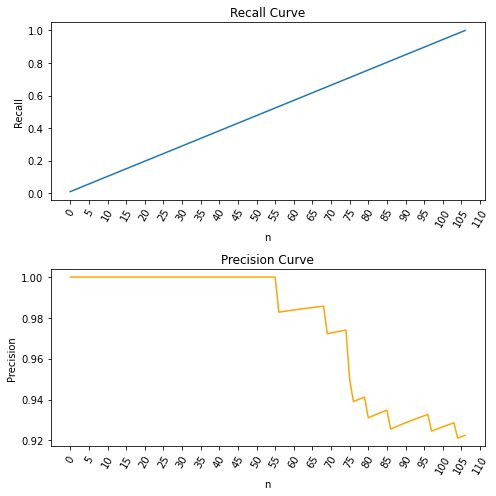

Average Recall: 0.5046728971962616 
Average Precision 0.9758483273983114


In [67]:
n = np.array(range(0,115,5))


fig = plt.figure(1, figsize=(7,7))
ax1  = fig.add_subplot(211)
ax2  = fig.add_subplot(212)

#recall
ax1.plot(recall_lst)
ax1.xaxis.set_ticks(n)
ax1.tick_params(axis = 'x',rotation = 60)
ax1.set_xlabel('n')
ax1.set_ylabel('Recall')
ax1.set_title('Recall Curve')


#precision
ax2.plot(precision_lst,color = 'orange')
ax2.xaxis.set_ticks(n)
ax2.tick_params(axis = 'x',rotation = 60)
ax2.set_xlabel('n')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Curve')

plt.tight_layout() #helps space between subplots


plt.show()
print('Average Recall:',smpl_df['Recall'].mean(),'\nAverage Precision',smpl_df['Precision'].mean())

In [74]:
import tkinter as tk
#import tkMessageBox
root= tk.Tk()
canvas1 = tk.Canvas(root, width = 800, height = 300)
canvas1.pack()

    
label1 = tk.Label(root, text='HomeDepot Product Search & Retrieval') # displaying heading
label1.config(font=('Arial', 20))
canvas1.create_window(400, 50, window=label1)

entry1 = tk.Entry (root) # creating an input window
entry1.pack()
canvas1.create_window(400, 100, window=entry1) 


button1 = tk.Button (root, text='Search',command=search_retrieval, bg='lightskyblue2', font=('Arial', 11, 'bold')) # creating a search button
button1.pack()
canvas1.create_window(400, 150, window=button1)

button2 = tk.Button (root, text='Clear Output', command=clear_charts, bg='lightsteelblue2', font=('Arial', 11, 'bold')) # creating a clear button to wipe off contents
button2.pack()
canvas1.create_window(400, 200, window=button2)

button3 = tk.Button (root, text='Exit Application', command=root.destroy, bg='red', font=('Arial', 11, 'bold')) # creating button to exit application
canvas1.create_window(400, 250, window=button3)

#block = tk.Label(root, image=icon)

lbl = tk.Label(root)
lbl.pack()

root.mainloop() # reinitialize function

[['107539', ' The 46 in. hardwood handle provides strength a...']]
[['107539', ' The 46 in. hardwood handle provides strength a...'], ['105752', " Nordic Plow's Perfect Shovel is a patent pendi..."]]
[['107539', ' The 46 in. hardwood handle provides strength a...'], ['105752', " Nordic Plow's Perfect Shovel is a patent pendi..."], ['108348', ' Provide added beauty and functionality to your...']]
[['107539', ' The 46 in. hardwood handle provides strength a...'], ['105752', " Nordic Plow's Perfect Shovel is a patent pendi..."], ['108348', ' Provide added beauty and functionality to your...'], ['106821', ' The Jackson J-250 D-Handle Round Point Shovel ...']]
[['107539', ' The 46 in. hardwood handle provides strength a...'], ['105752', " Nordic Plow's Perfect Shovel is a patent pendi..."], ['108348', ' Provide added beauty and functionality to your...'], ['106821', ' The Jackson J-250 D-Handle Round Point Shovel ...'], ['107906', ' Never break your back again shoveling snow. Th...']]
[['10

<ipython-input-44-f6d60ba4206c>:25: RuntimeWarning: divide by zero encountered in double_scalars
  sim_normalize_dict[k1]=v1/(search_length.astype('float')*len_dict[k1].astype('float')) # normalize the value of D


[['101250', ' The Johnson Hardware 1500 Series Pocket Door F...']]
[['101250', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['102249', ' The Johnson Hardware 1500 Series Pocket Door F...']]
[['101250', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['102249', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['103473', ' The Johnson Hardware 1500 Series Pocket Door F...']]
[['101250', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['102249', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['103473', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['109799', ' The Multi-Use Cart with 1,200 lb. load capacit...']]
[['101250', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['102249', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['103473', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['109799', ' The Multi-Use Cart with 1,200 lb. load capacit...'], ['106548', ' Now is your opportunity to make your house sta...']]
[['10

[['101250', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['102249', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['103473', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['109799', ' The Multi-Use Cart with 1,200 lb. load capacit...'], ['106548', ' Now is your opportunity to make your house sta...'], ['109645', ' The Polder Superlight Shopping Cart is easy to...'], ['108200', ' From stationery to files and home office suppl...'], ['103665', ' This steel utility cart is ideal for any job a...'], ['106159', ' The innovative, patent-pending design of the C...'], ['108813', ' Now is your opportunity to make your home stan...'], ['102247', ' Get the same high-performance kettle grill tha...'], ['103269', ' A brilliant chrome finish and contemporary des...'], ['109071', ' Heavy duty steel construction makes this servi...'], ['107349', ' This Steel Utility Cart has removable, fold-do...'], ['108002', ' This Sandusky Utility Cart is equipped with a ...'], ['108152'

[['101250', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['102249', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['103473', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['109799', ' The Multi-Use Cart with 1,200 lb. load capacit...'], ['106548', ' Now is your opportunity to make your house sta...'], ['109645', ' The Polder Superlight Shopping Cart is easy to...'], ['108200', ' From stationery to files and home office suppl...'], ['103665', ' This steel utility cart is ideal for any job a...'], ['106159', ' The innovative, patent-pending design of the C...'], ['108813', ' Now is your opportunity to make your home stan...'], ['102247', ' Get the same high-performance kettle grill tha...'], ['103269', ' A brilliant chrome finish and contemporary des...'], ['109071', ' Heavy duty steel construction makes this servi...'], ['107349', ' This Steel Utility Cart has removable, fold-do...'], ['108002', ' This Sandusky Utility Cart is equipped with a ...'], ['108152'

[['101250', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['102249', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['103473', ' The Johnson Hardware 1500 Series Pocket Door F...'], ['109799', ' The Multi-Use Cart with 1,200 lb. load capacit...'], ['106548', ' Now is your opportunity to make your house sta...'], ['109645', ' The Polder Superlight Shopping Cart is easy to...'], ['108200', ' From stationery to files and home office suppl...'], ['103665', ' This steel utility cart is ideal for any job a...'], ['106159', ' The innovative, patent-pending design of the C...'], ['108813', ' Now is your opportunity to make your home stan...'], ['102247', ' Get the same high-performance kettle grill tha...'], ['103269', ' A brilliant chrome finish and contemporary des...'], ['109071', ' Heavy duty steel construction makes this servi...'], ['107349', ' This Steel Utility Cart has removable, fold-do...'], ['108002', ' This Sandusky Utility Cart is equipped with a ...'], ['108152'

[['101276', " WeatherShield's 4 in. x 4 in. x 9 ft. fence po..."]]
[['101276', " WeatherShield's 4 in. x 4 in. x 9 ft. fence po..."], ['101141', ' Every doggy needs their own den. The Doggy Den...']]
[['101276', " WeatherShield's 4 in. x 4 in. x 9 ft. fence po..."], ['101141', ' Every doggy needs their own den. The Doggy Den...'], ['100465', ' The Arf Frame Dog House is a Real Wood Home fo...']]
[['101276', " WeatherShield's 4 in. x 4 in. x 9 ft. fence po..."], ['101141', ' Every doggy needs their own den. The Doggy Den...'], ['100465', ' The Arf Frame Dog House is a Real Wood Home fo...'], ['103039', ' Give your pet a place to escape the elements w...']]
[['101276', " WeatherShield's 4 in. x 4 in. x 9 ft. fence po..."], ['101141', ' Every doggy needs their own den. The Doggy Den...'], ['100465', ' The Arf Frame Dog House is a Real Wood Home fo...'], ['103039', ' Give your pet a place to escape the elements w...'], ['105991', ' Home Decorators Collection Red Dog Treat Bin i...']]
[['10

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/cjcraig/opt/anaconda3/lib/python3.8/tkinter/__init__.py", line 1883, in __call__
    return self.func(*args)
  File "<ipython-input-44-f6d60ba4206c>", line 2, in search_retrieval
    search_term = entry1.get()
  File "/Users/cjcraig/opt/anaconda3/lib/python3.8/tkinter/__init__.py", line 3038, in get
    return self.tk.call(self._w, 'get')
_tkinter.TclError: invalid command name ".!entry"
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/cjcraig/opt/anaconda3/lib/python3.8/tkinter/__init__.py", line 1883, in __call__
    return self.func(*args)
  File "<ipython-input-44-f6d60ba4206c>", line 2, in search_retrieval
    search_term = entry1.get()
  File "/Users/cjcraig/opt/anaconda3/lib/python3.8/tkinter/__init__.py", line 3038, in get
    return self.tk.call(self._w, 'get')
_tkinter.TclError: invalid command name ".!entry"
Exception in Tkinter callback
Traceback (most recent call 

KeyboardInterrupt: 